# 업체명: 드림열처리

In [1]:
### 관련자료 목록

## code
# 열처리효율화_드림열처리.ipynb

##data
#1차데이터_한국금형.xlsx
#2차데이터_한국금형.xlsx
#경화깊이스펙.xlsx

# 0.필요 라이브러리

In [55]:
import numpy as np
import pandas as pd 
import datetime as dt 
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sb
import xlsxwriter
import sklearn.model_selection as model_selection
from sklearn.model_selection import cross_val_score,KFold
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor, GradientBoostingRegressor
from patsy import dmatrix
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm

plt.rc ('font',family='Malgun Gothic')
import warnings
warnings.filterwarnings('ignore')

# 1.데이터 불러오기 및 정합률 1차 확인

In [56]:
df = pd.read_excel('0차데이터_드림열처리.xlsx')
#target_spec = pd.read_excel('경화깊이스펙.xlsx')
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10495 entries, 0 to 10494
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   measuredt  10495 non-null  datetime64[ns]
 1   가열로히터온도    10495 non-null  int64         
 2   LNG순간유량    10495 non-null  float64       
 3   CP 농도      10495 non-null  float64       
 4   RX 순간유량    10495 non-null  float64       
 5   시작일        10495 non-null  datetime64[ns]
 6   열처리        10495 non-null  object        
 7   표면경도       10495 non-null  float64       
 8   심부경도       10495 non-null  float64       
 9   경화깊이       10495 non-null  float64       
 10  재질         10495 non-null  object        
 11  수량         10495 non-null  int64         
 12  규격         10495 non-null  object        
 13  품번         10495 non-null  object        
 14  품명         10495 non-null  object        
 15  거래처        10495 non-null  object        
 16  company    10495 non-null  object       

In [5]:
import seaborn as sns

<AxesSubplot:>

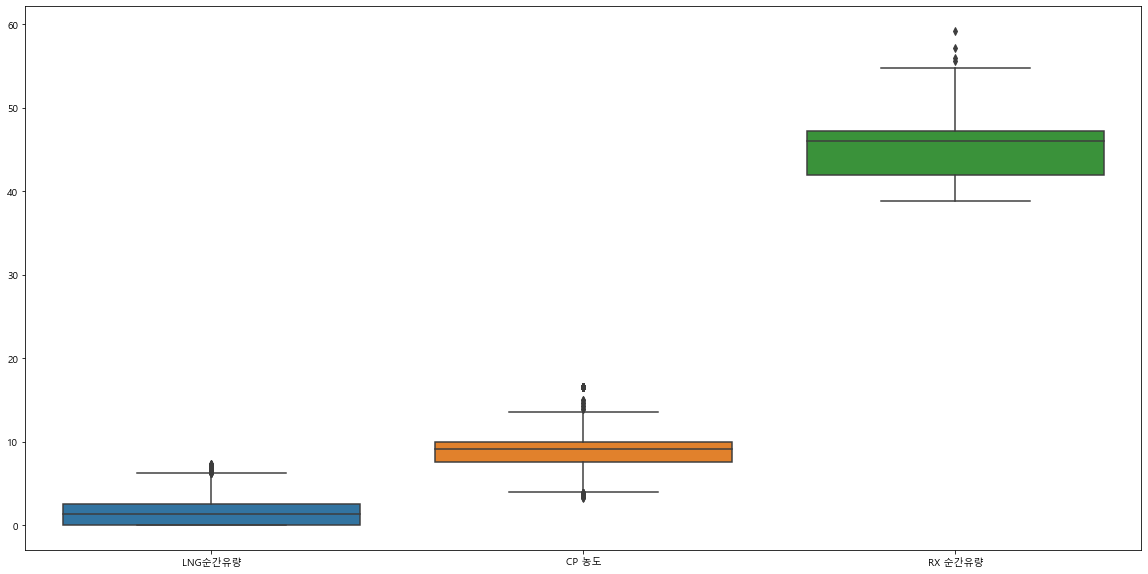

In [6]:
plt.figure(figsize=(20,10))
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
sns.boxplot(data = df[['LNG순간유량','CP 농도','RX 순간유량','시작일']])

<AxesSubplot:>

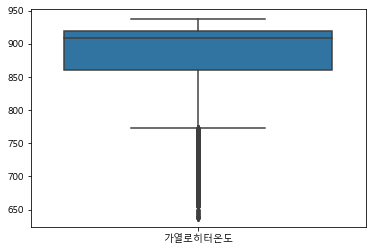

In [7]:
sns.boxplot(data = df[['가열로히터온도']])

"공정에 사용되는 컬럼들(LNG, CP, RX)"과 그에 해당하는 "변화 컬럼(가열로 히터온도)"의 경우 승온/침탄/강온의 3단계가 이루어진 컬럼으로 이상치로 판단할 수 없다.

<AxesSubplot:>

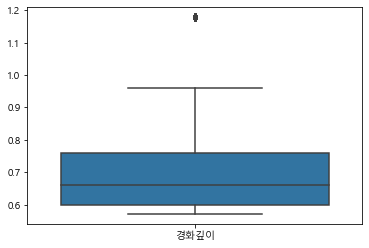

In [8]:
sns.boxplot(data = df[['경화깊이']])

경화깊이의 경우 품목별 스펙이 다름 // Target

<AxesSubplot:>

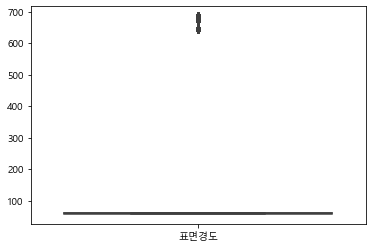

In [9]:
sns.boxplot(data = df[['표면경도']])

"표면경도"의 경우 품목마다의 표면경도가 다르다 아웃라이어라 판단할 수 없다.

<AxesSubplot:>

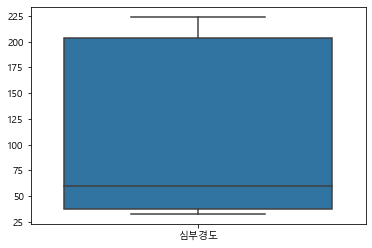

In [10]:
sns.boxplot(data = df[['심부경도']])

In [11]:
# df.to_excel('1차데이터_드림열처리.xlsx')

# 2.파생변수 생성

In [57]:
공정시간_step = (((df.groupby(['set','step']).measuredt.max()-df.groupby(['set','step']).measuredt.min()).astype('str').str[7:9]).astype(int)*60)+((df.groupby(['set','step']).measuredt.max()-df.groupby(['set','step']).measuredt.min()).astype('str').str[10:12]).astype(int)


In [58]:
공정시간_set = (((df.groupby(['set']).measuredt.max()-df.groupby(['set']).measuredt.min()).astype('str').str[7:9]).astype(int)*60)+((df.groupby(['set']).measuredt.max()-df.groupby(['set']).measuredt.min()).astype('str').str[10:12]).astype(int) 
df1 = pd.merge(df,공정시간_set,left_on='set',right_on='set').rename(columns={'measuredt_y':'공정시간_set'})

In [59]:
공정시간_step = (((df.groupby(['set','step']).measuredt.max()-df.groupby(['set','step']).measuredt.min()).astype('str').str[7:9]).astype(int)*60)+((df.groupby(['set','step']).measuredt.max()-df.groupby(['set','step']).measuredt.min()).astype('str').str[10:12]).astype(int)
df1 = pd.merge(df1,공정시간_step,left_on=['set','step'],right_on=['set','step']).rename(columns={'measuredt':'공정시간_step'})

In [60]:
온도차이_set = df.groupby('set')['가열로히터온도'].max() - df.groupby('set')['가열로히터온도'].min()
df1 = pd.merge(df1,온도차이_set,left_on='set',right_on='set').rename(columns={'가열로히터온도_y':'온도차이_set'})

In [61]:
온도합계_set = df.groupby('set')['가열로히터온도'].sum()
df1 = pd.merge(df1,온도합계_set, left_on='set', right_on='set').rename(columns={'가열로히터온도':'온도합계_set'})

In [62]:
온도평균_step = df.groupby(['set','step'])['가열로히터온도'].mean()
df1 = pd.merge(df1,온도평균_step,left_on=['set','step'],right_on=['set','step']).rename(columns={'가열로히터온도':'온도평균_step'}).round(2) 

In [63]:
온도차이_step = df.groupby(['set','step'])['가열로히터온도'].max() - df.groupby(['set','step'])['가열로히터온도'].min()
df1 = pd.merge(df1,온도차이_step,left_on=['set','step'],right_on=['set','step']).rename(columns={'가열로히터온도':'온도차이_step'})

In [64]:
온도합계_step = df.groupby(['set','step'])['가열로히터온도'].sum()
df1 = pd.merge(df1,온도합계_step,left_on=['set','step'],right_on=['set','step']).rename(columns={'가열로히터온도':'온도합계_step'})

In [65]:
df1 = pd.merge(df1,df.groupby(['set','step'])['LNG순간유량'].sum(),left_on=['set','step'],right_on=['set','step']).rename(columns={'LNG순간유량_y':'LNG유량합계_step'})
df1 = pd.merge(df1,df.groupby(['set'])['LNG순간유량'].sum(),left_on=['set'],right_on=['set']).rename(columns={'LNG순간유량':'LNG유량합계_set'})

In [66]:
df1 = pd.merge(df1,df.groupby(['set','step'])['CP 농도'].sum(),left_on=['set','step'],right_on=['set','step']).rename(columns={'CP 농도_y':'CP농도합계_step'})
df1 = pd.merge(df1,df.groupby(['set'])['CP 농도'].sum(),left_on=['set'],right_on=['set']).rename(columns={'CP 농도':'CP농도합계_set'})

In [67]:
df1 = pd.merge(df1,df.groupby(['set','step'])['RX 순간유량'].sum(),left_on=['set','step'],right_on=['set','step']).rename(columns={'RX 순간유량_y':'RX유량합계_step'})
df1 = pd.merge(df1,df.groupby(['set'])['RX 순간유량'].sum(),left_on=['set'],right_on=['set']).rename(columns={'RX 순간유량':'RX유량합계_set'})

In [68]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10495 entries, 0 to 10494
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   measuredt_x   10495 non-null  datetime64[ns]
 1   가열로히터온도_x     10495 non-null  int64         
 2   LNG순간유량_x     10495 non-null  float64       
 3   CP 농도_x       10495 non-null  float64       
 4   RX 순간유량_x     10495 non-null  float64       
 5   시작일           10495 non-null  datetime64[ns]
 6   열처리           10495 non-null  object        
 7   표면경도          10495 non-null  float64       
 8   심부경도          10495 non-null  float64       
 9   경화깊이          10495 non-null  float64       
 10  재질            10495 non-null  object        
 11  수량            10495 non-null  int64         
 12  규격            10495 non-null  object        
 13  품번            10495 non-null  object        
 14  품명            10495 non-null  object        
 15  거래처           10495 non-null  object

In [69]:
df1 = df1.rename(columns={'measuredt_x':'measuredt',
                          '가열로히터온도_x':'가열로히터온도',
                          'LNG순간유량_x':'LNG순간유량',
                          'CP 농도_x':'CP농도',
                          'RX 순간유량_x':'RX순간유량',
                          '수량':'수량_set'})

In [70]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10495 entries, 0 to 10494
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   measuredt     10495 non-null  datetime64[ns]
 1   가열로히터온도       10495 non-null  int64         
 2   LNG순간유량       10495 non-null  float64       
 3   CP농도          10495 non-null  float64       
 4   RX순간유량        10495 non-null  float64       
 5   시작일           10495 non-null  datetime64[ns]
 6   열처리           10495 non-null  object        
 7   표면경도          10495 non-null  float64       
 8   심부경도          10495 non-null  float64       
 9   경화깊이          10495 non-null  float64       
 10  재질            10495 non-null  object        
 11  수량_set        10495 non-null  int64         
 12  규격            10495 non-null  object        
 13  품번            10495 non-null  object        
 14  품명            10495 non-null  object        
 15  거래처           10495 non-null  object

열처리 용어 설명

http://www.nogoora.com/entry/%EC%97%B4%EC%B2%98%EB%A6%AC%EC%9D%98-%EC%A2%85%EB%A5%98-%EB%B0%8F-%EC%84%A4%EB%AA%85

잔류 응력
https://m.blog.naver.com/psd1539/222019901428

열처리에서 경도 인성
https://blog.daum.net/sulaim/14907625

In [19]:
df1.isnull().sum()

measuredt       0
가열로히터온도         0
LNG순간유량         0
CP농도            0
RX순간유량          0
시작일             0
열처리             0
표면경도            0
심부경도            0
경화깊이            0
재질              0
수량_set          0
규격              0
품번              0
품명              0
거래처             0
company         0
id              0
LOTNO           0
set             0
step            0
공정시간_set        0
온도차이_set        0
온도합계_set        0
온도평균_step       0
온도차이_step       0
온도합계_step       0
LNG유량합계_step    0
LNG유량합계_set     0
CP농도합계_step     0
CP농도합계_set      0
RX유량합계_step     0
RX유량합계_set      0
dtype: int64

EDA, Explanatory Data Analysis

Text(0, 0.5, 'CP농도')

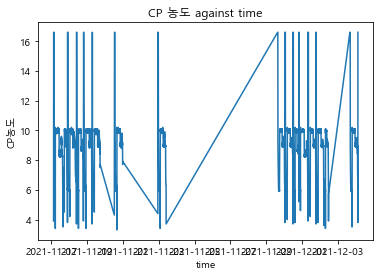

In [99]:
plt.plot(df1['measuredt'],df1['CP농도'])
plt.title('CP 농도 against time')
plt.xlabel('time')
plt.ylabel('CP농도')

Text(0, 0.5, 'temperature')

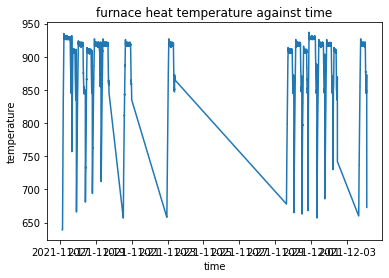

In [96]:
plt.plot(df1['measuredt'],df1['가열로히터온도'])
plt.title('furnace heat temperature against time')
plt.xlabel('time')
plt.ylabel('temperature')

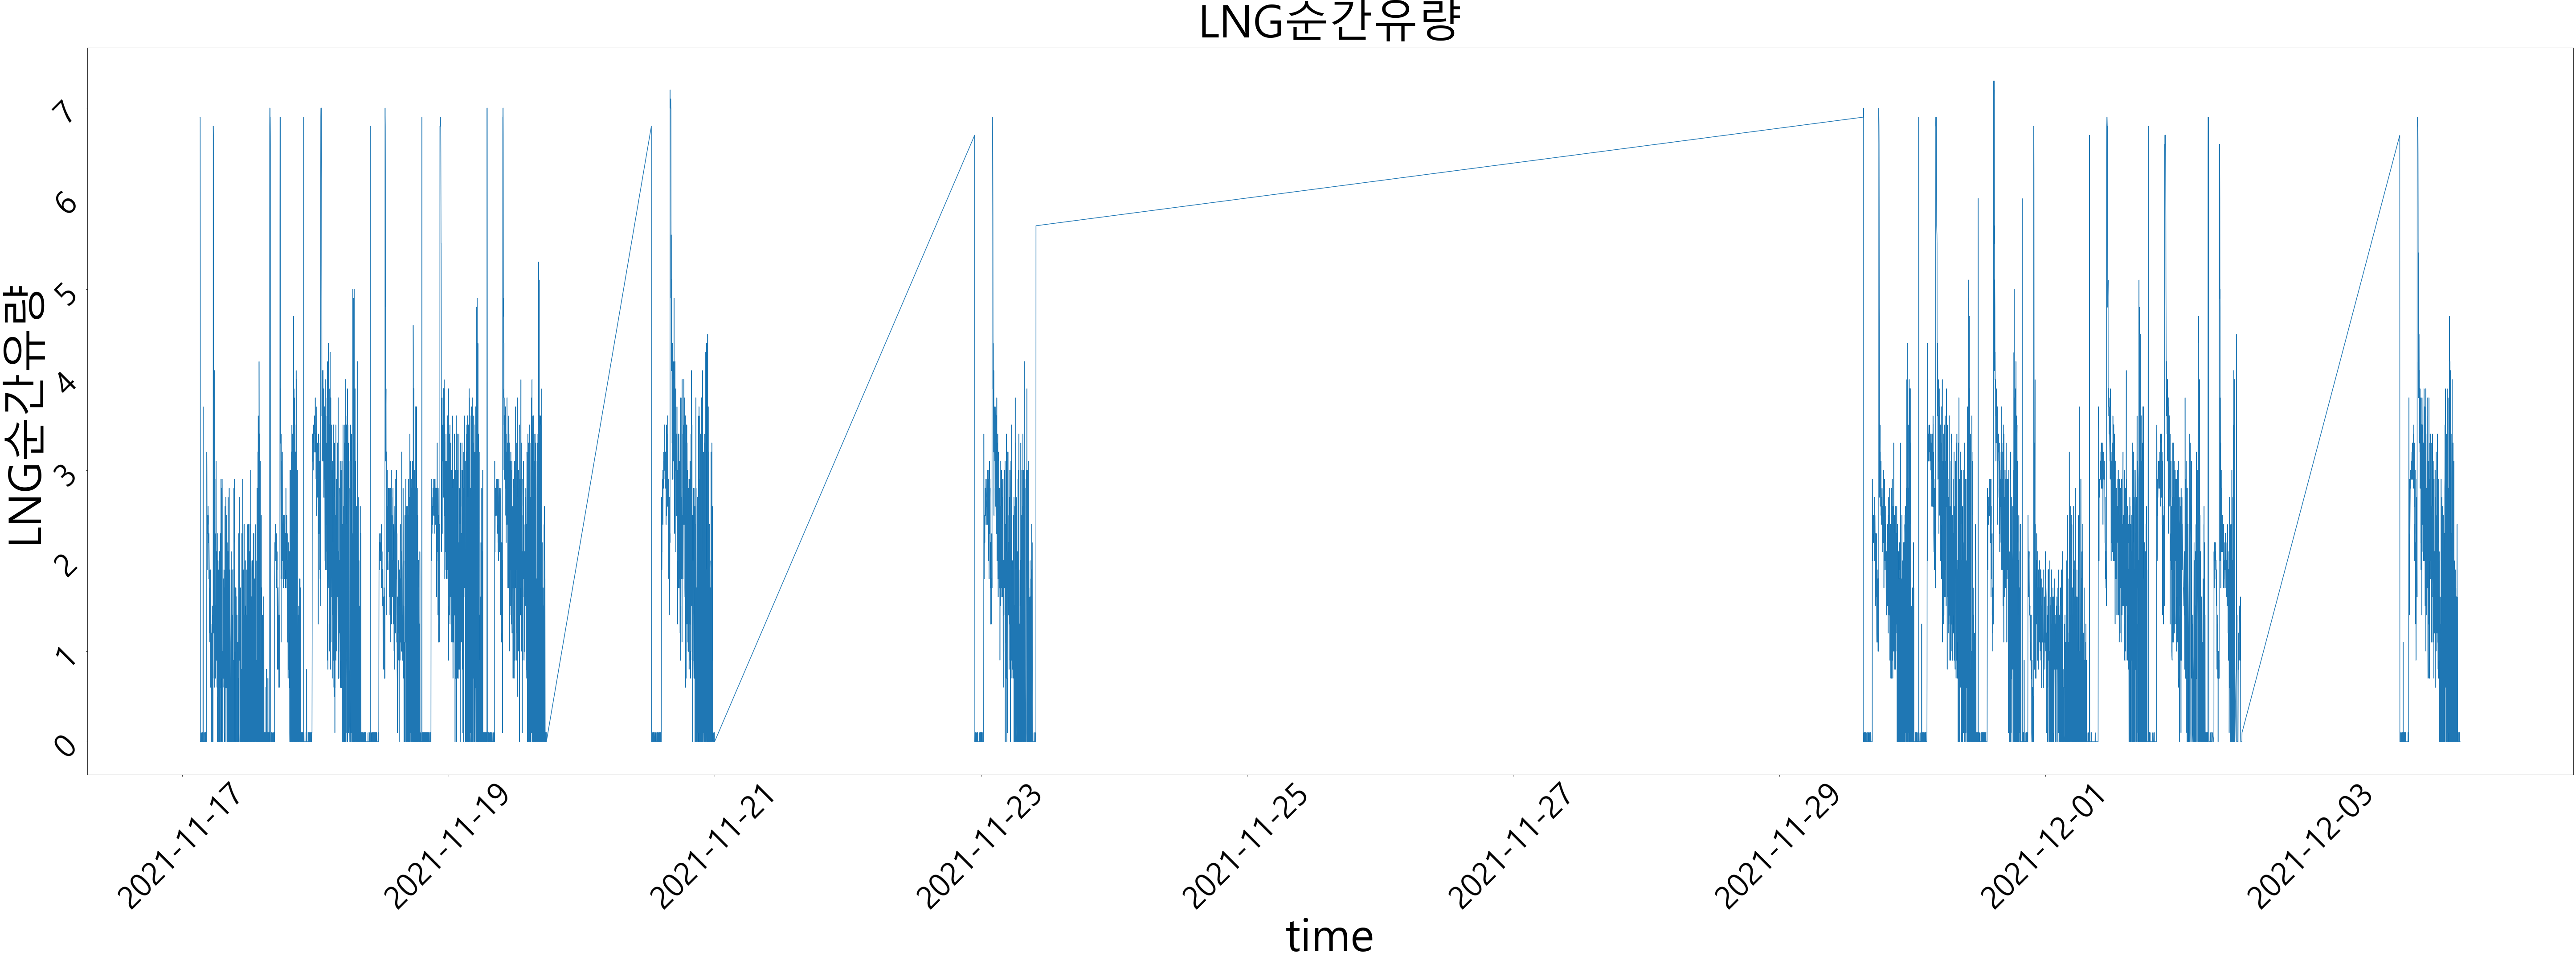

In [100]:
plt.figure(figsize=(100,30))
x=df1['measuredt']
y=df1['LNG순간유량']
plt.plot(x,y,label='LNG순간유량')
plt.title('LNG순간유량',fontsize=100)
plt.xticks(fontsize=70,rotation=45)
plt.yticks(fontsize=70,rotation=45)
plt.xlabel('time',fontsize=100)
plt.ylabel('LNG순간유량',fontsize=100)
plt.show()

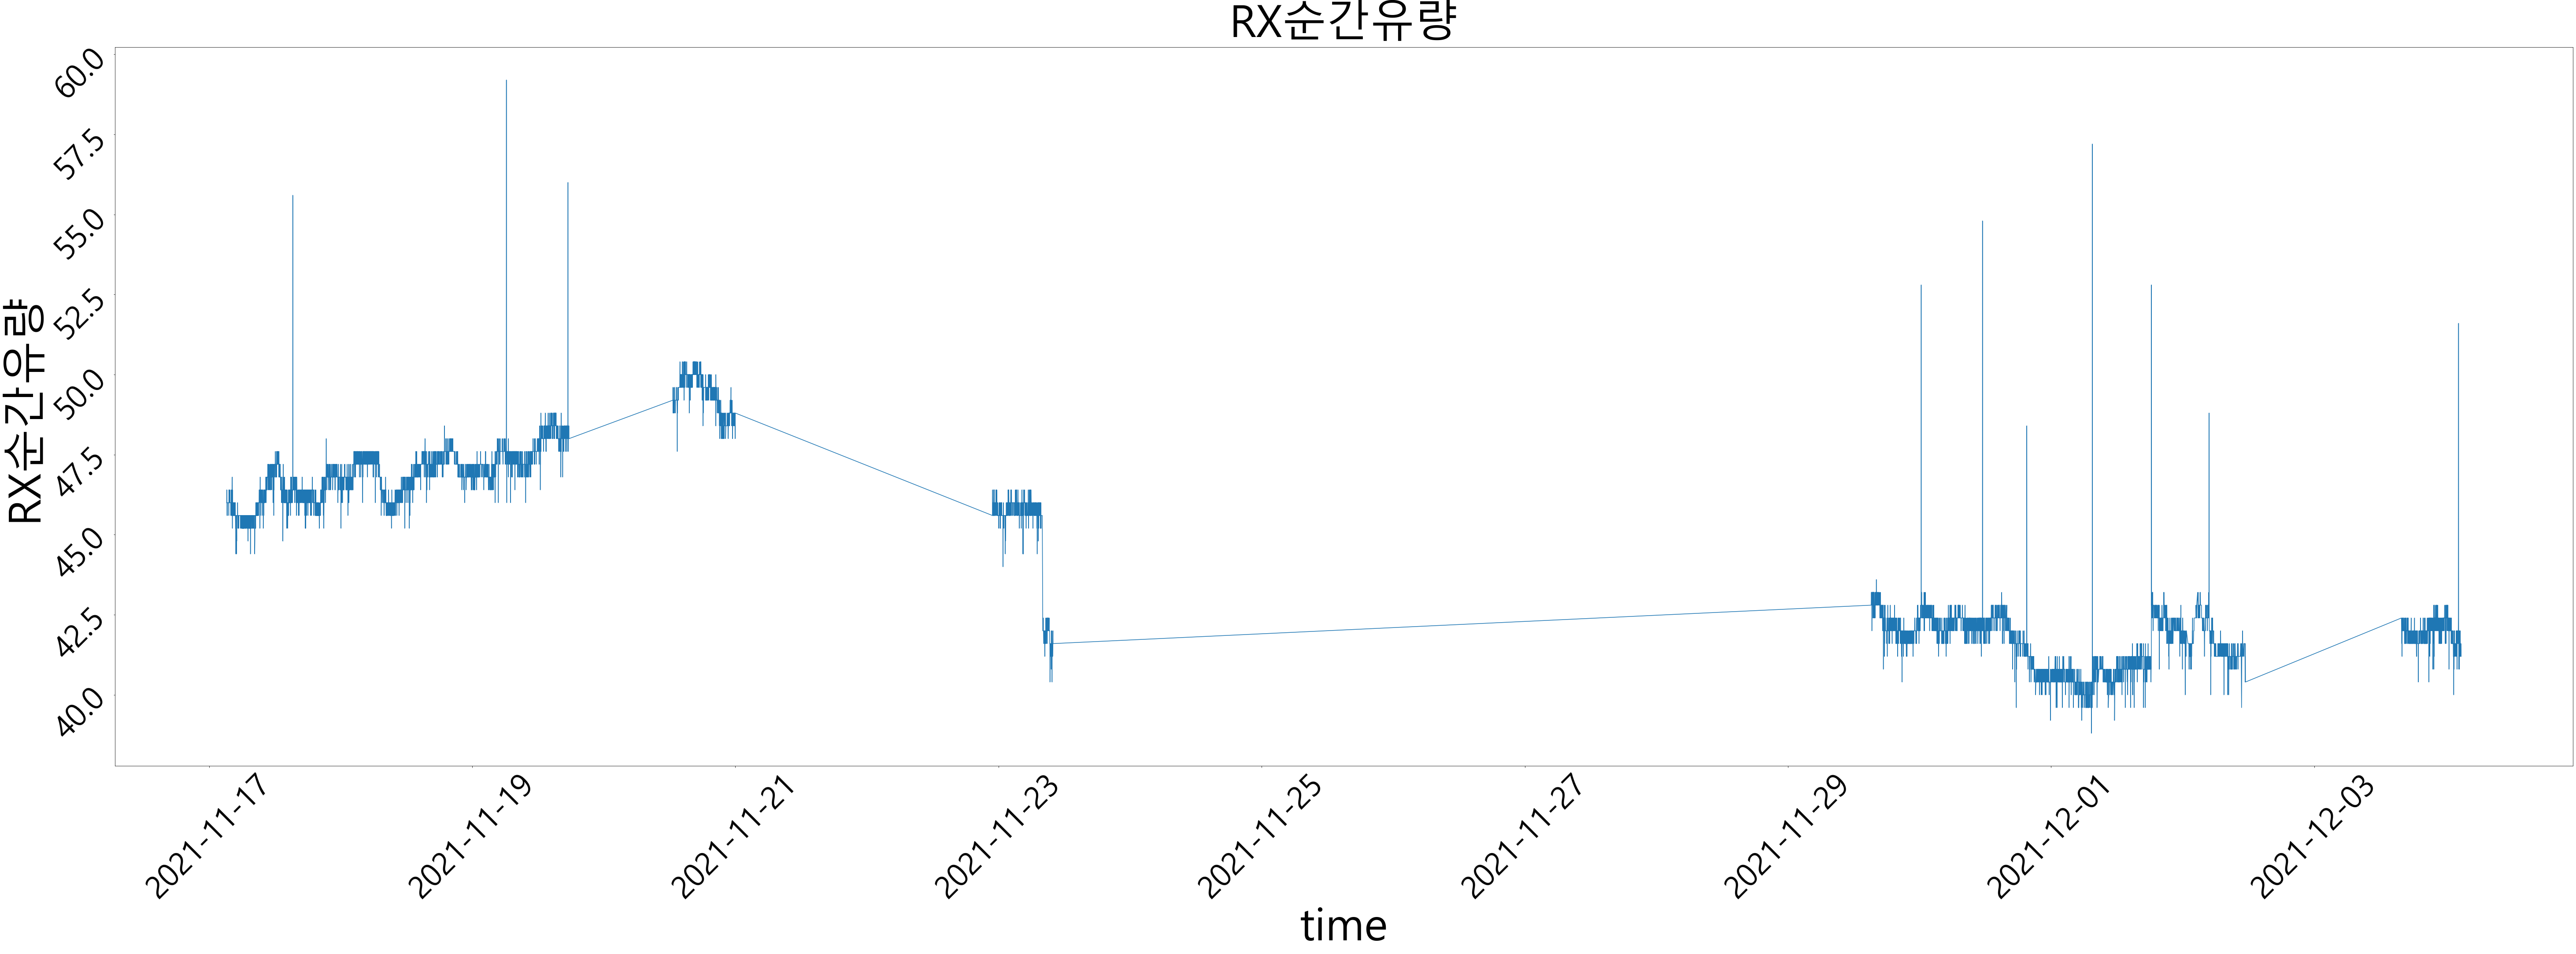

In [101]:
plt.figure(figsize=(100,30))
x=df1['measuredt']
y=df1['RX순간유량']
plt.plot(x,y,label='RX순간유량')
plt.title('RX순간유량',fontsize=100)
plt.xticks(fontsize=70,rotation=45)
plt.yticks(fontsize=70,rotation=45)
plt.xlabel('time',fontsize=100)
plt.ylabel('RX순간유량',fontsize=100)
plt.show()

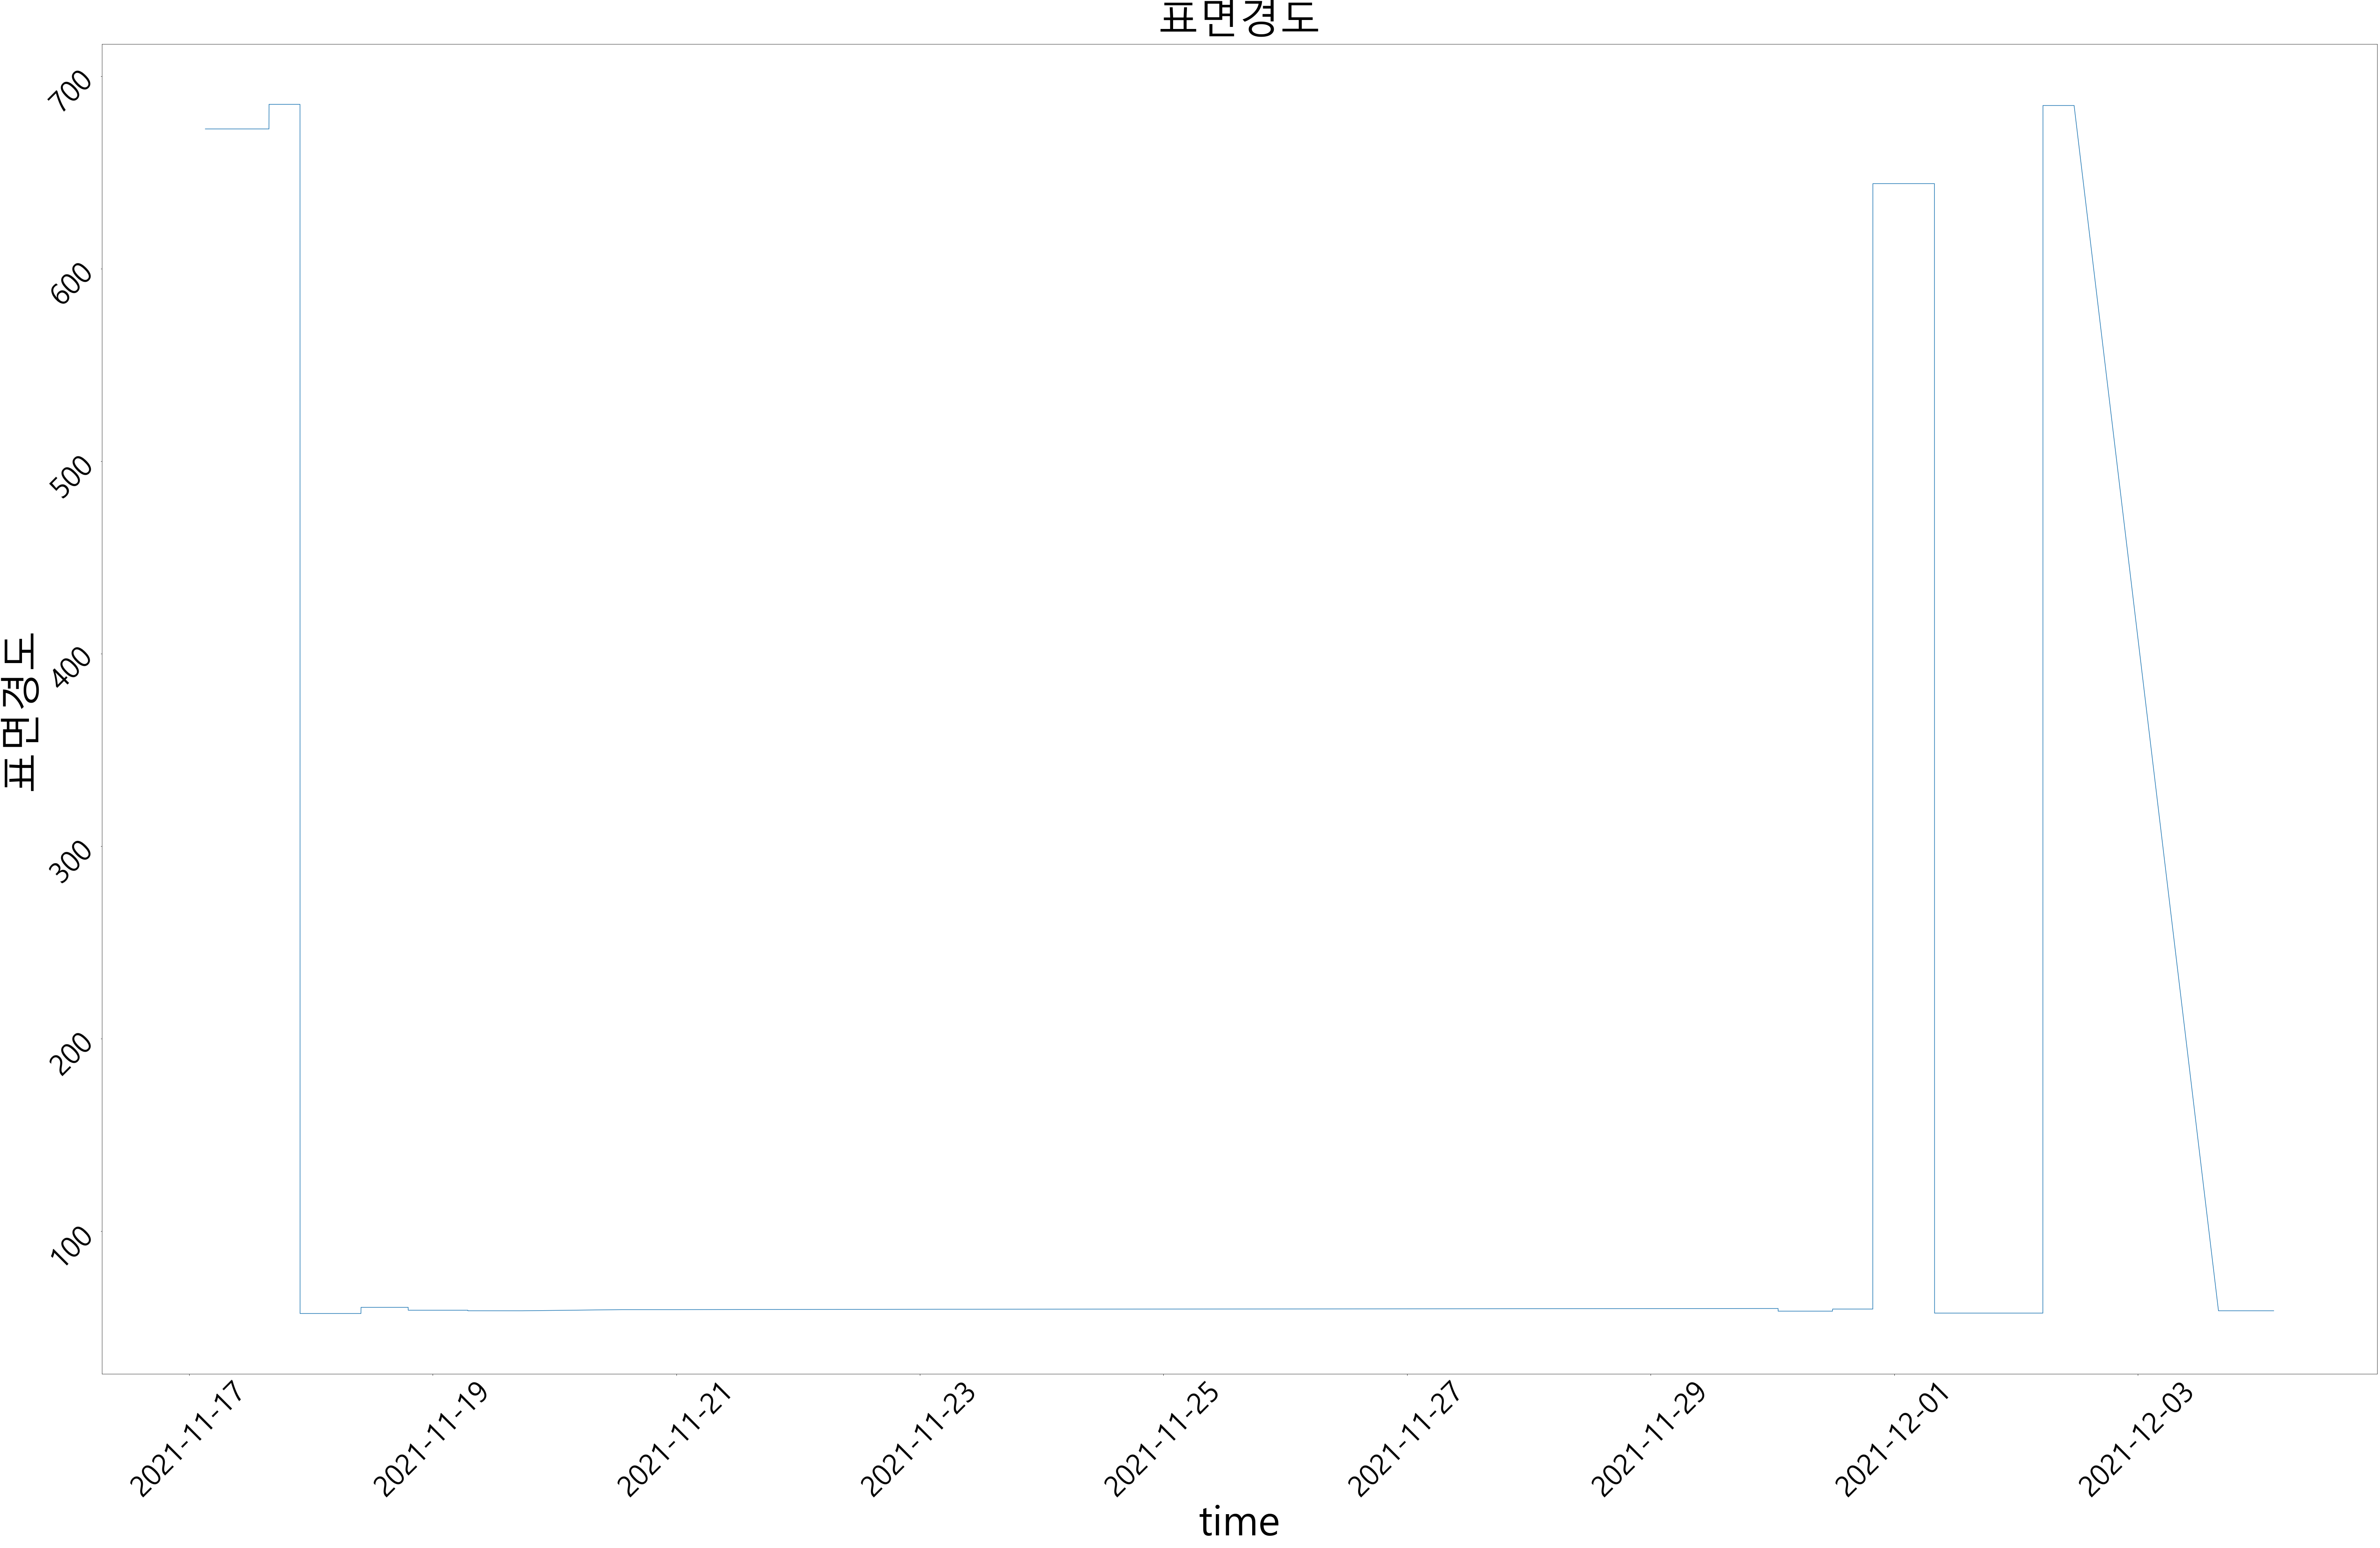

In [105]:
plt.figure(figsize=(100,60))
x=df1['measuredt']
y=df1['표면경도']
plt.plot(x,y,label='표면경도')
plt.title('표면경도',fontsize=100)
plt.xticks(fontsize=70,rotation=45)
plt.yticks(fontsize=70,rotation=45)
plt.xlabel('time',fontsize=100)
plt.ylabel('표면경도',fontsize=100)
plt.show()

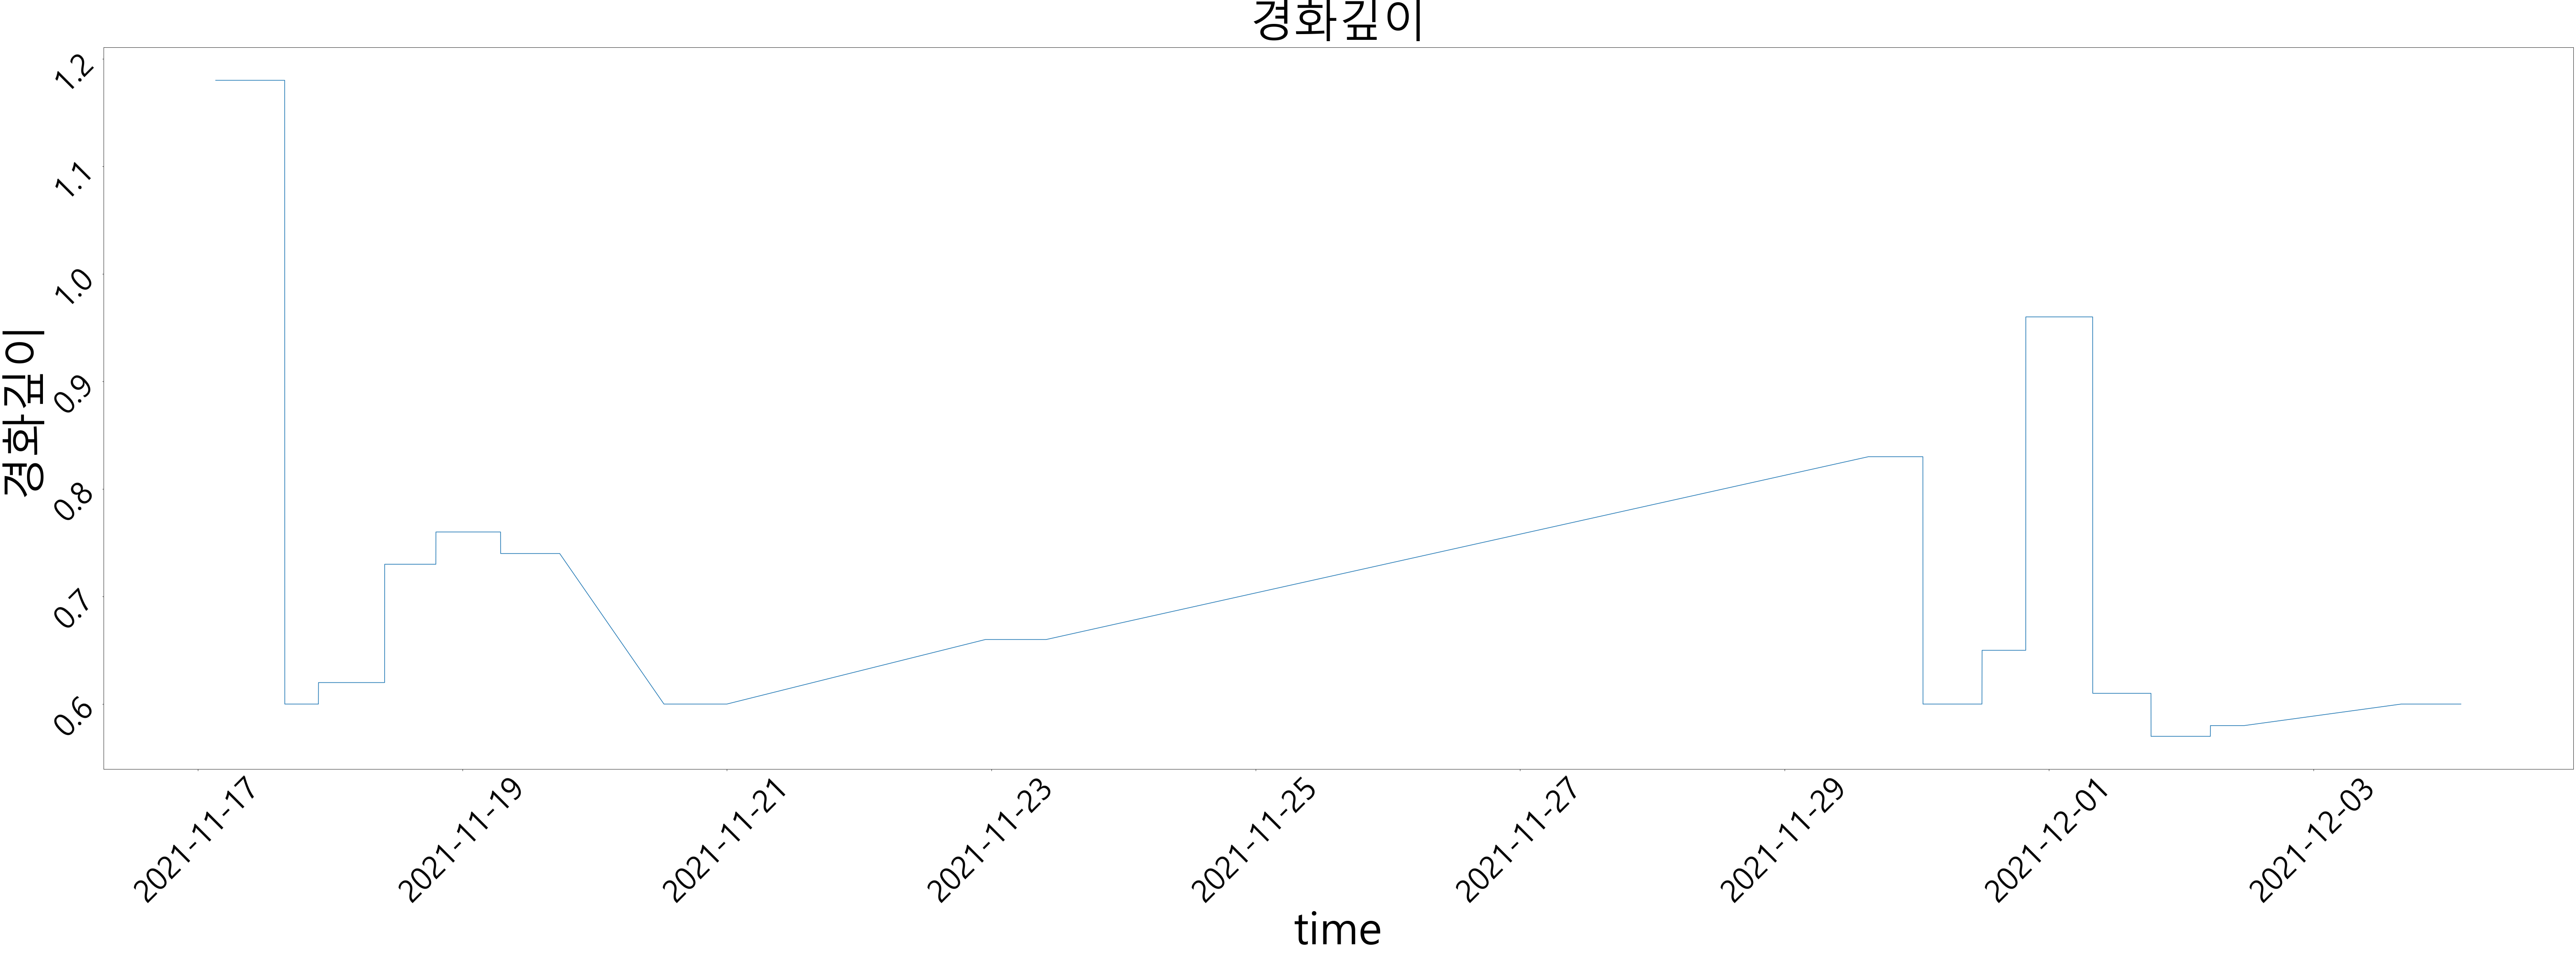

In [103]:
plt.figure(figsize=(100,30))
x=df1['measuredt']
y=df1['경화깊이']
plt.plot(x,y,label='경화깊이')
plt.title('경화깊이',fontsize=100)
plt.xticks(fontsize=70,rotation=45)
plt.yticks(fontsize=70,rotation=45)
plt.xlabel('time',fontsize=100)
plt.ylabel('경화깊이',fontsize=100)
plt.show()

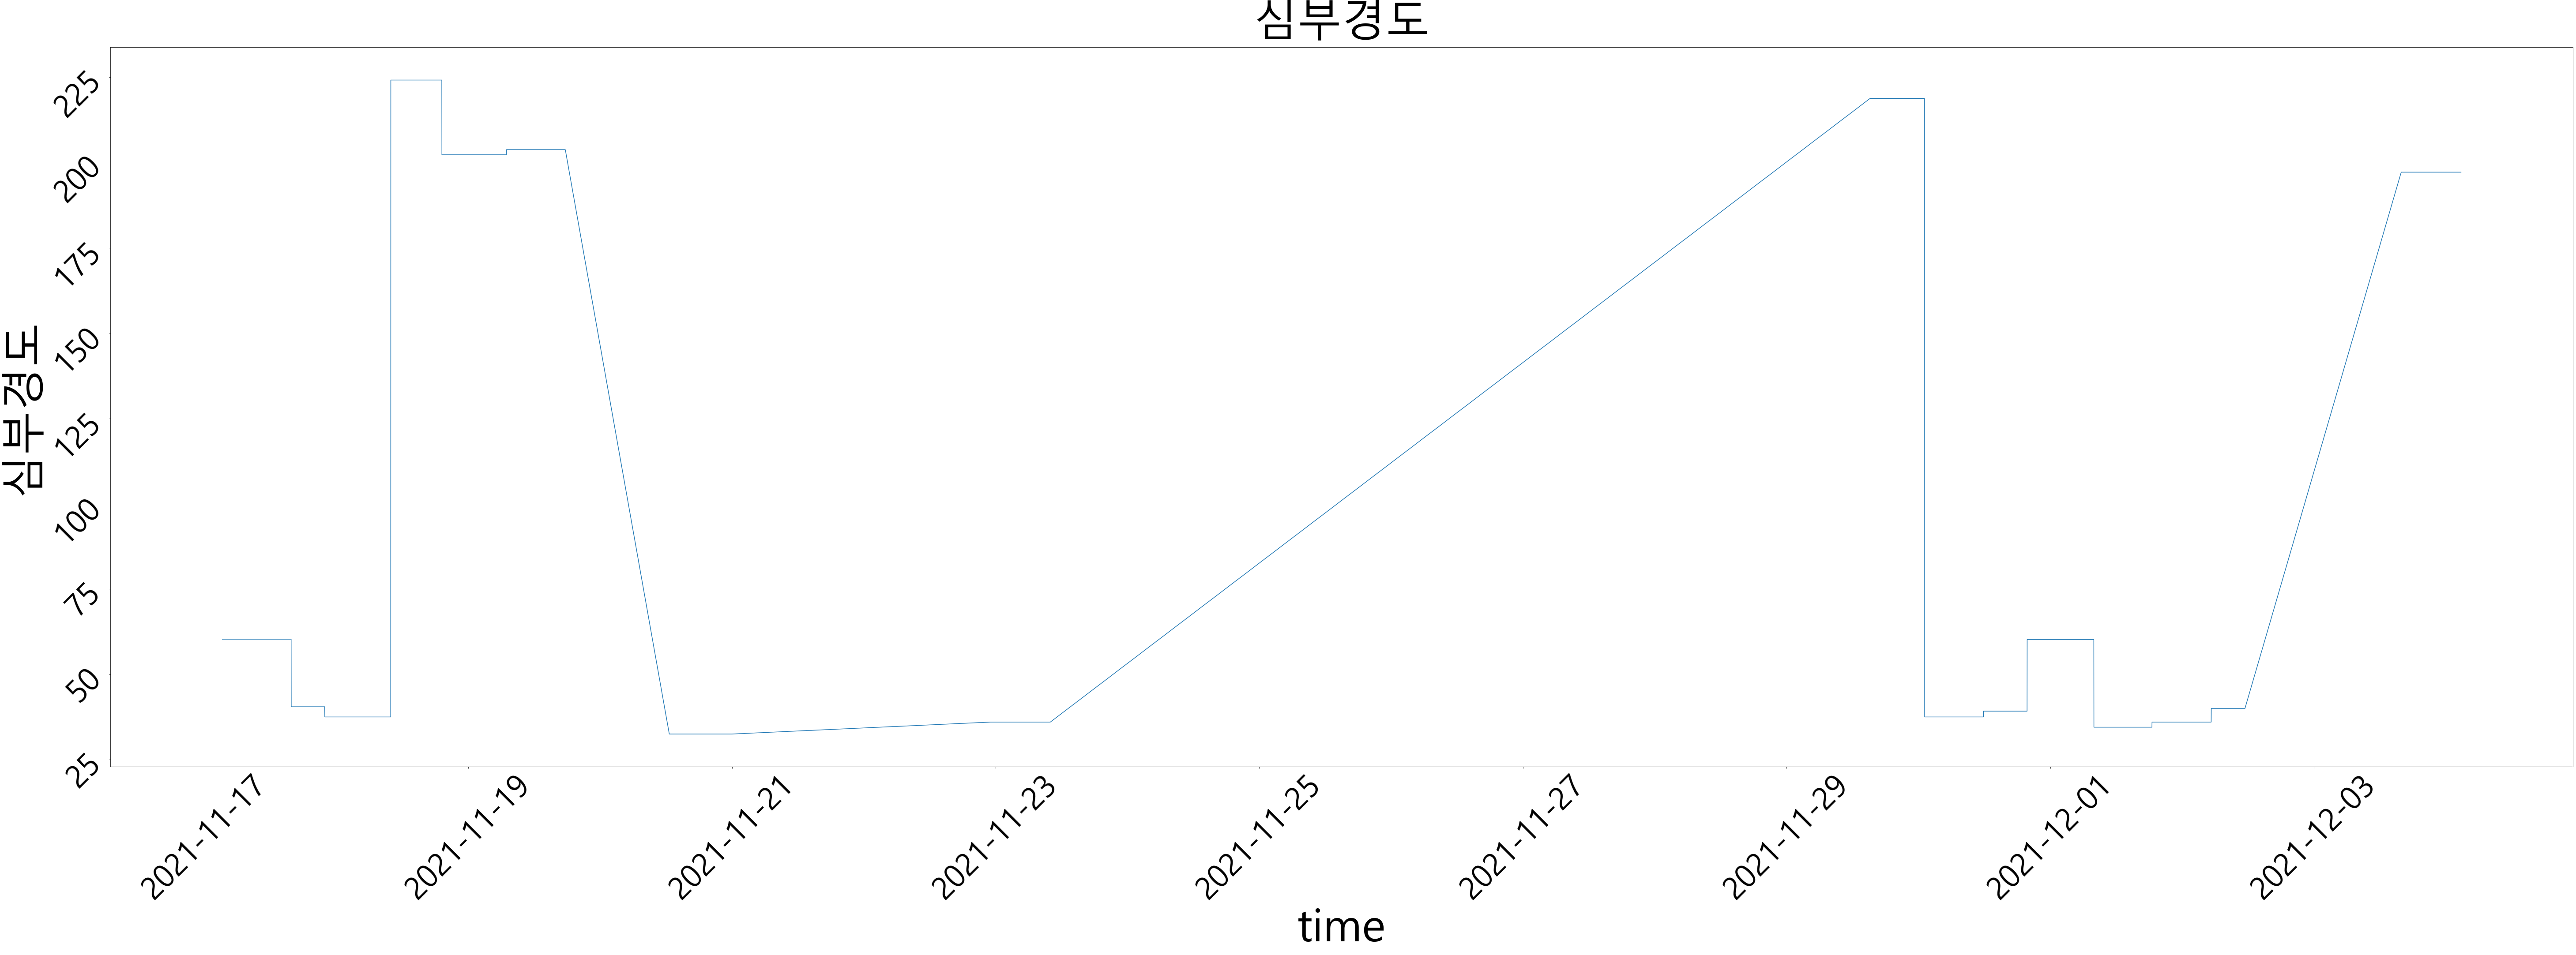

In [104]:
plt.figure(figsize=(100,30))
x=df1['measuredt']
y=df1['심부경도']
plt.plot(x,y,label='심부경도')
plt.title('심부경도',fontsize=100)
plt.xticks(fontsize=70,rotation=45)
plt.yticks(fontsize=70,rotation=45)
plt.xlabel('time',fontsize=100)
plt.ylabel('심부경도',fontsize=100)
plt.show()

심부경도와 주요변수간의 산포도

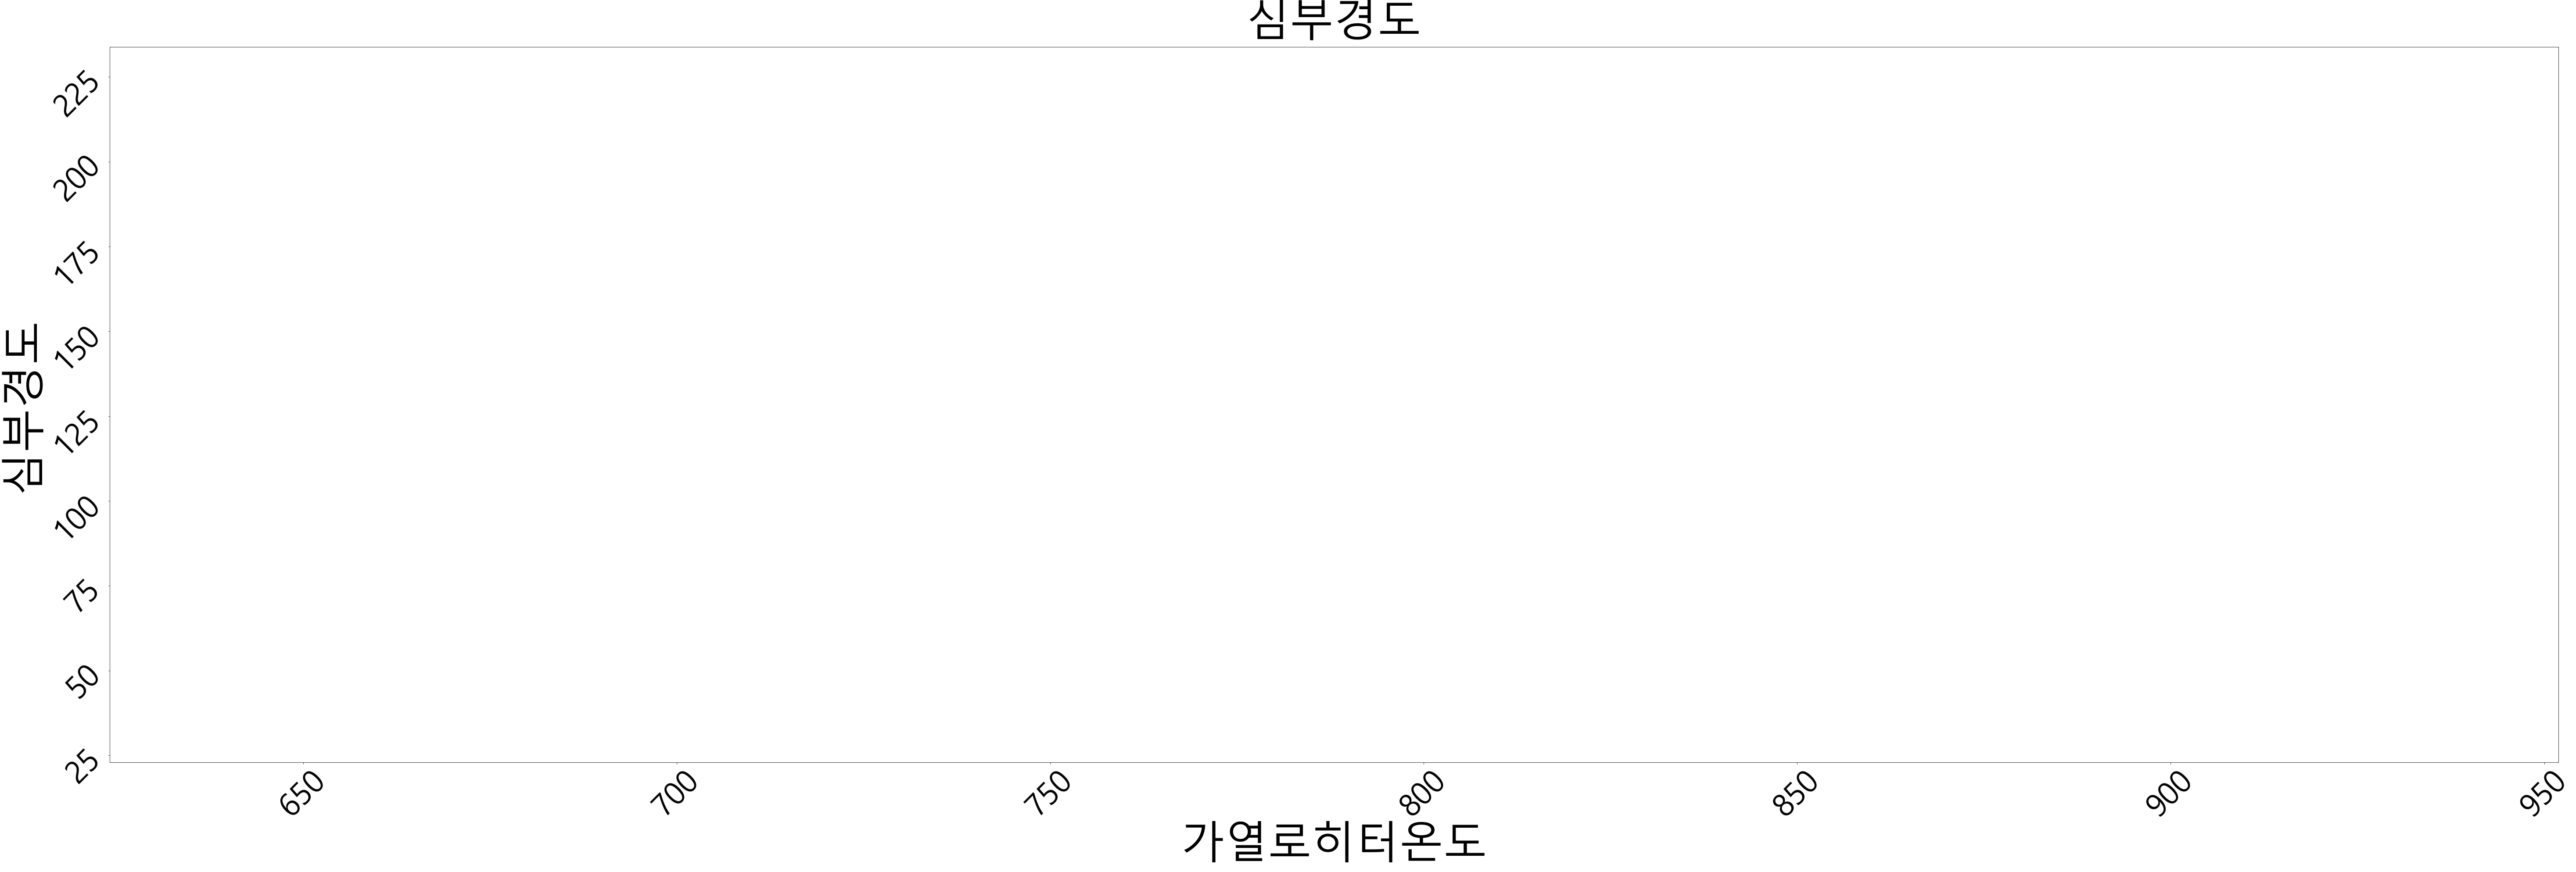

In [39]:
plt.figure(figsize=(100,30))
x=df1['가열로히터온도']
y=df1['심부경도']
plt.plot(x,y,ls='none',label='가열로히터온도에 따른 심부경도')
plt.title('심부경도',fontsize=100)
plt.xticks(fontsize=70,rotation=45)
plt.yticks(fontsize=70,rotation=45)
plt.xlabel('가열로히터온도',fontsize=100)
plt.ylabel('심부경도',fontsize=100)
plt.show()

In [369]:
import seaborn as sns

In [18]:
df11=df[['경화깊이','가열로히터온도', 'LNG순간유량', 'CP 농도', 'RX 순간유량']]

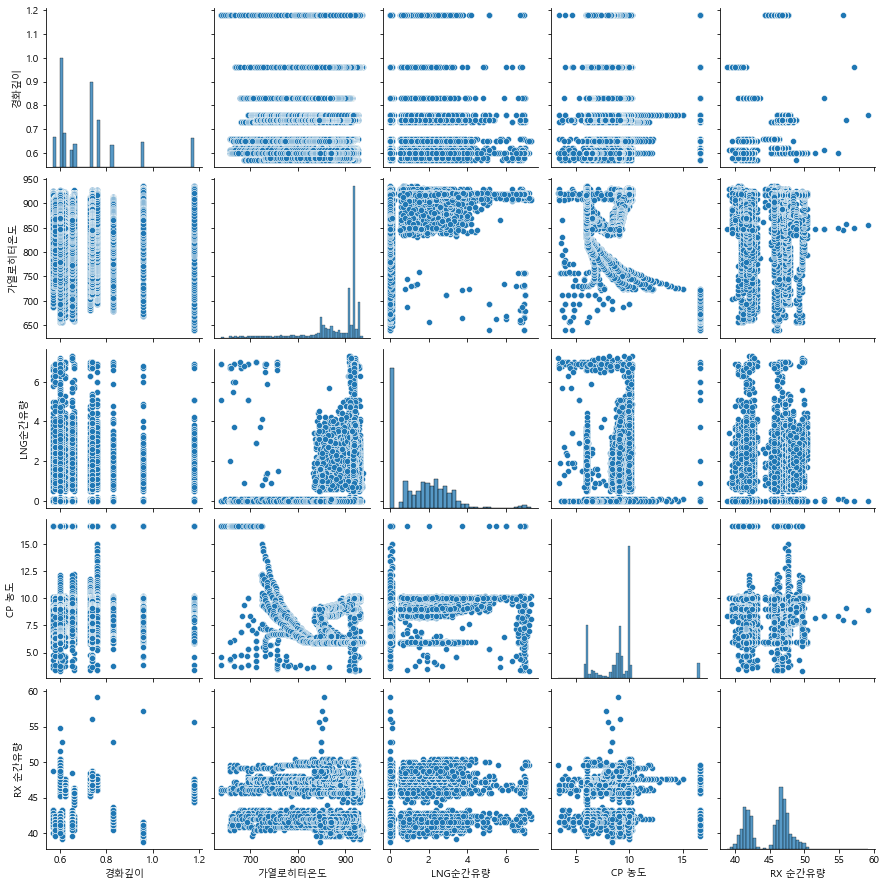

In [379]:
sns.pairplot(df11)

In [113]:
df1.head()

,measuredt,가열로히터온도,LNG순간유량,CP농도,RX순간유량,시작일,열처리,표면경도,심부경도,경화깊이,...,온도평균_step,온도차이_step,온도합계_step,LNG유량합계_step,LNG유량합계_set,CP농도합계_step,CP농도합계_set,RX유량합계_step,RX유량합계_set,데이터구분
0,2021-11-17 03:12:00,639,6.9,3.9,46.0,2021-11-17 03:41:00,침탄,672.6,60.3,1.18,...,799.57,296,93550,115.0,659.3,1022.6,6486.3,5359.2,33290.0,0
1,2021-11-17 03:13:00,639,6.9,4.6,46.0,2021-11-17 03:41:00,침탄,672.6,60.3,1.18,...,799.57,296,93550,115.0,659.3,1022.6,6486.3,5359.2,33290.0,1
2,2021-11-17 03:14:00,639,5.1,16.6,46.4,2021-11-17 03:41:00,침탄,672.6,60.3,1.18,...,799.57,296,93550,115.0,659.3,1022.6,6486.3,5359.2,33290.0,0
3,2021-11-17 03:15:00,639,0.0,16.6,46.0,2021-11-17 03:41:00,침탄,672.6,60.3,1.18,...,799.57,296,93550,115.0,659.3,1022.6,6486.3,5359.2,33290.0,1
4,2021-11-17 03:16:00,639,0.0,16.6,46.0,2021-11-17 03:41:00,침탄,672.6,60.3,1.18,...,799.57,296,93550,115.0,659.3,1022.6,6486.3,5359.2,33290.0,1


In [260]:
df1.columns

Index(['measuredt_x', '가열로히터온도', 'LNG순간유량', 'CP 농도', 'RX 순간유량', '시작일', '열처리',
       '표면경도', '심부경도', '경화깊이', '재질', '수량', '규격', '품번', '품명', '거래처', 'company',
       'id', 'LOTNO', 'set', 'step', '공정시간_set'],
      dtype='object')

In [262]:
df1.groupby('품번')[['경화깊이','가열로히터온도','LNG순간유량', 'CP 농도', 'RX 순간유량','공정시간_set']].mean()

,경화깊이,가열로히터온도,LNG순간유량,CP 농도,RX 순간유량,공정시간_set
품번,,,,,,
45753-02400,0.591360,877.254400,1.540640,8.215840,44.104320,366.864000
BM840-TF000,0.650000,865.923990,1.751069,8.928029,42.036105,475.000000
BM844 TH051,0.767672,872.678375,1.275826,8.934986,45.137466,571.692149
GC04400710,1.180000,899.588643,0.913158,8.983795,46.108033,752.000000
GC04410210,0.960000,901.680195,0.786201,8.893344,40.516234,728.000000
OP131-HD100,0.611591,879.958242,1.645715,8.951692,43.474127,664.811408
OP131-HD500,0.719519,886.358598,1.743005,8.974391,47.875927,675.071119


correlation matrix of 심부경도 with other features and target

In [274]:
df1.corrwith(df1['경화깊이'],method='pearson')

가열로히터온도     0.102080
LNG순간유량    -0.171348
CP 농도       0.016697
RX 순간유량     0.064216
표면경도        0.596478
심부경도        0.148370
경화깊이        1.000000
수량         -0.391049
id         -0.282991
공정시간_set    0.417326
dtype: float64

In [36]:
df1.corrwith(df1['공정시간_set'],method='pearson')

가열로히터온도         0.090647
LNG순간유량        -0.048379
CP농도            0.055310
RX순간유량          0.183866
표면경도           -0.107138
심부경도           -0.014542
경화깊이            0.417326
수량_set         -0.343032
id             -0.190723
공정시간_set        1.000000
공정시간_step       0.390990
온도차이_set        0.698830
온도합계_set        0.421866
온도평균_step       0.120090
온도차이_step      -0.036635
온도합계_step       0.303222
LNG유량합계_step    0.177252
LNG유량합계_set     0.265527
CP농도합계_step     0.295225
CP농도합계_set      0.424641
RX유량합계_step     0.298967
RX유량합계_set      0.386739
dtype: float64

## 가 4 featrues :linear regression 

target:'경화깊이'

In [20]:
X=df1.iloc[:,1:5].values
y=df1.iloc[:,9].values

In [21]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              stratify=y,random_state=101)

In [22]:
lm = LinearRegression(fit_intercept=True, normalize=True, n_jobs=None) 
lm.fit(X_train, y_train) 
accuracy = lm.score(X_train, y_train) 
print("lm.coef_:",lm.coef_) 
print("lm.intercept_:",lm.intercept_) 
y_pred = lm.predict(X_test)
print("r_square:",format(r2_score(y_test,y_pred))) 


lm.coef_: [ 0.00053492 -0.02666518  0.0037995   0.00380241]
lm.intercept_: 0.08741472390501681
r_square: 0.08247669681867487


target:'심부경도'

In [23]:
X=df1.iloc[:,1:5].values
y=df1.iloc[:,8].values

In [24]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              stratify=y,random_state=101)

In [25]:
lm = LinearRegression(fit_intercept=True, normalize=True, n_jobs=None) 
lm.fit(X_train, y_train) 
accuracy = lm.score(X_train, y_train) 
print("lm.coef_:",lm.coef_) 
print("lm.intercept_:",lm.intercept_) 
y_pred = lm.predict(X_test)
print("r_square:",format(r2_score(y_test,y_pred))) 
print('accuracy:',accuracy)

lm.coef_: [-0.02277118 -0.02924578  0.81181611  8.18656296]
lm.intercept_: -242.15554213500207
r_square: 0.08577003301405772
accuracy: 0.0807082330547948


explanation

In [ ]:

features: 가열로히터온도', 'LNG순간유량', 'CP농도', 'RX순간유량'
target:'심부경도',

higer absolute intercept
higher temperature decreases the inside hardness, that is the change of temperature 1 degree incurs -0.0227 of change of the hardness
LNG instant flows also trigger the similar change. however, CP denseness and RX instant flow make the hardness deeper


target:'표면경도'

In [26]:
X=df1.iloc[:,1:5].values
y=df1.iloc[:,7].values

In [27]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              stratify=y,random_state=101)

In [22]:
lm = LinearRegression(fit_intercept=True, normalize=True, n_jobs=None) 
lm.fit(X_train, y_train) 
accuracy = lm.score(X_train, y_train) 
print("lm.coef_:",lm.coef_) 
print("lm.intercept_:",lm.intercept_)
y_train_pred=lm.predict(X_train)
y_test_pred = lm.predict(X_test)

print('train MSE: %.3f, test MSE %.3f' %(
mean_squared_error(y_train,y_train_pred),
mean_squared_error(y_test,y_test_pred),
    
))
print("train r_square: %.3f, test r_square: %.3f" % (r2_score(y_train,y_train_pred), r2_score(y_test,y_test_pred))) 


lm.coef_: [-0.02277118 -0.02924578  0.81181611  8.18656296]
lm.intercept_: -242.155542135002
train MSE: 6323.844, test MSE 6288.895
train r_square: 0.081, test r_square: 0.086


## 나  4 features lienear regression with standard scaler

Pipeline

In [28]:
from sklearn.pipeline import make_pipeline

In [29]:
pipe_lr=make_pipeline(StandardScaler(),
                     LinearRegression(fit_intercept=True, normalize=True, n_jobs=None))

KFold

심부경도 경우

In [57]:
kfold=KFold(n_splits=10).split(X_train,y_train)
scores=[]
coefs=[ ]
intercepts=[]
for k,(train,test) in enumerate(kfold):
    pipe_lr.fit(X_train[train],y_train[train])
    score=pipe_lr.score(X_train[test],y_train[test])
    y_train_pred=lm.predict(X_train)
    y_pred = lm.predict(X_test)
    print("lm.coef_:",lm.coef_) 
    print("lm.intercept_:",lm.intercept_)
    coefs.append(lm.coef_)
    intercepts.append(lm.intercept_)
    scores.append(score)
    print('Fold: %2d, R_square: %.3f' % (k+1,r2_score(y_test,y_pred)))

lm.coef_: [-0.02277118 -0.02924578  0.81181611  8.18656296]
lm.intercept_: -242.15554213500212
Fold:  1, R_square: 0.086
lm.coef_: [-0.02277118 -0.02924578  0.81181611  8.18656296]
lm.intercept_: -242.15554213500212
Fold:  2, R_square: 0.086
lm.coef_: [-0.02277118 -0.02924578  0.81181611  8.18656296]
lm.intercept_: -242.15554213500212
Fold:  3, R_square: 0.086
lm.coef_: [-0.02277118 -0.02924578  0.81181611  8.18656296]
lm.intercept_: -242.15554213500212
Fold:  4, R_square: 0.086
lm.coef_: [-0.02277118 -0.02924578  0.81181611  8.18656296]
lm.intercept_: -242.15554213500212
Fold:  5, R_square: 0.086
lm.coef_: [-0.02277118 -0.02924578  0.81181611  8.18656296]
lm.intercept_: -242.15554213500212
Fold:  6, R_square: 0.086
lm.coef_: [-0.02277118 -0.02924578  0.81181611  8.18656296]
lm.intercept_: -242.15554213500212
Fold:  7, R_square: 0.086
lm.coef_: [-0.02277118 -0.02924578  0.81181611  8.18656296]
lm.intercept_: -242.15554213500212
Fold:  8, R_square: 0.086
lm.coef_: [-0.02277118 -0.029245

=>find out coefficeints and intercepts?

In [58]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(estimator=pipe_lr,X=X_train,y=y_train,cv=10,n_jobs=None)

In [59]:
print('CV scores: %s' % scores)

CV scores: [0.05490215 0.08525397 0.06119265 0.06714219 0.06791996 0.09965144
 0.07275561 0.1077453  0.06370066 0.09753006]


In [60]:
print('\n CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))


 CV accuracy: 0.078 +/- 0.017


In [61]:
from sklearn.model_selection import cross_validate
scores=cross_validate(estimator=pipe_lr,X=X_train,y=y_train,scoring=['r2'],cv=10,n_jobs=None)
print('CV R_square: %s:'% scores['test_r2'])

CV R_square: [0.05490215 0.08525397 0.06119265 0.06714219 0.06791996 0.09965144
 0.07275561 0.1077453  0.06370066 0.09753006]:


In [62]:
print('CV R_square: %.3f, standard deviation:+/- %.3f:'% (np.mean(scores['test_r2']),np.std(scores['test_r2'])))

CV R_square: 0.078, standard deviation:+/- 0.017:


reference=>https://scikit-learn.org/stable/modules/cross_validation.html

learning curve and validation curve

In [30]:
from sklearn.model_selection import learning_curve

In [31]:
X=df1.iloc[:,1:5].values
y=df1.iloc[:,8].values

In [32]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              stratify=y,random_state=101)

In [33]:
train_sizes,train_scores,test_scores=learning_curve(estimator=pipe_lr,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)


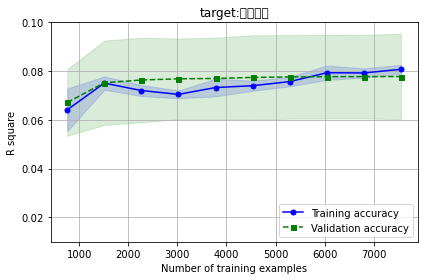

In [34]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.title('target:심부경도')
plt.xlabel('Number of training examples')
plt.ylabel('R square')
plt.legend(loc='lower right')
plt.ylim([0.01, 0.1])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

examine overfitting and underfitting using validation curve

In [85]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='alpha', 
                param_range=np.logspace(-7, 3, 3),
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()


ValueError: Invalid parameter alpha for estimator Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression(normalize=True))]). Check the list of available parameters with `estimator.get_params().keys()`.

#경화깊이

In [35]:
X=df1.iloc[:,1:5].values
y=df1.iloc[:,9].values

In [36]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              stratify=y,random_state=101)

In [37]:
train_sizes,train_scores,test_scores=learning_curve(estimator=pipe_lr,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)


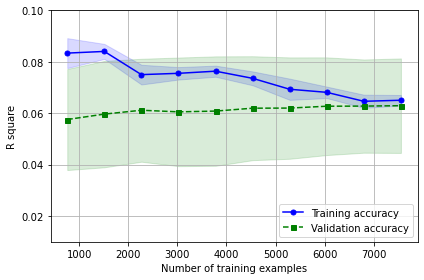

In [38]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('R square')
plt.legend(loc='lower right')
plt.ylim([0.01, 0.1])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

reference: https://scikit-learn.org/stable/modules/learning_curve.html

GridSearchCV and RandomizedSearchCV

reference: https://blog.naver.com/PostView.naver?blogId=dalgoon02121&logNo=222103377185&redirect=Dlog&widgetTypeCall=true&directAccess=false

Scikit-Learn Linearregression And Randomizedsearchcv And Their N_Jobs Parameter Relation


https://www.adoclib.com/blog/scikitlearn-linearregression-and-randomizedsearchcv-and-their-n-jobs-parameter-relation.html

In [32]:
from sklearn.linear_model import Ridge,Lasso,ElasticNet,RidgeCV


RidgeCV regression

In [48]:
#심부경도
X=df1.iloc[:,1:5].values
y=df1.iloc[:,8].values

In [49]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              stratify=y,random_state=101)

In [67]:
from sklearn import linear_model

coefs = []
intercepts=[]
alphas=[1e-3, 1e-2, 1e-1, 1]
for k in alphas:
    ridge=linear_model.Ridge(alpha=k,fit_intercept=True)
#ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train,y_train)
    ridge.fit(X_train,y_train)
    print('regularized lambda:',k)
    print('coefficient of determination: %.3f'% ridge.score(X_train,y_train))
    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)
    coefs.append(ridge.coef_)
    intercepts.append(ridge.intercept_)
#print('coefficients %.3f' %  ridge.coef_)
print('coefficients :') 
print(coefs)
print('intercept %.3f:') 
print(intercepts)


regularized lambda: 0.001
coefficient of determination: 0.081
regularized lambda: 0.01
coefficient of determination: 0.081
regularized lambda: 0.1
coefficient of determination: 0.081
regularized lambda: 1
coefficient of determination: 0.081
coefficients :
[array([-0.01752209,  0.3744611 ,  0.70280663,  8.25230622]), array([-0.01752209,  0.37446093,  0.70280647,  8.25230514]), array([-0.01752208,  0.37445925,  0.70280485,  8.25229431]), array([-0.01752199,  0.37444242,  0.70278865,  8.25218608])]
intercept %.3f:
[-248.65962740758914, -248.65957779759037, -248.65908169829265, -248.65412077444745]


=>2번째 계수가 양수로 바뀌었다.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html

https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html

In [ ]:
#심부경도
X=df1.iloc[:,1:5].values
y=df1.iloc[:,8].values

Scaling

In [70]:
scr=StandardScaler()

In [71]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [76]:
X_train_std=scr.fit_transform(X_train)
X_test_std=scr.fit_transform(X_test)
#y_train_std=scr.fit_transform(y_train)
#y_test_std=scr.fit_transform(y_test)

In [77]:
from sklearn import linear_model

coefs = []
intercepts=[]
alphas=[1e-3, 1e-2, 1e-1, 1]
for k in alphas:
    ridge=linear_model.Ridge(alpha=k,fit_intercept=True)
#ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train,y_train)
    ridge.fit(X_train_std,y_train)
    print('regularized lambda:',k)
    print('coefficient of determination: %.3f'% ridge.score(X_train_std,y_train))
    y_train_pred = ridge.predict(X_train_std)
    y_test_pred = ridge.predict(X_test_std)
    coefs.append(ridge.coef_)
    intercepts.append(ridge.intercept_)
#print('coefficients %.3f' %  ridge.coef_)
print('coefficients :') 
print(coefs)
print('intercept %.3f:') 
print(intercepts)


regularized lambda: 0.001
coefficient of determination: 0.081
regularized lambda: 0.01
coefficient of determination: 0.081
regularized lambda: 0.1
coefficient of determination: 0.081
regularized lambda: 1
coefficient of determination: 0.081
coefficients :
[array([-1.03857615,  0.53137307,  1.50210923, 23.56653265]), array([-1.03857475,  0.5313726 ,  1.50210802, 23.56650738]), array([-1.03856077,  0.53136794,  1.50209593, 23.56625469]), array([-1.03842096,  0.53132133,  1.50197499, 23.56372811])]
intercept %.3f:
[113.81227965697668, 113.81227965697668, 113.81227965697668, 113.81227965697668]


=> coefficients are change a bit. intercept decreases from -248 to 113

=>R square does not change a lot

Note:소재에 따라 열처리방식이 달라짐

In [127]:
df1.groupby(['재질','열처리'])[['품명','품번']].describe()

품명                                     품번         \
              count unique                 top  freq count unique   
재질       열처리                                                        
SCM420H  침탄    6875      6  GEAR-O/P 12.8 (신도)  2238  6875      5   
         침탄질화  2995      1  GEAR-OIL PUMP 15.6  2995  2995      1   
SCR420HB 침탄     625      1               신경형     625   625      1   

                                  
                       top  freq  
재질       열처리                      
SCM420H  침탄    OP131-HD100  3664  
         침탄질화  OP131-HD500  2995  
SCR420HB 침탄    45753-02400   625

In [130]:
df1.groupby(['품번'])[['열처리','재질']].describe()

열처리                       재질                       
            count unique   top  freq count unique       top  freq
품번                                                               
45753-02400   625      1    침탄   625   625      1  SCR420HB   625
BM840-TF000   421      1    침탄   421   421      1   SCM420H   421
BM844 TH051  1452      1    침탄  1452  1452      1   SCM420H  1452
GC04400710    722      1    침탄   722   722      1   SCM420H   722
GC04410210    616      1    침탄   616   616      1   SCM420H   616
OP131-HD100  3664      1    침탄  3664  3664      1   SCM420H  3664
OP131-HD500  2995      1  침탄질화  2995  2995      1   SCM420H  2995

In [136]:
df1.groupby(['품번'])[['열처리','재질','LNG순간유량','RX순간유량']].describe()

LNG순간유량                                                 RX순간유량  \
              count      mean       std  min  25%  50%    75%  max   count   
품번                                                                           
45753-02400   625.0  1.540640  1.545230  0.0  0.1  1.5  2.100  7.0   625.0   
BM840-TF000   421.0  1.751069  1.565971  0.0  0.0  1.9  2.700  7.3   421.0   
BM844 TH051  1452.0  1.275826  1.231804  0.0  0.0  1.3  2.100  7.0  1452.0   
GC04400710    722.0  0.913158  1.058238  0.0  0.0  0.7  1.600  6.9   722.0   
GC04410210    616.0  0.786201  0.925952  0.0  0.0  0.7  1.325  6.8   616.0   
OP131-HD100  3664.0  1.645715  1.488668  0.0  0.0  1.7  2.800  7.0  3664.0   
OP131-HD500  2995.0  1.743005  1.435842  0.0  0.1  1.9  2.700  7.2  2995.0   

                                                                
                  mean       std   min   25%   50%   75%   max  
품번                                                              
45753-02400  44.104320  2.447526  39.6  41.2  45.6  46.4  48.0  
BM840-TF000  42.036105  0.583118  39.6  41.6  42.0  42.4  48.4  
BM844 TH051  45.137466  2.326215  40.4  42.4  46.4  47.2  52.8  
GC04400710   46.108033  0.707610  44.4  45.6  46.0  46.4  55.6  
GC04410210   40.516234  0.784067  38.8  40.4  40.4  40.8  57.2  
OP131-HD100  43.474127  2.324466  39.2  41.6  42.4  46.0  54.8  
OP131-HD500  47.875927  0.992230  46.0  47.2  47.6  48.4  59.2

In [135]:
df1.groupby(['품번'])[['열처리','재질','가열로히터온도','CP농도']].describe()

가열로히터온도                                                            \
              count        mean        std    min    25%    50%    75%    max   
품번                                                                              
45753-02400   625.0  877.254400  47.050650  730.0  852.0  908.0  909.0  914.0   
BM840-TF000   421.0  865.923990  63.738483  663.0  848.0  906.0  909.0  916.0   
BM844 TH051  1452.0  872.678375  58.034489  678.0  853.0  908.0  909.0  914.0   
GC04400710    722.0  899.588643  62.477167  639.0  899.5  927.0  929.0  935.0   
GC04410210    616.0  901.680195  53.633990  668.0  889.0  929.0  929.0  937.0   
OP131-HD100  3664.0  879.958242  61.430123  657.0  852.0  917.0  919.0  927.0   
OP131-HD500  2995.0  886.358598  57.371310  657.0  869.0  917.0  919.0  927.0   

               CP농도                                                   
              count      mean       std  min    25%  50%   75%   max  
품번                                                                    
45753-02400   625.0  8.215840  1.746881  3.4  6.100  9.0  10.0  10.1  
BM840-TF000   421.0  8.928029  2.460541  3.8  7.300  8.7  10.0  16.6  
BM844 TH051  1452.0  8.934986  2.173546  3.4  8.075  9.0  10.0  16.6  
GC04400710    722.0  8.983795  2.100175  3.4  8.300  8.7  10.0  16.6  
GC04410210    616.0  8.893344  1.863428  3.9  8.300  8.6  10.0  16.6  
OP131-HD100  3664.0  8.951692  2.269189  3.4  7.100  9.1  10.0  16.6  
OP131-HD500  2995.0  8.974391  2.066806  3.3  7.900  9.2  10.0  16.6

In [131]:
df1.groupby(['품명'])[['열처리','재질']].describe()

열처리                       재질                       
                     count unique   top  freq count unique       top  freq
품명                                                                        
GEAR DRIVEN RH (BSA)   421      1    침탄   421   421      1   SCM420H   421
GEAR INPUT            1452      1    침탄  1452  1452      1   SCM420H  1452
GEAR-O/P 12.8 (성진)    1426      1    침탄  1426  1426      1   SCM420H  1426
GEAR-O/P 12.8 (신도)    2238      1    침탄  2238  2238      1   SCM420H  2238
GEAR-OIL PUMP 15.6    2995      1  침탄질화  2995  2995      1   SCM420H  2995
W/SHAFT M TRK          722      1    침탄   722   722      1   SCM420H   722
W/SHAFT PY LH          616      1    침탄   616   616      1   SCM420H   616
신경형                    625      1    침탄   625   625      1  SCR420HB   625

=>성진과 신도는 동일한 제품을 주문.따라서 품번을 기준으로

regression :time,4 features with stage

In [49]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10495 entries, 0 to 10494
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   measuredt     10495 non-null  datetime64[ns]
 1   가열로히터온도       10495 non-null  int64         
 2   LNG순간유량       10495 non-null  float64       
 3   CP농도          10495 non-null  float64       
 4   RX순간유량        10495 non-null  float64       
 5   시작일           10495 non-null  datetime64[ns]
 6   열처리           10495 non-null  object        
 7   표면경도          10495 non-null  float64       
 8   심부경도          10495 non-null  float64       
 9   경화깊이          10495 non-null  float64       
 10  재질            10495 non-null  object        
 11  수량_set        10495 non-null  int64         
 12  규격            10495 non-null  object        
 13  품번            10495 non-null  object        
 14  품명            10495 non-null  object        
 15  거래처           10495 non-null  object

In [83]:
df1.groupby('열처리')[['공정시간_set','공정시간_step']].describe()

공정시간_set                                                             \
        count        mean         std    min    25%    50%    75%    max   
열처리                                                                        
침탄     7500.0  624.883067  105.459726  366.0  557.0  646.0  720.0  752.0   
침탄질화   2995.0  675.071119   27.611472  643.0  643.0  684.0  704.0  704.0   

     공정시간_step                                                            
         count        mean         std   min    25%    50%    75%    max  
열처리                                                                       
침탄      7500.0  263.492533  133.704696  85.0  137.0  214.0  370.0  504.0  
침탄질화    2995.0  302.158264  131.013034  80.0  176.0  405.0  410.0  410.0

In [84]:
df1.groupby('step')[['공정시간_set','공정시간_step']].describe()

공정시간_set                                                             \
        count        mean         std    min    25%    50%    75%    max   
step                                                                       
1승온    2549.0  629.348764   92.905767  366.0  596.0  643.0  704.0  752.0   
2침탄    5935.0  644.315586   89.851219  366.0  634.0  653.0  704.0  752.0   
3강온    2011.0  636.617603  101.628523  366.0  596.0  653.0  720.0  752.0   

     공정시간_step                                                            
         count        mean        std    min    25%    50%    75%    max  
step                                                                      
1승온     2549.0  154.287564  24.291598   85.0  151.0  159.0  174.0  183.0  
2침탄     5935.0  378.115249  79.584554  168.0  362.0  373.0  410.0  504.0  
3강온     2011.0  121.215813  29.561676   80.0  103.0  117.0  129.0  181.0

In [80]:
pd.pivot_table(df1,index=['열처리'], values=['공정시간_set','공정시간_step'])

,공정시간_set,공정시간_step
열처리,,
침탄,624.883067,263.492533
침탄질화,675.071119,302.158264


In [85]:
df1.groupby('품번')[['공정시간_set','공정시간_step']].describe()

공정시간_set                                                     \
               count        mean        std    min    25%    50%    75%   
품번                                                                        
45753-02400    625.0  366.864000   0.991502  366.0  366.0  366.0  368.0   
BM840-TF000    421.0  475.000000   0.000000  475.0  475.0  475.0  475.0   
BM844 TH051   1452.0  571.692149  18.904515  557.0  557.0  557.0  596.0   
GC04400710     722.0  752.000000   0.000000  752.0  752.0  752.0  752.0   
GC04410210     616.0  728.000000   0.000000  728.0  728.0  728.0  728.0   
OP131-HD100   3664.0  664.811408  31.568215  634.0  642.0  653.0  664.0   
OP131-HD500   2995.0  675.071119  27.611472  643.0  643.0  684.0  704.0   

                   공정시간_step                                               \
               max     count        mean         std    min    25%    50%   
품번                                                                          
45753-02400  368.0     625.0  134.600000   36.241710   85.0  103.0  168.0   
BM840-TF000  475.0     421.0  172.760095   44.765919   93.0  166.0  166.0   
BM844 TH051  596.0    1452.0  227.391185   93.941166   93.0  137.0  298.0   
GC04400710   752.0     722.0  375.354571  176.765512  124.0  126.0  500.0   
GC04410210   728.0     616.0  379.975649  182.495023   99.0  122.0  504.0   
OP131-HD100  720.0    3664.0  268.584607  108.790827  103.0  159.0  362.0   
OP131-HD500  704.0    2995.0  302.158264  131.013034   80.0  176.0  405.0   

                           
               75%    max  
품번                         
45753-02400  171.0  171.0  
BM840-TF000  214.0  214.0  
BM844 TH051  325.0  325.0  
GC04400710   500.0  500.0  
GC04410210   504.0  504.0  
OP131-HD100  370.0  373.0  
OP131-HD500  410.0  410.0

In [86]:
df1.groupby('재질')[['공정시간_set','공정시간_step']].describe()

공정시간_set                                                            \
            count        mean        std    min    25%    50%    75%    max   
재질                                                                            
SCM420H    9870.0  656.450963  65.067781  475.0  642.0  653.0  704.0  752.0   
SCR420HB    625.0  366.864000   0.991502  366.0  366.0  366.0  368.0  368.0   

         공정시간_step                                                            
             count        mean         std   min    25%    50%    75%    max  
재질                                                                            
SCM420H     9870.0  283.387335  133.093255  80.0  156.0  325.0  405.0  504.0  
SCR420HB     625.0  134.600000   36.241710  85.0  103.0  168.0  171.0  171.0

In [88]:
df1.groupby(['열처리','재질','품번'])[['공정시간_set','공정시간_step']].describe()

공정시간_set                                       \
                             count        mean        std    min    25%   
열처리  재질       품번                                                          
침탄   SCM420H  BM840-TF000    421.0  475.000000   0.000000  475.0  475.0   
              BM844 TH051   1452.0  571.692149  18.904515  557.0  557.0   
              GC04400710     722.0  752.000000   0.000000  752.0  752.0   
              GC04410210     616.0  728.000000   0.000000  728.0  728.0   
              OP131-HD100   3664.0  664.811408  31.568215  634.0  642.0   
     SCR420HB 45753-02400    625.0  366.864000   0.991502  366.0  366.0   
침탄질화 SCM420H  OP131-HD500   2995.0  675.071119  27.611472  643.0  643.0   

                                               공정시간_step              \
                             50%    75%    max     count        mean   
열처리  재질       품번                                                       
침탄   SCM420H  BM840-TF000  475.0  475.0  475.0     421.0  172.760095   
              BM844 TH051  557.0  596.0  596.0    1452.0  227.391185   
              GC04400710   752.0  752.0  752.0     722.0  375.354571   
              GC04410210   728.0  728.0  728.0     616.0  379.975649   
              OP131-HD100  653.0  664.0  720.0    3664.0  268.584607   
     SCR420HB 45753-02400  366.0  368.0  368.0     625.0  134.600000   
침탄질화 SCM420H  OP131-HD500  684.0  704.0  704.0    2995.0  302.158264   

                                                                          
                                  std    min    25%    50%    75%    max  
열처리  재질       품번                                                          
침탄   SCM420H  BM840-TF000   44.765919   93.0  166.0  166.0  214.0  214.0  
              BM844 TH051   93.941166   93.0  137.0  298.0  325.0  325.0  
              GC04400710   176.765512  124.0  126.0  500.0  500.0  500.0  
              GC04410210   182.495023   99.0  122.0  504.0  504.0  504.0  
              OP131-HD100  108.790827  103.0  159.0  362.0  370.0  373.0  
     SCR420HB 45753-02400   36.241710   85.0  103.0  168.0  171.0  171.0  
침탄질화 SCM420H  OP131-HD500  131.013034   80.0  176.0  405.0  410.0  410.0

In [71]:
 df2=pd.get_dummies(df1, columns = ['열처리','step','재질','품번'], drop_first=True) 

In [72]:
df2.columns

Index(['measuredt', '가열로히터온도', 'LNG순간유량', 'CP농도', 'RX순간유량', '시작일', '표면경도',
       '심부경도', '경화깊이', '수량_set', '규격', '품명', '거래처', 'company', 'id', 'LOTNO',
       'set', '공정시간_set', '공정시간_step', '온도차이_set', '온도합계_set', '온도평균_step',
       '온도차이_step', '온도합계_step', 'LNG유량합계_step', 'LNG유량합계_set', 'CP농도합계_step',
       'CP농도합계_set', 'RX유량합계_step', 'RX유량합계_set', '열처리_침탄질화', 'step_2침탄',
       'step_3강온', '재질_SCR420HB', '품번_BM840-TF000', '품번_BM844 TH051',
       '품번_GC04400710', '품번_GC04410210', '품번_OP131-HD100', '품번_OP131-HD500'],
      dtype='object')

In [73]:
df3=df2[['경화깊이','공정시간_step','가열로히터온도','LNG순간유량','CP농도','RX순간유량','열처리_침탄질화','step_2침탄','step_3강온']]

In [81]:
df3.head()

,경화깊이,공정시간_step,가열로히터온도,LNG순간유량,CP농도,RX순간유량,열처리_침탄질화,step_2침탄,step_3강온
0,1.18,124,639,6.9,3.9,46.0,0,0,0
1,1.18,124,639,6.9,4.6,46.0,0,0,0
2,1.18,124,639,5.1,16.6,46.4,0,0,0
3,1.18,124,639,0.0,16.6,46.0,0,0,0
4,1.18,124,639,0.0,16.6,46.0,0,0,0


In [82]:
#경화깊이
X=df3.iloc[:,1:].values
y=df3.iloc[:,0].values

In [83]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [84]:
import statsmodels.api as sm

lm = LinearRegression(fit_intercept=True, normalize=True, n_jobs=None) 
lm.fit(X_train, y_train) 
accuracy = lm.score(X_train, y_train) 
print("lm.coef_:",lm.coef_) 
print("lm.intercept_:",lm.intercept_)
y_train_pred=lm.predict(X_train)
y_test_pred = lm.predict(X_test)

print('train MSE: %.3f, test MSE %.3f' %(
mean_squared_error(y_train,y_train_pred),
mean_squared_error(y_test,y_test_pred),
     
))
adj_R_train=1 - (1-lm.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
adj_R_test=1 - (1-lm.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("train r_square: %.3f, test r_square: %.3f" % (r2_score(y_train,y_train_pred), r2_score(y_test,y_test_pred))) 
print('adjusted R-square in train dataset: %.3f'% adj_R_train)
print('adjusted R-square in test dataset: %.3f' % adj_R_test)


lm.coef_: [ 0.00111275  0.00042229 -0.01836603  0.0036529   0.00704723 -0.06187539
 -0.25374662  0.01222259]
lm.intercept_: -0.11694531831026378
train MSE: 0.019, test MSE 0.019
train r_square: 0.256, test r_square: 0.249
adjusted R-square in train dataset: 0.256
adjusted R-square in test dataset: 0.247


In [ ]:
from sklearn import linear_model

coefs = []
intercepts=[]
alphas=[1e-3, 1e-2, 1e-1, 1]
for k in alphas:
    ridge=linear_model.Ridge(alpha=k,fit_intercept=True)
#ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train,y_train)
    ridge.fit(X_train_std,y_train)
    print('regularized lambda:',k)
    print('coefficient of determination: %.3f'% ridge.score(X_train_std,y_train))
    y_train_pred = ridge.predict(X_train_std)
    y_test_pred = ridge.predict(X_test_std)
    coefs.append(ridge.coef_)
    intercepts.append(ridge.intercept_)
#print('coefficients %.3f' %  ridge.coef_)
print('coefficients :') 
print(coefs)
print('intercept %.3f:') 
print(intercepts)


In [85]:
train_sizes,train_scores,test_scores=learning_curve(estimator=pipe_lr,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)


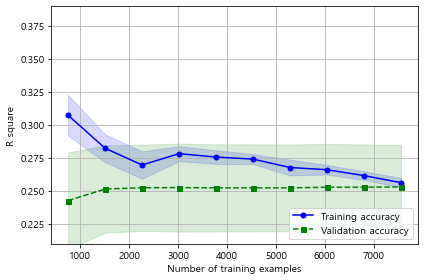

In [86]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('R square')
plt.legend(loc='lower right')
plt.ylim([0.21, 0.39])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

열처리와 품번

In [74]:
df4=df2[['경화깊이','공정시간_step','가열로히터온도','LNG순간유량','CP농도','RX순간유량','열처리_침탄질화','품번_BM840-TF000', '품번_BM844 TH051',
       '품번_GC04400710', '품번_GC04410210', '품번_OP131-HD100', '품번_OP131-HD500','step_2침탄','step_3강온']]

In [423]:
df4.head()

,경화깊이,공정시간_step,가열로히터온도,LNG순간유량,CP농도,RX순간유량,열처리_침탄질화,품번_BM840-TF000,품번_BM844 TH051,품번_GC04400710,품번_GC04410210,품번_OP131-HD100,품번_OP131-HD500,step_2침탄,step_3강온
0,1.18,124,639,6.9,3.9,46.0,0,0,0,1,0,0,0,0,0
1,1.18,124,639,6.9,4.6,46.0,0,0,0,1,0,0,0,0,0
2,1.18,124,639,5.1,16.6,46.4,0,0,0,1,0,0,0,0,0
3,1.18,124,639,0.0,16.6,46.0,0,0,0,1,0,0,0,0,0
4,1.18,124,639,0.0,16.6,46.0,0,0,0,1,0,0,0,0,0


In [103]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10495 entries, 0 to 10494
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   경화깊이            10495 non-null  float64
 1   공정시간_step       10495 non-null  int32  
 2   가열로히터온도         10495 non-null  int64  
 3   LNG순간유량         10495 non-null  float64
 4   CP농도            10495 non-null  float64
 5   RX순간유량          10495 non-null  float64
 6   열처리_침탄질화        10495 non-null  uint8  
 7   품번_BM840-TF000  10495 non-null  uint8  
 8   품번_BM844 TH051  10495 non-null  uint8  
 9   품번_GC04400710   10495 non-null  uint8  
 10  품번_GC04410210   10495 non-null  uint8  
 11  품번_OP131-HD100  10495 non-null  uint8  
 12  품번_OP131-HD500  10495 non-null  uint8  
 13  step_2침탄        10495 non-null  uint8  
 14  step_3강온        10495 non-null  uint8  
dtypes: float64(4), int32(1), int64(1), uint8(9)
memory usage: 625.2 KB


In [102]:
df4.to_excel('df4.xlsx')

In [75]:
#경화깊이
X=df4.iloc[:,1:].values
y=df4.iloc[:,0].values

In [76]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [336]:
import statsmodels.api as sm

lm = LinearRegression(fit_intercept=True, normalize=True, n_jobs=None) 
lm.fit(X_train, y_train) 
accuracy = lm.score(X_train, y_train) 
print("lm.coef_:",lm.coef_) 
print("lm.intercept_:",lm.intercept_)
y_train_pred=lm.predict(X_train)
y_test_pred = lm.predict(X_test)

print('train MSE: %.3f, test MSE %.3f' %(
mean_squared_error(y_train,y_train_pred),
mean_squared_error(y_test,y_test_pred),
     
))
adj_R_train=1 - (1-lm.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
adj_R_test=1 - (1-lm.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("train r_square: %.3f, test r_square: %.3f" % (r2_score(y_train,y_train_pred), r2_score(y_test,y_test_pred))) 
print('adjusted R-square in train dataset: %.3f'% adj_R_train)
print('adjusted R-square in test dataset: %.3f' % adj_R_test)


lm.coef_: [ 1.69178789e-05  3.55207580e-05 -1.53836075e-03  4.62632348e-04
 -5.16834600e-03 -7.79712942e+11  4.80210359e-02  1.79903728e-01
  5.94543916e-01  3.45130750e-01  1.50918113e-02  7.79712942e+11
 -5.49872447e-03  3.16049433e-03]
lm.intercept_: 0.7859511964958518
train MSE: 0.002, test MSE 0.001
train r_square: 0.939, test r_square: 0.941
adjusted R-square in train dataset: 0.939
adjusted R-square in test dataset: 0.941


In [158]:
train_sizes,train_scores,test_scores=learning_curve(estimator=pipe_lr,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)


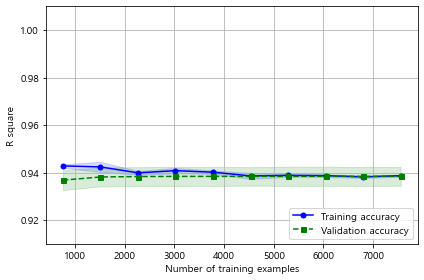

In [161]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('R square')
plt.legend(loc='lower right')
plt.ylim([0.91, 1.01])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

=>2000개만 되도 훈련 데이터셋과 검증 데이터셋의 결정계수가 수렴한다.

Regression with scaling

In [78]:
scr=StandardScaler()

In [338]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=101)

In [298]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,504.00,927.00,0.00,8.60,40.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
1,410.00,919.00,3.10,10.00,50.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
2,373.00,917.00,2.90,10.00,42.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
3,410.00,917.00,1.40,9.90,47.60,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
4,176.00,922.00,2.80,6.00,47.20,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [79]:
X_train_std=scr.fit_transform(X_train)
X_test_std=scr.fit_transform(X_test)
#y_train=y_train_std.reshape(-1,1)
#y_test=y_test_std.reshape(-1,1)
#y_train_std=scr.fit_transform(y_train)
#y_test_std=scr.fit_transform(y_test)

In [493]:
df4_44.columns=[['경화깊이','공정시간_step','가열로히터온도','LNG순간유량','CP농도','RX순간유량','열처리_침탄질화','품번_BM840-TF000', '품번_BM844 TH051',
       '품번_GC04400710', '품번_GC04410210', '품번_OP131-HD100', '품번_OP131-HD500','step_2침탄','step_3강온']]

In [494]:
pd.DataFrame(X_train_std).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.709802,0.747813,-1.067708,-0.152908,-1.739959,-0.639501,-0.202587,-0.399786,-0.271904,4.074516,-0.729080,-0.639501,0.875903,-0.489892
1,1.009836,0.612843,1.116876,0.502124,1.761747,1.563720,-0.202587,-0.399786,-0.271904,-0.245428,-0.729080,1.563720,0.875903,-0.489892
2,0.734318,0.579101,0.975935,0.502124,-1.039618,-0.639501,-0.202587,-0.399786,-0.271904,-0.245428,1.371591,-0.639501,0.875903,-0.489892
3,1.009836,0.579101,-0.081122,0.455336,0.921337,1.563720,-0.202587,-0.399786,-0.271904,-0.245428,-0.729080,1.563720,0.875903,-0.489892
4,-0.732633,0.663457,0.905465,-1.369395,0.781269,1.563720,-0.202587,-0.399786,-0.271904,-0.245428,-0.729080,1.563720,-1.141678,-0.489892


In [427]:
import statsmodels.api as sm

lm = LinearRegression(fit_intercept=True, normalize=True, n_jobs=None) 
lm.fit(X_train_std, y_train_std) 

accuracy = lm.score(X_train_std, y_train_std) 
print("lm.coef_:",lm.coef_) 
print("lm.intercept_:",lm.intercept_)
y_train_pred=lm.predict(X_train_std)
y_test_pred = lm.predict(X_test_std)

print('train MSE: %.3f, test MSE %.3f' %(
mean_squared_error(y_train,y_train_pred),
mean_squared_error(y_test,y_test_pred),
     
))
adj_R_train=1 - (1-lm.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
adj_R_test=1 - (1-lm.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("train r_square: %.3f, test r_square: %.3f" % (r2_score(y_train,y_train_pred), r2_score(y_test,y_test_pred))) 
print('adjusted R-square in train dataset: %.3f'% adj_R_train)
print('adjusted R-square in test dataset: %.3f' % adj_R_test)


lm.coef_: [[ 0.01552289  0.01191841 -0.01335027  0.00559583 -0.09307714  0.20897457
   0.05879254  0.39166016  0.95071526  0.50469374  0.04490606  0.20897457
  -0.01601076  0.00796216]]
lm.intercept_: [1.1180595e-14]
train MSE: 1.190, test MSE 1.188
train r_square: -46.558, test r_square: -45.473
adjusted R-square in train dataset: -4412.053
adjusted R-square in test dataset: -4350.914


=>coefficient of determination of model after scaling gets worse than one prior to scaling

Ridge Regression with scaling

In [80]:
from sklearn import linear_model

ridge=linear_model.Ridge(fit_intercept=True)
ridge.fit(X_train_std,y_train)
print('coefficient of determination: %.3f'% ridge.score(X_train_std,y_train))
y_train_pred = ridge.predict(X_train_std)
y_test_pred = ridge.predict(X_test_std)
print('coefficients :') 
print(ridge.coef_)
print('intercept:') 
print(ridge.intercept_)
#print('coefficient of determination in test dataset: %.3f' % ridge.score(y_test_std,y_test_pred))

coefficient of determination: 0.939
coefficients :
[ 0.00260818  0.00189232 -0.00211307  0.00089303 -0.01471883  0.03297537
  0.00925186  0.06185356  0.15028287  0.07973833  0.00694163  0.03297537
 -0.00265855  0.00127161]
intercept:
0.723630300142927


## save estimator

In [92]:
!pip install joblib

In [94]:
!pip install externals

ERROR: Could not find a version that satisfies the requirement externals (from versions: none)
ERROR: No matching distribution found for externals


In [99]:
import pickle
import joblib

save model : save as pickle type

In [100]:
ridge_reg=pickle.dumps(ridge)

save model as file type : use this command

In [101]:
joblib.dump(ridge,'ridge.pkl')

['ridge.pkl']

In [207]:
pipe_ridge=make_pipeline(StandardScaler(),
                     linear_model.Ridge(fit_intercept=True))

In [213]:
train_sizes,train_scores,test_scores=learning_curve(estimator=linear_model.Ridge(fit_intercept=True),X=X_train_std,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)


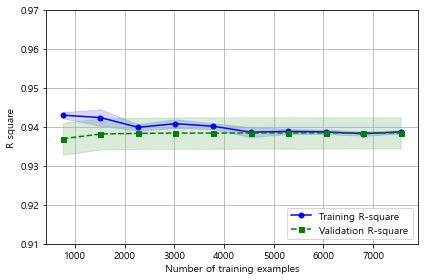

In [214]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training R-square')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation R-square')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('R square')
plt.legend(loc='lower right')
plt.ylim([0.91, 0.97])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

In [93]:
!pip install yellowbrick

  Using cached yellowbrick-1.3.post1-py3-none-any.whl (271 kB)


In [222]:
from yellowbrick.features import(FeatureImportances,)

심부경도

In [223]:
df4_2=df2[['심부경도','공정시간_step','가열로히터온도','LNG순간유량','CP농도','RX순간유량','열처리_침탄질화','품번_BM840-TF000', '품번_BM844 TH051',
       '품번_GC04400710', '품번_GC04410210', '품번_OP131-HD100', '품번_OP131-HD500','step_2침탄','step_3강온']]

In [430]:
df4_2.head()

,심부경도,공정시간_step,가열로히터온도,LNG순간유량,CP농도,RX순간유량,열처리_침탄질화,품번_BM840-TF000,품번_BM844 TH051,품번_GC04400710,품번_GC04410210,품번_OP131-HD100,품번_OP131-HD500,step_2침탄,step_3강온
0,60.3,124,639,6.9,3.9,46.0,0,0,0,1,0,0,0,0,0
1,60.3,124,639,6.9,4.6,46.0,0,0,0,1,0,0,0,0,0
2,60.3,124,639,5.1,16.6,46.4,0,0,0,1,0,0,0,0,0
3,60.3,124,639,0.0,16.6,46.0,0,0,0,1,0,0,0,0,0
4,60.3,124,639,0.0,16.6,46.0,0,0,0,1,0,0,0,0,0


In [224]:
df4_2.columns

Index(['심부경도', '공정시간_step', '가열로히터온도', 'LNG순간유량', 'CP농도', 'RX순간유량', '열처리_침탄질화',
       '품번_BM840-TF000', '품번_BM844 TH051', '품번_GC04400710', '품번_GC04410210',
       '품번_OP131-HD100', '품번_OP131-HD500', 'step_2침탄', 'step_3강온'],
      dtype='object')

In [ ]:
df_or = df[(df['age'] < 20) | (df['point'] > 90)]

In [270]:
surfice_outlier=df4_2[(df4_2['심부경도']>100) & (df4_2['품번_OP131-HD100'] ==1)]

In [271]:
surfice_outlier

,심부경도,공정시간_step,가열로히터온도,LNG순간유량,CP농도,RX순간유량,열처리_침탄질화,품번_BM840-TF000,품번_BM844 TH051,품번_GC04400710,품번_GC04410210,품번_OP131-HD100,품번_OP131-HD500,step_2침탄,step_3강온
9860,197.20,160,660,6.70,16.60,42.40,0,0,0,0,0,1,0,0,0
9861,197.20,160,660,0.00,16.60,42.00,0,0,0,0,0,1,0,0,0
9862,197.20,160,660,0.00,16.60,42.00,0,0,0,0,0,1,0,0,0
9863,197.20,160,660,0.00,16.60,41.60,0,0,0,0,0,1,0,0,0
9864,197.20,160,660,0.00,16.60,41.60,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10490,197.20,118,870,0.10,6.50,41.60,0,0,0,0,0,1,0,0,1
10491,197.20,118,847,0.00,6.50,41.20,0,0,0,0,0,1,0,0,1
10492,197.20,118,780,0.00,3.80,41.60,0,0,0,0,0,1,0,0,1
10493,197.20,118,693,0.00,4.70,41.60,0,0,0,0,0,1,0,0,1


In [232]:
df1.groupby(['품번','열처리','step'])['심부경도'].describe()

count     mean     std      min      25%      50%  \
품번          열처리  step                                                         
45753-02400 침탄   1승온   150.0000  40.2567  0.2507  40.0000  40.0000  40.5000   
                 2침탄   318.0000  40.2673  0.2498  40.0000  40.0000  40.5000   
                 3강온   157.0000  40.3439  0.2324  40.0000  40.0000  40.5000   
BM840-TF000 침탄   1승온   155.0000  39.2000  0.0000  39.2000  39.2000  39.2000   
                 2침탄   184.0000  39.2000  0.0000  39.2000  39.2000  39.2000   
                 3강온    82.0000  39.2000  0.0000  39.2000  39.2000  39.2000   
BM844 TH051 침탄   1승온   403.0000 222.2303  2.6026 218.8000 218.8000 224.2000   
                 2침탄   758.0000 222.2480  2.5960 218.8000 218.8000 224.2000   
                 3강온   291.0000 221.8619  2.6803 218.8000 218.8000 224.2000   
GC04400710  침탄   1승온   117.0000  60.3000  0.0000  60.3000  60.3000  60.3000   
                 2침탄   482.0000  60.3000  0.0000  60.3000  60.3000  60.3000   
                 3강온   123.0000  60.3000  0.0000  60.3000  60.3000  60.3000   
GC04410210  침탄   1승온    83.0000  60.2000  0.0000  60.2000  60.2000  60.2000   
                 2침탄   421.0000  60.2000  0.0000  60.2000  60.2000  60.2000   
                 3강온   112.0000  60.2000  0.0000  60.2000  60.2000  60.2000   
OP131-HD100 침탄   1승온   855.0000  65.5409 61.9980  34.5000  36.0000  37.5000   
                 2침탄  1981.0000  65.8572 62.2356  34.5000  36.0000  37.5000   
                 3강온   828.0000  59.3634 55.9571  34.5000  36.0000  37.5000   
OP131-HD500 침탄질화 1승온   786.0000 166.1359 70.2511  32.5000 202.3000 202.3000   
                 2침탄  1791.0000 168.1523 68.8885  32.5000 202.3000 202.3000   
                 3강온   418.0000 175.2368 62.9944  32.5000 202.3000 202.3000   

                           75%      max  
품번          열처리  step                    
45753-02400 침탄   1승온   40.5000  40.5000  
                 2침탄   40.5000  40.5000  
                 3강온   40.5000  40.5000  
BM840-TF000 침탄   1승온   39.2000  39.2000  
                 2침탄   39.2000  39.2000  
                 3강온   39.2000  39.2000  
BM844 TH051 침탄   1승온  224.2000 224.2000  
                 2침탄  224.2000 224.2000  
                 3강온  224.2000 224.2000  
GC04400710  침탄   1승온   60.3000  60.3000  
                 2침탄   60.3000  60.3000  
                 3강온   60.3000  60.3000  
GC04410210  침탄   1승온   60.2000  60.2000  
                 2침탄   60.2000  60.2000  
                 3강온   60.2000  60.2000  
OP131-HD100 침탄   1승온   37.5000 197.2000  
                 2침탄   37.5000 197.2000  
                 3강온   37.5000 197.2000  
OP131-HD500 침탄질화 1승온  203.8000 203.8000  
                 2침탄  203.8000 203.8000  
                 3강온  203.8000 203.8000

In [288]:
X=df4_2.iloc[:,1:].values
y=df4_2.iloc[:,0].values

In [289]:
scr=StandardScaler()

In [290]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [291]:
X_train_std=scr.fit_transform(X_train)
X_test_std=scr.fit_transform(X_test)
#y_train=y_train.reshape(-1,1)
#y_test=y_test.reshape(-1,1)
#y_train_std=scr.fit_transform(y_train)
#y_test_std=scr.fit_transform(y_test)

In [292]:
from sklearn import linear_model

inside_ridge=linear_model.Ridge(fit_intercept=True)
inside_ridge.fit(X_train_std,y_train)
print('coefficient of determination: %.3f'% ridge.score(X_train_std,y_train))
y_train_pred = inside_ridge.predict(X_train_std)
y_test_pred = inside_ridge.predict(X_test_std)
print('coefficients :' ) 
print(inside_ridge.coef_)
print('intercept :' ) 
print(inside_ridge.intercept_)


coefficient of determination: -10.581
coefficients :
[ -1.18945923   0.92364015  -1.79993116   0.48583296 -25.15758876
  37.0285519   -3.58114808  66.15105076   9.71784765  -2.59859696
   9.96553113  37.0285519    1.16709808  -0.37391651]
intercept :
113.81227965698258


=>not economic coefficients

표면경도

In [275]:
df4_3=df2[['표면경도','공정시간_step','가열로히터온도','LNG순간유량','CP농도','RX순간유량','열처리_침탄질화','품번_BM840-TF000', '품번_BM844 TH051',
       '품번_GC04400710', '품번_GC04410210', '품번_OP131-HD100', '품번_OP131-HD500','step_2침탄','step_3강온']]

In [276]:
X=df4_3.iloc[:,1:].values
y=df4_3.iloc[:,0].values

In [277]:
scr=StandardScaler()

In [278]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [279]:
X_train_std=scr.fit_transform(X_train)
X_test_std=scr.fit_transform(X_test)
#y_train=y_train.reshape(-1,1)
#y_test=y_test.reshape(-1,1)
#y_train_std=scr.fit_transform(y_train)
#y_test_std=scr.fit_transform(y_test)

In [280]:
from sklearn import linear_model


surface_ridge=linear_model.Ridge(fit_intercept=True)
surface_ridge.fit(X_train_std,y_train)
print('coefficient of determination: %.3f'% ridge.score(X_train_std,y_train))
y_train_pred = surface_ridge.predict(X_train_std)
y_test_pred = surface_ridge.predict(X_test_std)
print('coefficients :' ) 
print(surface_ridge.coef_)
print('intercept :' ) 
print(surface_ridge.intercept_)

coefficient of determination: 1.000
coefficients :
[-4.41476948e-01  2.44650504e-02 -1.45188588e-02  8.62307788e-03
  9.50495682e-02 -1.41909557e+02 -1.21571331e+02 -2.15100737e+02
 -2.86876385e+00 -9.15033417e+00 -2.97999179e+02 -1.41909557e+02
  3.18988271e-01 -8.78746460e-02]
intercept :
171.72771557884676


=>not economic coefficients

In [233]:
df1.groupby(['품번','열처리','step'])['표면경도'].describe()

count     mean    std      min      25%      50%  \
품번          열처리  step                                                        
45753-02400 침탄   1승온   150.0000 685.1080 0.3009 684.8000 684.8000 685.4000   
                 2침탄   318.0000 685.1208 0.2998 684.8000 684.8000 685.4000   
                 3강온   157.0000 685.2127 0.2789 684.8000 684.8000 685.4000   
BM840-TF000 침탄   1승온   155.0000  59.5000 0.0000  59.5000  59.5000  59.5000   
                 2침탄   184.0000  59.5000 0.0000  59.5000  59.5000  59.5000   
                 3강온    82.0000  59.5000 0.0000  59.5000  59.5000  59.5000   
BM844 TH051 침탄   1승온   403.0000  60.1811 0.2892  59.8000  59.8000  60.4000   
                 2침탄   758.0000  60.1831 0.2884  59.8000  59.8000  60.4000   
                 3강온   291.0000  60.1402 0.2978  59.8000  59.8000  60.4000   
GC04400710  침탄   1승온   117.0000 672.6000 0.0000 672.6000 672.6000 672.6000   
                 2침탄   482.0000 672.6000 0.0000 672.6000 672.6000 672.6000   
                 3강온   123.0000 672.6000 0.0000 672.6000 672.6000 672.6000   
GC04410210  침탄   1승온    83.0000 644.2000 0.0000 644.2000 644.2000 644.2000   
                 2침탄   421.0000 644.2000 0.0000 644.2000 644.2000 644.2000   
                 3강온   112.0000 644.2000 0.0000 644.2000 644.2000 644.2000   
OP131-HD100 침탄   1승온   855.0000  58.0950 0.7939  57.2000  57.4000  58.4000   
                 2침탄  1981.0000  58.0838 0.7989  57.2000  57.4000  58.4000   
                 3강온   828.0000  57.8826 0.7977  57.2000  57.2000  57.4000   
OP131-HD500 침탄질화 1승온   786.0000  58.8527 0.2257  58.6000  58.6000  58.9000   
                 2침탄  1791.0000  58.8322 0.2295  58.6000  58.6000  58.9000   
                 3강온   418.0000  58.8368 0.2106  58.6000  58.6000  58.9000   

                           75%      max  
품번          열처리  step                    
45753-02400 침탄   1승온  685.4000 685.4000  
                 2침탄  685.4000 685.4000  
                 3강온  685.4000 685.4000  
BM840-TF000 침탄   1승온   59.5000  59.5000  
                 2침탄   59.5000  59.5000  
                 3강온   59.5000  59.5000  
BM844 TH051 침탄   1승온   60.4000  60.4000  
                 2침탄   60.4000  60.4000  
                 3강온   60.4000  60.4000  
GC04400710  침탄   1승온  672.6000 672.6000  
                 2침탄  672.6000 672.6000  
                 3강온  672.6000 672.6000  
GC04410210  침탄   1승온  644.2000 644.2000  
                 2침탄  644.2000 644.2000  
                 3강온  644.2000 644.2000  
OP131-HD100 침탄   1승온   58.6000  59.4000  
                 2침탄   58.6000  59.4000  
                 3강온   58.6000  59.4000  
OP131-HD500 침탄질화 1승온   58.9000  59.2000  
                 2침탄   58.9000  59.2000  
                 3강온   58.9000  59.2000

열처리와 재질

In [150]:
df5=df2[['경화깊이','공정시간_step','가열로히터온도','LNG순간유량','CP농도','RX순간유량','재질_SCR420HB','열처리_침탄질화','step_2침탄','step_3강온']]

In [151]:
df5.head()

,경화깊이,공정시간_step,가열로히터온도,LNG순간유량,CP농도,RX순간유량,재질_SCR420HB,열처리_침탄질화,step_2침탄,step_3강온
0,1.18,124,639,6.9,3.9,46.0,0,0,0,0
1,1.18,124,639,6.9,4.6,46.0,0,0,0,0
2,1.18,124,639,5.1,16.6,46.4,0,0,0,0
3,1.18,124,639,0.0,16.6,46.0,0,0,0,0
4,1.18,124,639,0.0,16.6,46.0,0,0,0,0


In [168]:
#경화깊이
X=df5.iloc[:,1:].values
y=df5.iloc[:,0].values

In [169]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [154]:
import statsmodels.api as sm

lm = LinearRegression(fit_intercept=True, normalize=True, n_jobs=None) 
lm.fit(X_train, y_train) 
accuracy = lm.score(X_train, y_train) 
print("lm.coef_:",lm.coef_) 
print("lm.intercept_:",lm.intercept_)
y_train_pred=lm.predict(X_train)
y_test_pred = lm.predict(X_test)

print('train MSE: %.3f, test MSE %.3f' %(
mean_squared_error(y_train,y_train_pred),
mean_squared_error(y_test,y_test_pred),
     
))
adj_R_train=1 - (1-lm.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
adj_R_test=1 - (1-lm.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("train r_square: %.3f, test r_square: %.3f" % (r2_score(y_train,y_train_pred), r2_score(y_test,y_test_pred))) 
print('adjusted R-square in train dataset: %.3f'% adj_R_train)
print('adjusted R-square in test dataset: %.3f' % adj_R_test)


lm.coef_: [ 0.00112073  0.00042257 -0.01832495  0.00369531  0.00703437  0.00417119
 -0.06169816 -0.25561665  0.01243678]
lm.intercept_: -0.11853127487424298
train MSE: 0.019, test MSE 0.019
train r_square: 0.256, test r_square: 0.249
adjusted R-square in train dataset: 0.255
adjusted R-square in test dataset: 0.246


In [170]:
train_sizes,train_scores,test_scores=learning_curve(estimator=pipe_lr,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)


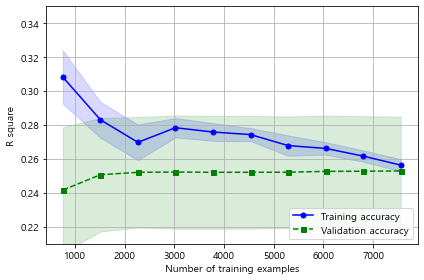

In [173]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('R square')
plt.legend(loc='lower right')
plt.ylim([0.21, 0.35])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

# DecisionTreeRegressor

=>merit: insensitive to scale in nonlinear case 

In [219]:
from sklearn.tree import DecisionTreeRegressor

In [220]:
X=df1.iloc[:,1:5].values
y=df1.iloc[:,9].values

In [227]:
def linear_reg_plot(X,y,model):
    plt.scatter(X,y,c='steelblue',edgecolor='gray',s=77)
    plt.plot(X,model.predict(X),color='b')

In [228]:
tree=DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx=X.flatten().argsort()
linear_reg_plot(X[sort_idx],y[sort_idx],tree)
plt.xlabel('features')
plt.ylable('hardness depth')

IndexError: index 30457 is out of bounds for axis 0 with size 10495

In [226]:
df1.columns

Index(['measuredt_x', '가열로히터온도', 'LNG순간유량', 'CP 농도', 'RX 순간유량', '시작일', '열처리',
       '표면경도', '심부경도', '경화깊이', '재질', '수량', '규격', '품번', '품명', '거래처', 'company',
       'id', 'LOTNO', 'set', 'step', '공정시간_set'],
      dtype='object')

RandomForestRegressor: with 4 features,'가열로히터온도', 'LNG순간유량', 'CP 농도', 'RX 순간유량'

In [229]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#경화깊이
X=df1.iloc[:,1:5].values
y=df1.iloc[:,9].values

In [230]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [233]:
forest=RandomForestRegressor(n_estimators=1000,criterion='mse',random_state=101,n_jobs=-1)
forest.fit(X_train,y_train)
y_train_pred=forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('train MSE: %.3f, test MSE %.3f' %(
mean_squared_error(y_train,y_train_pred),
mean_squared_error(y_test,y_test_pred),
   
))
print("train r_square: %.3f, test r_square: %.3f" % (r2_score(y_train,y_train_pred), r2_score(y_test,y_test_pred))) 


train MSE: 0.001, test MSE 0.006
train r_square: 0.963, test r_square: 0.750


In [234]:
#심부경도
X=df1.iloc[:,1:5].values
y=df1.iloc[:,8].values

In [235]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [236]:
forest=RandomForestRegressor(n_estimators=1000,criterion='mse',random_state=101,n_jobs=-1)
forest.fit(X_train,y_train)
y_train_pred=forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('train MSE: %.3f, test MSE %.3f' %(
mean_squared_error(y_train,y_train_pred),
mean_squared_error(y_test,y_test_pred),
   
))
print("train r_square: %.3f, test r_square: %.3f" % (r2_score(y_train,y_train_pred), r2_score(y_test,y_test_pred))) 


train MSE: 701.928, test MSE 3123.638
train r_square: 0.898, test r_square: 0.541


In [237]:
#표면경도
X=df1.iloc[:,1:5].values
y=df1.iloc[:,7].values

In [238]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [239]:
orest=RandomForestRegressor(n_estimators=1000,criterion='mse',random_state=101,n_jobs=-1)
forest.fit(X_train,y_train)
y_train_pred=forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('train MSE: %.3f, test MSE %.3f' %(
mean_squared_error(y_train,y_train_pred),
mean_squared_error(y_test,y_test_pred),
   
))
print("train r_square: %.3f, test r_square: %.3f" % (r2_score(y_train,y_train_pred), r2_score(y_test,y_test_pred))) 


train MSE: 2163.062, test MSE 11775.468
train r_square: 0.961, test r_square: 0.796


=>Residuals of both train and test datasets represent uptrends

target: hardness depth with heat treatment item number dummies after scaling using RandomForestRegressor

In [246]:
df4.columns

Index(['경화깊이', '공정시간_step', '가열로히터온도', 'LNG순간유량', 'CP농도', 'RX순간유량', '열처리_침탄질화',
       '품번_BM840-TF000', '품번_BM844 TH051', '품번_GC04400710', '품번_GC04410210',
       '품번_OP131-HD100', '품번_OP131-HD500', 'step_2침탄', 'step_3강온'],
      dtype='object')

In [247]:
#경화깊이
X=df4.iloc[:,1:].values
y=df4.iloc[:,0].values

In [248]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [249]:
orest=RandomForestRegressor(n_estimators=1000,criterion='mse',random_state=101,n_jobs=-1)
forest.fit(X_train,y_train)
y_train_pred=forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('train MSE: %.3f, test MSE %.3f' %(
mean_squared_error(y_train,y_train_pred),
mean_squared_error(y_test,y_test_pred),
   
))
print("train r_square: %.3f, test r_square: %.3f" % (r2_score(y_train,y_train_pred), r2_score(y_test,y_test_pred))) 


train MSE: 0.000, test MSE 0.000
train r_square: 1.000, test r_square: 0.999


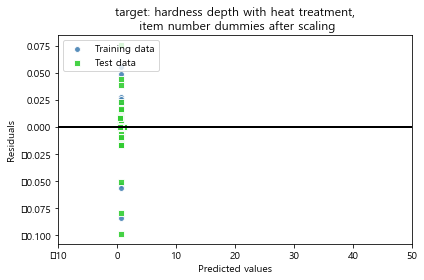

In [254]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='Test data')
plt.title('target: hardness depth with heat treatment,\n item number dummies after scaling')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('images/10_15.png', dpi=300)
plt.show()

In [ ]:
df1.groupby('품번')[['경화깊이','가열로히터온도','LNG순간유량', 'CP 농도', 'RX 순간유량','공정시간_set']].mean()

In [264]:
df4.columns

Index(['경화깊이', '공정시간_step', '가열로히터온도', 'LNG순간유량', 'CP농도', 'RX순간유량', '열처리_침탄질화',
       '품번_BM840-TF000', '품번_BM844 TH051', '품번_GC04400710', '품번_GC04410210',
       '품번_OP131-HD100', '품번_OP131-HD500', 'step_2침탄', 'step_3강온'],
      dtype='object')

In [268]:
df4.groupby([ '품번_BM840-TF000', '품번_BM844 TH051', '품번_GC04400710', '품번_GC04410210',
       '품번_OP131-HD100', '품번_OP131-HD500'])['경화깊이', '가열로히터온도', 'LNG순간유량', 'CP농도', 'RX순간유량'].mean()

경화깊이  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500             
0              0              0             0             0              0               0.591360   
                                                                         1               0.719519   
                                                          1              0               0.611591   
                                            1             0              0               0.960000   
                              1             0             0              0               1.180000   
               1              0             0             0              0               0.767672   
1              0              0             0             0              0               0.650000   

                                                                                            가열로히터온도  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500               
0              0              0             0             0              0               877.254400   
                                                                         1               886.358598   
                                                          1              0               879.958242   
                                            1             0              0               901.680195   
                              1             0             0              0               899.588643   
               1              0             0             0              0               872.678375   
1              0              0             0             0              0               865.923990   

                                                                                          LNG순간유량  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500             
0              0              0             0             0              0               1.540640   
                                                                         1               1.743005   
                                                          1              0               1.645715   
                                            1             0              0               0.786201   
                              1             0             0              0               0.913158   
               1              0             0             0              0               1.275826   
1              0              0             0             0              0               1.751069   

                                                                                             CP농도  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500             
0              0              0             0             0              0               8.215840   
                                                                         1               8.974391   
                                                          1              0               8.951692   
                                            1             0              0               8.893344   
                              1             0             0              0               8.983795   
               1              0             0             0              0               8.934986   
1              0              0             0             0              0               8.928029   

                                                                                            RX순간유량  
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500             
0              0              0             0             0              0               44.104320  
                                                                         1               47.875927  
                               

In [289]:
df1.columns

Index(['measuredt', '가열로히터온도', 'LNG순간유량', 'CP농도', 'RX순간유량', '시작일', '열처리',
       '표면경도', '심부경도', '경화깊이', '재질', '수량_set', '규격', '품번', '품명', '거래처',
       'company', 'id', 'LOTNO', 'set', 'step', '공정시간_set', '공정시간_step',
       '온도차이_set', '온도합계_set', '온도평균_step', '온도차이_step', '온도합계_step',
       'LNG유량합계_step', 'LNG유량합계_set', 'CP농도합계_step', 'CP농도합계_set',
       'RX유량합계_step', 'RX유량합계_set'],
      dtype='object')

In [290]:
df1.groupby(['품번','step'])['공정시간_step'].mean()

품번           step
45753-02400  1승온      89.866667
             2침탄     169.603774
             3강온     106.439490
BM840-TF000  1승온     166.000000
             2침탄     214.000000
             3강온      93.000000
BM844 TH051  1승온     147.942928
             2침탄     315.240106
             3강온     108.587629
GC04400710   1승온     124.000000
             2침탄     500.000000
             3강온     126.000000
GC04410210   1승온      99.000000
             2침탄     504.000000
             3강온     122.000000
OP131-HD100  1승온     161.837427
             2침탄     367.601212
             3강온     141.914251
OP131-HD500  1승온     169.659033
             2침탄     407.844779
             3강온      98.473684
Name: 공정시간_step, dtype: float64

# RandomForestRegressor

In [292]:
from sklearn.ensemble import RandomForestRegressor
forest=RandomForestRegressor(n_estimators=500,criterion='mse',random_state=101)

1.경화깊이

In [293]:
X=df1.iloc[:,1:5].values
y=df1.iloc[:,9].values

In [294]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [321]:
forest.fit(X_train,y_train)

RandomForestRegressor(n_estimators=500, random_state=101)

In [296]:
y_train_pred=forest.predict(X_train)
y_test_pred=forest.predict(X_test)


In [311]:
from sklearn.metrics import r2_score
print('MSE :',mean_squared_error(y_test, y_test_pred))
r_train_square = forest.score(X_train, y_train)
print('r-square of train dataset : %.3f' % r_train_square)
r_test_square = forest.score(X_test, y_test_pred)
print('r-square of test dataset : %.3f' % r_test_square)

adj_train_R2=1 - (1-forest.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print('adjusted R-square of train dataset: %.3f' % adj_train_R2)
adj_test_R2=1 - (1-forest.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('adjusted R-square of test dataset : %.3f' % adj_test_R2)


MSE : 0.006418124615057077
r-square of train dataset : 0.963
r-square of test dataset : 1.000
adjusted R-square of train dataset: 0.963
adjusted R-square of test dataset : 0.748


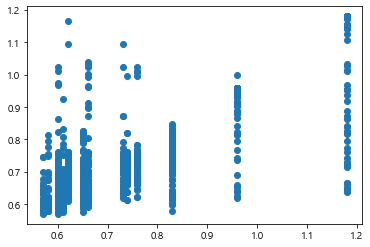

In [312]:
import matplotlib.pyplot as plt

#plt.scatter(X_test,y_test, marker = 'x')
plt.scatter(y_test,y_test_pred, marker = 'o')
plt.show()

In [ ]:
heatNames= np.array(data.feature_names[1:])

In [319]:
df2.head()

,measuredt,가열로히터온도,LNG순간유량,CP농도,RX순간유량,시작일,표면경도,심부경도,경화깊이,수량_set,...,열처리_침탄질화,step_2침탄,step_3강온,재질_SCR420HB,품번_BM840-TF000,품번_BM844 TH051,품번_GC04400710,품번_GC04410210,품번_OP131-HD100,품번_OP131-HD500
0,2021-11-17 03:12:00,639,6.9,3.9,46.0,2021-11-17 03:41:00,672.6,60.3,1.18,300,...,0,0,0,0,0,0,1,0,0,0
1,2021-11-17 03:13:00,639,6.9,4.6,46.0,2021-11-17 03:41:00,672.6,60.3,1.18,300,...,0,0,0,0,0,0,1,0,0,0
2,2021-11-17 03:14:00,639,5.1,16.6,46.4,2021-11-17 03:41:00,672.6,60.3,1.18,300,...,0,0,0,0,0,0,1,0,0,0
3,2021-11-17 03:15:00,639,0.0,16.6,46.0,2021-11-17 03:41:00,672.6,60.3,1.18,300,...,0,0,0,0,0,0,1,0,0,0
4,2021-11-17 03:16:00,639,0.0,16.6,46.0,2021-11-17 03:41:00,672.6,60.3,1.18,300,...,0,0,0,0,0,0,1,0,0,0


In [322]:
featureImportance=forest.feature_importances_
featureImportance

array([0.65244844, 0.06666082, 0.07944457, 0.20144618])

Note=>가열로히터온도, RX순간유량,CP농도,LNG순간유량 순으로 중요함

In [336]:
feat_labels=df1[1:5]
indices = np.argsort(featureImportance)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            featureImportance[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        featureImportance[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
# plt.savefig('images/04_09.png', dpi=300)
plt.show()

KeyError: 0

KeyError: "None of [Int64Index([1, 2, 3, 0], dtype='int64')] are in the [columns]"

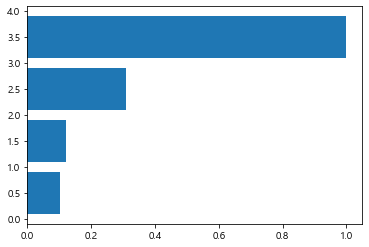

In [331]:
featureImportance=forest.feature_importances_

#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, df1[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

In [330]:
featureImportance

array([1.        , 0.10217025, 0.12176375, 0.30875417])

In [323]:
!pip install eli5

In [324]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(forest, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)

NameError: name 'imp_df' is not defined

In [326]:
!pip install rfpimp

  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10667 sha256=a01f6cf07c1afe07584934587e66a13b61b9bd44af5025247f818ef931546189
  Stored in directory: c:\users\wonnho\appdata\local\pip\cache\wheels\d9\f2\53\6d8c73011f73fc347598d683ff8b2343605ad43474ae083816
Successfully built rfpimp


In [327]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(forest, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(forest, X_train, y_train, r2)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

2.심부경도

In [337]:

X=df1.iloc[:,1:5].values
y=df1.iloc[:,8].values

In [338]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [339]:
forest.fit(X_train,y_train)

RandomForestRegressor(n_estimators=500, random_state=101)

In [340]:
y_train_pred=forest.predict(X_train)
y_test_pred=forest.predict(X_test)


In [341]:
from sklearn.metrics import r2_score
print('MSE :',mean_squared_error(y_test, y_test_pred))
r_train_square = forest.score(X_train, y_train)
print('r-square of train dataset : %.3f' % r_train_square)
r_test_square = forest.score(X_test, y_test_pred)
print('r-square of test dataset : %.3f' % r_test_square)

adj_train_R2=1 - (1-forest.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print('adjusted R-square of train dataset: %.3f' % adj_train_R2)
adj_test_R2=1 - (1-forest.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('adjusted R-square of test dataset : %.3f' % adj_test_R2)


MSE : 3132.1924187619916
r-square of train dataset : 0.898
r-square of test dataset : 1.000
adjusted R-square of train dataset: 0.898
adjusted R-square of test dataset : 0.539


3.표면경도

In [342]:

X=df1.iloc[:,1:5].values
y=df1.iloc[:,7].values

In [343]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [344]:
forest.fit(X_train,y_train)

RandomForestRegressor(n_estimators=500, random_state=101)

In [345]:
y_train_pred=forest.predict(X_train)
y_test_pred=forest.predict(X_test)


In [346]:
from sklearn.metrics import r2_score
print('MSE :',mean_squared_error(y_test, y_test_pred))
r_train_square = forest.score(X_train, y_train)
print('r-square of train dataset : %.3f' % r_train_square)
r_test_square = forest.score(X_test, y_test_pred)
print('r-square of test dataset : %.3f' % r_test_square)

adj_train_R2=1 - (1-forest.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print('adjusted R-square of train dataset: %.3f' % adj_train_R2)
adj_test_R2=1 - (1-forest.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('adjusted R-square of test dataset : %.3f' % adj_test_R2)


MSE : 11742.05645285566
r-square of train dataset : 0.961
r-square of test dataset : 1.000
adjusted R-square of train dataset: 0.961
adjusted R-square of test dataset : 0.796


key point: 경화깊이가 테스트데이터셋에서 MSE가 가장 낮음. 소숫점 자리.수정결정계수는 74.8%.
반면 수정결정계수는 표면경도일 경우 테스트 데이터셋에서 제일 높음. 79.6%.


## Case 2: RandomForestRegressor with heat treatment

In [347]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10495 entries, 0 to 10494
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   경화깊이       10495 non-null  float64
 1   공정시간_step  10495 non-null  int32  
 2   가열로히터온도    10495 non-null  int64  
 3   LNG순간유량    10495 non-null  float64
 4   CP농도       10495 non-null  float64
 5   RX순간유량     10495 non-null  float64
 6   열처리_침탄질화   10495 non-null  uint8  
 7   step_2침탄   10495 non-null  uint8  
 8   step_3강온   10495 non-null  uint8  
dtypes: float64(4), int32(1), int64(1), uint8(3)
memory usage: 821.7 KB


#1.경화깊이

In [348]:
X=df3.iloc[:,1:].values
y=df3.iloc[:,0].values

In [349]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [350]:
forest.fit(X_train,y_train)

RandomForestRegressor(n_estimators=500, random_state=101)

In [351]:
y_train_pred=forest.predict(X_train)
y_test_pred=forest.predict(X_test)


In [352]:
from sklearn.metrics import r2_score
print('MSE :',mean_squared_error(y_test, y_test_pred))
r_train_square = forest.score(X_train, y_train)
print('r-square of train dataset : %.3f' % r_train_square)
r_test_square = forest.score(X_test, y_test_pred)
print('r-square of test dataset : %.3f' % r_test_square)

adj_train_R2=1 - (1-forest.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print('adjusted R-square of train dataset: %.3f' % adj_train_R2)
adj_test_R2=1 - (1-forest.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('adjusted R-square of test dataset : %.3f' % adj_test_R2)


MSE : 5.1885962267745895e-05
r-square of train dataset : 0.999
r-square of test dataset : 1.000
adjusted R-square of train dataset: 0.999
adjusted R-square of test dataset : 0.998


In [355]:
train_sizes,train_scores,test_scores=learning_curve(estimator=forest,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)

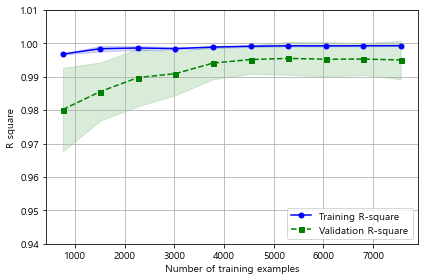

In [359]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training R-square')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation R-square')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.title('경화깊이:RandomForestRegreesor with 열처리, 단계')
plt.xlabel('Number of training examples')
plt.ylabel('R square')
plt.legend(loc='lower right')
plt.ylim([0.94, 1.01])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

=> 표본수가 2500개가 넘어가면서 0.01%의 차이밖에 보이지 않고 있다.

심부경도

In [530]:
df3_1=df2[['심부경도','공정시간_step','가열로히터온도','LNG순간유량','CP농도','RX순간유량','열처리_침탄질화','step_2침탄','step_3강온']]

In [531]:
X=df3_1.iloc[:,1:].values
y=df3_1.iloc[:,0].values

In [532]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [533]:
forest.fit(X_train,y_train)

RandomForestRegressor(n_estimators=500, random_state=101)

In [534]:
y_train_pred=forest.predict(X_train)
y_test_pred=forest.predict(X_test)


In [535]:
from sklearn.metrics import r2_score
print('MSE :',mean_squared_error(y_test, y_test_pred))
r_train_square = forest.score(X_train, y_train)
print('r-square of train dataset : %.3f' % r_train_square)
r_test_square = forest.score(X_test, y_test_pred)
print('r-square of test dataset : %.3f' % r_test_square)

adj_train_R2=1 - (1-forest.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print('adjusted R-square of train dataset: %.3f' % adj_train_R2)
adj_test_R2=1 - (1-forest.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('adjusted R-square of test dataset : %.3f' % adj_test_R2)


MSE : 48.1919697858791
r-square of train dataset : 0.999
r-square of test dataset : 1.000
adjusted R-square of train dataset: 0.999
adjusted R-square of test dataset : 0.993


In [536]:
train_sizes,train_scores,test_scores=learning_curve(estimator=forest,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)

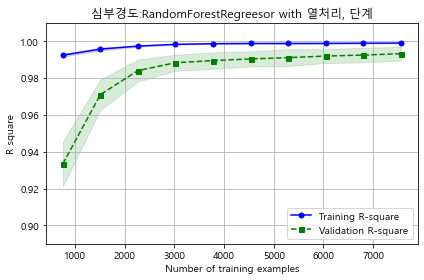

In [540]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training R-square')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation R-square')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.title('심부경도:RandomForestRegreesor with 열처리, 단계')
plt.xlabel('Number of training examples')
plt.ylabel('R square')
plt.legend(loc='lower right')
plt.ylim([0.89, 1.01])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

표면경도

In [541]:
df3_2=df2[['표면경도','공정시간_step','가열로히터온도','LNG순간유량','CP농도','RX순간유량','열처리_침탄질화','step_2침탄','step_3강온']]

In [542]:
X=df3_2.iloc[:,1:].values
y=df3_2.iloc[:,0].values

In [543]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [544]:
forest.fit(X_train,y_train)

RandomForestRegressor(n_estimators=500, random_state=101)

In [545]:
y_train_pred=forest.predict(X_train)
y_test_pred=forest.predict(X_test)


In [546]:
from sklearn.metrics import r2_score
print('MSE :',mean_squared_error(y_test, y_test_pred))
r_train_square = forest.score(X_train, y_train)
print('r-square of train dataset : %.3f' % r_train_square)
r_test_square = forest.score(X_test, y_test_pred)
print('r-square of test dataset : %.3f' % r_test_square)

adj_train_R2=1 - (1-forest.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print('adjusted R-square of train dataset: %.3f' % adj_train_R2)
adj_test_R2=1 - (1-forest.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('adjusted R-square of test dataset : %.3f' % adj_test_R2)


MSE : 1107.7785064324094
r-square of train dataset : 0.998
r-square of test dataset : 1.000
adjusted R-square of train dataset: 0.998
adjusted R-square of test dataset : 0.981


In [547]:
train_sizes,train_scores,test_scores=learning_curve(estimator=forest,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)

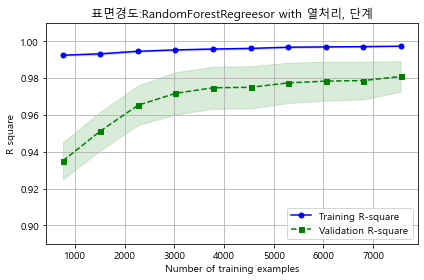

In [548]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training R-square')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation R-square')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.title('표면경도:RandomForestRegreesor with 열처리, 단계')
plt.xlabel('Number of training examples')
plt.ylabel('R square')
plt.legend(loc='lower right')
plt.ylim([0.89, 1.01])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

Case3: RandomForestRegressor with heat treatment, item number

#경화깊이

In [550]:

X=df4.iloc[:,1:].values
y=df4.iloc[:,0].values

In [551]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [552]:
forest.fit(X_train,y_train)

RandomForestRegressor(n_estimators=500, random_state=101)

In [553]:
y_train_pred=forest.predict(X_train)
y_test_pred=forest.predict(X_test)


In [554]:
from sklearn.metrics import r2_score
print('MSE :',mean_squared_error(y_test, y_test_pred))
r_train_square = forest.score(X_train, y_train)
print('r-square of train dataset : %.3f' % r_train_square)
r_test_square = forest.score(X_test, y_test_pred)
print('r-square of test dataset : %.3f' % r_test_square)

adj_train_R2=1 - (1-forest.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print('adjusted R-square of train dataset: %.3f' % adj_train_R2)
adj_test_R2=1 - (1-forest.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('adjusted R-square of test dataset : %.3f' % adj_test_R2)


MSE : 1.495296865173881e-05
r-square of train dataset : 1.000
r-square of test dataset : 1.000
adjusted R-square of train dataset: 1.000
adjusted R-square of test dataset : 0.999


In [555]:
train_sizes,train_scores,test_scores=learning_curve(estimator=forest,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)


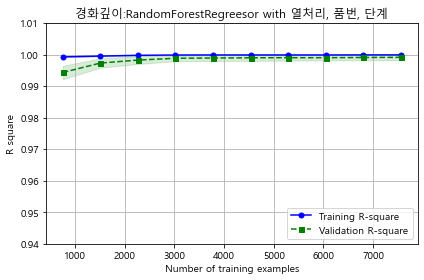

In [556]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training R-square')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation R-square')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.title('경화깊이:RandomForestRegreesor with 열처리, 품번, 단계')
plt.xlabel('Number of training examples')
plt.ylabel('R square')
plt.legend(loc='lower right')
plt.ylim([0.94, 1.01])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

=> instill more features into the model and then r-square in the test dataset get faster to the accuracy of training dataset

심부경도

In [557]:
df4_2=df2[['심부경도','공정시간_step','가열로히터온도','LNG순간유량','CP농도','RX순간유량','열처리_침탄질화','품번_BM840-TF000', '품번_BM844 TH051',
       '품번_GC04400710', '품번_GC04410210', '품번_OP131-HD100', '품번_OP131-HD500','step_2침탄','step_3강온']]

In [558]:
X=df4_2.iloc[:,1:].values
y=df4_2.iloc[:,0].values

In [559]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [560]:
forest.fit(X_train,y_train)

RandomForestRegressor(n_estimators=500, random_state=101)

In [561]:
y_train_pred=forest.predict(X_train)
y_test_pred=forest.predict(X_test)


In [562]:
from sklearn.metrics import r2_score
print('MSE :',mean_squared_error(y_test, y_test_pred))
r_train_square = forest.score(X_train, y_train)
print('r-square of train dataset : %.3f' % r_train_square)
r_test_square = forest.score(X_test, y_test_pred)
print('r-square of test dataset : %.3f' % r_test_square)

adj_train_R2=1 - (1-forest.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print('adjusted R-square of train dataset: %.3f' % adj_train_R2)
adj_test_R2=1 - (1-forest.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('adjusted R-square of test dataset : %.3f' % adj_test_R2)


MSE : 43.264053300219274
r-square of train dataset : 1.000
r-square of test dataset : 1.000
adjusted R-square of train dataset: 1.000
adjusted R-square of test dataset : 0.994


In [563]:
train_sizes,train_scores,test_scores=learning_curve(estimator=forest,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)


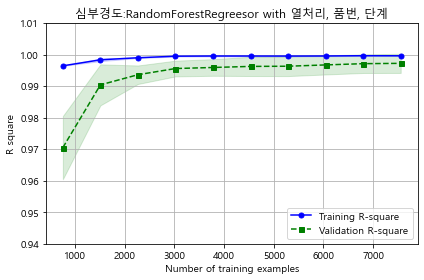

In [564]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training R-square')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation R-square')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.title('심부경도:RandomForestRegreesor with 열처리, 품번, 단계')
plt.xlabel('Number of training examples')
plt.ylabel('R square')
plt.legend(loc='lower right')
plt.ylim([0.94, 1.01])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

#표면경도

In [565]:
df4_3=df2[['표면경도','공정시간_step','가열로히터온도','LNG순간유량','CP농도','RX순간유량','열처리_침탄질화','품번_BM840-TF000', '품번_BM844 TH051',
       '품번_GC04400710', '품번_GC04410210', '품번_OP131-HD100', '품번_OP131-HD500','step_2침탄','step_3강온']]

In [566]:
X=df4_3.iloc[:,1:].values
y=df4_3.iloc[:,0].values

In [567]:
from sklearn.model_selection import train_test_split,learning_curve
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                              random_state=101)

In [568]:
forest.fit(X_train,y_train)

RandomForestRegressor(n_estimators=500, random_state=101)

In [569]:
y_train_pred=forest.predict(X_train)
y_test_pred=forest.predict(X_test)


In [570]:
from sklearn.metrics import r2_score
print('MSE :',mean_squared_error(y_test, y_test_pred))
r_train_square = forest.score(X_train, y_train)
print('r-square of train dataset : %.3f' % r_train_square)
r_test_square = forest.score(X_test, y_test_pred)
print('r-square of test dataset : %.3f' % r_test_square)

adj_train_R2=1 - (1-forest.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print('adjusted R-square of train dataset: %.3f' % adj_train_R2)
adj_test_R2=1 - (1-forest.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('adjusted R-square of test dataset : %.3f' % adj_test_R2)


MSE : 9.254746434493038
r-square of train dataset : 1.000
r-square of test dataset : 1.000
adjusted R-square of train dataset: 1.000
adjusted R-square of test dataset : 1.000


In [571]:
train_sizes,train_scores,test_scores=learning_curve(estimator=forest,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)


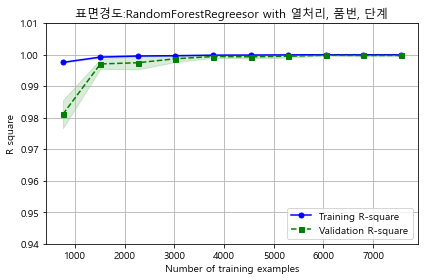

In [572]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training R-square')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation R-square')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.title('표면경도:RandomForestRegreesor with 열처리, 품번, 단계')
plt.xlabel('Number of training examples')
plt.ylabel('R square')
plt.legend(loc='lower right')
plt.ylim([0.94, 1.01])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

# Simulation

품번과 열처리를 가미한 ridgeRegression을 이용하기 위한 통계량 

In [163]:
df1.columns

Index(['measuredt', '가열로히터온도', 'LNG순간유량', 'CP농도', 'RX순간유량', '시작일', '열처리',
       '표면경도', '심부경도', '경화깊이', '재질', '수량_set', '규격', '품번', '품명', '거래처',
       'company', 'id', 'LOTNO', 'set', 'step', '공정시간_set', '공정시간_step',
       '온도차이_set', '온도합계_set', '온도평균_step', '온도차이_step', '온도합계_step',
       'LNG유량합계_step', 'LNG유량합계_set', 'CP농도합계_step', 'CP농도합계_set',
       'RX유량합계_step', 'RX유량합계_set'],
      dtype='object')

In [236]:
pd.options.display.float_format = '{:.2f}'.format

In [166]:
df1.groupby(['품번','열처리','step'])[['공정시간_step','가열로히터온도']].describe()

공정시간_step                                           \
                          count   mean   std    min    25%    50%    75%   
품번          열처리  step                                                      
45753-02400 침탄   1승온     150.00  89.87  5.01  85.00  85.00  85.00  95.00   
                 2침탄     318.00 169.60  1.50 168.00 168.00 171.00 171.00   
                 3강온     157.00 106.44  2.32 103.00 103.00 108.00 108.00   
BM840-TF000 침탄   1승온     155.00 166.00  0.00 166.00 166.00 166.00 166.00   
                 2침탄     184.00 214.00  0.00 214.00 214.00 214.00 214.00   
                 3강온      82.00  93.00  0.00  93.00  93.00  93.00  93.00   
BM844 TH051 침탄   1승온     403.00 147.94 14.46 137.00 137.00 137.00 167.00   
                 2침탄     758.00 315.24 12.98 298.00 298.00 325.00 325.00   
                 3강온     291.00 108.59 17.87  93.00  93.00  93.00 129.00   
GC04400710  침탄   1승온     117.00 124.00  0.00 124.00 124.00 124.00 124.00   
                 2침탄     482.00 500.00  0.00 500.00 500.00 500.00 500.00   
                 3강온     123.00 126.00  0.00 126.00 126.00 126.00 126.00   
GC04410210  침탄   1승온      83.00  99.00  0.00  99.00  99.00  99.00  99.00   
                 2침탄     421.00 504.00  0.00 504.00 504.00 504.00 504.00   
                 3강온     112.00 122.00  0.00 122.00 122.00 122.00 122.00   
OP131-HD100 침탄   1승온     855.00 161.84  7.94 151.00 156.00 160.00 170.00   
                 2침탄    1981.00 367.60  4.07 362.00 363.00 370.00 370.00   
                 3강온     828.00 141.91 31.41 103.00 118.00 130.00 181.00   
OP131-HD500 침탄질화 1승온     786.00 169.66 11.64 155.00 155.00 176.00 176.00   
                 2침탄    1791.00 407.84  2.48 405.00 405.00 410.00 410.00   
                 3강온     418.00  98.47 17.47  80.00  80.00  88.00 117.00   

                             가열로히터온도                                           \
                         max   count   mean   std    min    25%    50%    75%   
품번          열처리  step                                                           
45753-02400 침탄   1승온   95.00  150.00 824.06 57.03 730.00 775.00 819.00 875.75   
                 2침탄  171.00  318.00 909.04  1.35 906.00 908.00 909.00 909.00   
                 3강온  108.00  157.00 863.69 27.91 742.00 842.00 860.00 886.00   
BM840-TF000 침탄   1승온  166.00  155.00 819.35 77.50 663.00 759.00 830.00 891.00   
                 2침탄  214.00  184.00 908.70  1.15 906.00 908.00 909.00 909.00   
                 3강온   93.00   82.00 857.99 35.66 689.00 850.00 857.50 875.00   
BM844 TH051 침탄   1승온  167.00  403.00 809.65 72.89 678.00 750.00 814.00 875.00   
                 2침탄  325.00  758.00 908.71  1.20 904.00 908.00 909.00 909.00   
                 3강온  129.00  291.00 866.11 22.92 706.00 850.00 867.00 878.00   
GC04400710  침탄   1승온  124.00  117.00 799.57 97.14 639.00 716.00 816.00 881.00   
                 2침탄  500.00  482.00 928.57  1.25 926.00 927.00 929.00 929.00   
                 3강온  126.00  123.00 881.15 28.88 845.00 852.00 876.00 907.00   
GC04410210  침탄   1승온   99.00   83.00 810.47 80.06 668.00 749.50 821.00 869.50   
                 2침탄  504.00  421.00 928.77  1.32 926.00 927.00 929.00 929.00   
                 3강온  122.00  112.00 867.46 31.80 699.00 850.00 867.00 885.25   
OP131-HD100 침탄   1승온  174.00  855.00 807.34 80.74 657.00 741.00 819.00 877.00   
                 2침탄  373.00 1981.00 918.79  1.68 914.00 917.00 919.00 919.00   
                 3강온  181.00  828.00 862.03 24.28 673.00 848.00 855.00 871.00   
OP131-HD500 침탄질화 1승온  183.00  786.00 817.87 72.10 657.00 762.00 827.00 880.75   
                 2침탄  410.00 1791.00 918.34  1.60 911.00 917.00 919.00 919.00   
                 3강온  117.00  418.00 878.11 23.09 835.00 858.00 871.00 895.50   

                              
                         max  
품번          열처리  step         
45753-02400 침탄   1승온  914.00  
                 2침탄  914.00  
                 3강온  911.00  
BM840-TF000 침탄   1승온  916.00  
                 2침탄  911.00  
    

In [167]:
df1.groupby(['품번','열처리','step'])[['LNG순간유량', 'CP농도']].describe()

LNG순간유량                                       CP농도       \
                        count mean  std  min  25%  50%  75%  max   count mean   
품번          열처리  step                                                           
45753-02400 침탄   1승온   150.00 1.50 2.06 0.00 0.00 0.45 2.10 7.00  150.00 6.21   
                 2침탄   318.00 1.93 1.27 0.00 1.12 1.90 2.30 6.90  318.00 9.10   
                 3강온   157.00 0.79 1.17 0.00 0.00 0.10 1.20 4.70  157.00 8.34   
BM840-TF000 침탄   1승온   155.00 0.97 1.26 0.00 0.00 0.10 2.35 6.00  155.00 8.39   
                 2침탄   184.00 2.64 1.42 0.00 1.90 2.55 3.23 7.30  184.00 9.54   
                 3강온    82.00 1.22 1.37 0.00 0.00 0.85 2.08 5.00   82.00 8.58   
BM844 TH051 침탄   1승온   403.00 0.83 1.28 0.00 0.00 0.10 1.90 7.00  403.00 8.53   
                 2침탄   758.00 1.69 1.07 0.00 1.00 1.70 2.30 7.00  758.00 9.40   
                 3강온   291.00 0.80 1.17 0.00 0.00 0.00 1.35 4.60  291.00 8.28   
GC04400710  침탄   1승온   117.00 0.98 1.36 0.00 0.00 0.10 1.90 6.90  117.00 8.74   
                 2침탄   482.00 1.02 0.99 0.00 0.03 0.90 1.60 6.80  482.00 9.27   
                 3강온   123.00 0.41 0.83 0.00 0.00 0.10 0.35 4.20  123.00 8.08   
GC04410210  침탄   1승온    83.00 0.57 0.97 0.00 0.00 0.00 1.10 6.00   83.00 8.23   
                 2침탄   421.00 0.94 0.93 0.00 0.00 0.90 1.40 6.80  421.00 9.23   
                 3강온   112.00 0.37 0.71 0.00 0.00 0.00 0.62 3.70  112.00 8.10   
OP131-HD100 침탄   1승온   855.00 1.33 1.55 0.00 0.00 0.10 2.90 6.90  855.00 8.60   
                 2침탄  1981.00 2.16 1.34 0.00 1.30 2.10 2.90 7.00 1981.00 9.40   
                 3강온   828.00 0.74 1.19 0.00 0.00 0.00 1.10 5.70  828.00 8.24   
OP131-HD500 침탄질화 1승온   786.00 1.28 1.46 0.00 0.00 0.10 2.60 7.00  786.00 8.05   
                 2침탄  1791.00 2.15 1.32 0.00 1.20 2.20 2.90 7.20 1791.00 9.48   
                 3강온   418.00 0.88 1.23 0.00 0.00 0.10 1.40 5.10  418.00 8.56   

                                                        
                       std  min  25%   50%   75%   max  
품번          열처리  step                                   
45753-02400 침탄   1승온  0.66 3.50 6.00  6.00  6.70  7.50  
                 2침탄  1.49 3.40 9.00 10.00 10.00 10.10  
                 3강온  1.35 3.90 7.00  9.00  9.20  9.80  
BM840-TF000 침탄   1승온  3.81 3.80 6.00  6.10  9.15 16.60  
                 2침탄  0.66 7.00 8.70  9.90 10.00 10.20  
                 3강온  1.12 5.20 8.60  8.70  8.80 16.60  
BM844 TH051 침탄   1승온  3.67 3.70 6.00  6.70  9.50 16.60  
                 2침탄  0.95 3.40 8.90 10.00 10.00 10.10  
                 3강온  1.17 3.80 7.75  8.80  9.00  9.60  
GC04400710  침탄   1승온  4.55 3.90 6.00  6.00  7.30 16.60  
                 2침탄  1.00 3.40 8.50  9.90 10.00 10.20  
                 3강온  1.12 5.90 8.20  8.40  8.85  9.60  
GC04410210  침탄   1승온  4.13 5.90 6.00  6.00  6.90 16.60  
                 2침탄  1.05 4.60 8.40  9.90 10.00 10.20  
                 3강온  1.01 3.90 8.40  8.40  8.50  9.30  
OP131-HD100 침탄   1승온  4.10 3.80 6.00  6.10  9.10 16.60  
                 2침탄  1.06 3.40 9.00  9.90 10.00 10.20  
                 3강온  1.28 3.60 6.80  9.00  9.10 16.60  
OP131-HD500 침탄질화 1승온  3.44 3.70 6.00  6.00  8.88 16.60  
                 2침탄  0.97 3.30 9.10  9.90 10.00 10.20  
                 3강온  1.21 5.20 7.82  9.00  9.30 10.10

In [171]:
df1.groupby(['품번','열처리','step'])[['RX순간유량','경화깊이']].describe()

RX순간유량                                           \
                        count  mean  std   min   25%   50%   75%   max   
품번          열처리  step                                                    
45753-02400 침탄   1승온   150.00 43.97 2.36 41.20 41.60 45.60 46.40 46.80   
                 2침탄   318.00 43.82 2.43 40.00 41.20 45.60 46.00 46.80   
                 3강온   157.00 44.81 2.44 39.60 41.60 46.00 46.40 48.00   
BM840-TF000 침탄   1승온   155.00 42.32 0.30 41.60 42.00 42.40 42.40 42.80   
                 2침탄   184.00 42.00 0.51 39.60 41.60 42.00 42.40 43.20   
                 3강온    82.00 41.58 0.80 40.80 41.20 41.60 41.60 48.40   
BM844 TH051 침탄   1승온   403.00 44.99 1.77 40.80 42.80 46.00 46.40 46.80   
                 2침탄   758.00 45.18 2.50 40.40 42.00 46.80 47.20 48.00   
                 3강온   291.00 45.23 2.54 41.60 42.40 47.20 47.20 52.80   
GC04400710  침탄   1승온   117.00 45.81 0.35 44.40 45.60 46.00 46.00 46.80   
                 2침탄   482.00 46.13 0.69 44.40 45.60 46.00 46.80 47.60   
                 3강온   123.00 46.31 0.90 45.20 46.00 46.40 46.40 55.60   
GC04410210  침탄   1승온    83.00 40.89 0.33 40.00 40.80 40.80 41.20 41.60   
                 2침탄   421.00 40.51 0.32 39.20 40.40 40.40 40.80 41.20   
                 3강온   112.00 40.28 1.67 38.80 40.00 40.00 40.40 57.20   
OP131-HD100 침탄   1승온   855.00 43.37 2.20 39.60 42.00 42.40 45.60 47.20   
                 2침탄  1981.00 43.49 2.40 39.20 41.60 42.40 46.00 47.60   
                 3강온   828.00 43.53 2.26 39.60 41.60 42.40 46.00 54.80   
OP131-HD500 침탄질화 1승온   786.00 47.84 1.03 46.00 47.20 47.60 48.00 50.40   
                 2침탄  1791.00 47.87 1.00 46.00 47.20 47.60 48.40 50.40   
                 3강온   418.00 47.96 0.85 46.00 47.60 48.00 48.40 59.20   

                         경화깊이                                     
                        count mean  std  min  25%  50%  75%  max  
품번          열처리  step                                             
45753-02400 침탄   1승온   150.00 0.59 0.01 0.58 0.58 0.60 0.60 0.60  
                 2침탄   318.00 0.59 0.01 0.58 0.58 0.60 0.60 0.60  
                 3강온   157.00 0.59 0.01 0.58 0.58 0.60 0.60 0.60  
BM840-TF000 침탄   1승온   155.00 0.65 0.00 0.65 0.65 0.65 0.65 0.65  
                 2침탄   184.00 0.65 0.00 0.65 0.65 0.65 0.65 0.65  
                 3강온    82.00 0.65 0.00 0.65 0.65 0.65 0.65 0.65  
BM844 TH051 침탄   1승온   403.00 0.77 0.05 0.73 0.73 0.73 0.83 0.83  
                 2침탄   758.00 0.77 0.05 0.73 0.73 0.73 0.83 0.83  
                 3강온   291.00 0.77 0.05 0.73 0.73 0.73 0.83 0.83  
GC04400710  침탄   1승온   117.00 1.18 0.00 1.18 1.18 1.18 1.18 1.18  
                 2침탄   482.00 1.18 0.00 1.18 1.18 1.18 1.18 1.18  
                 3강온   123.00 1.18 0.00 1.18 1.18 1.18 1.18 1.18  
GC04410210  침탄   1승온    83.00 0.96 0.00 0.96 0.96 0.96 0.96 0.96  
                 2침탄   421.00 0.96 0.00 0.96 0.96 0.96 0.96 0.96  
                 3강온   112.00 0.96 0.00 0.96 0.96 0.96 0.96 0.96  
OP131-HD100 침탄   1승온   855.00 0.61 0.03 0.57 0.60 0.60 0.62 0.66  
                 2침탄  1981.00 0.61 0.03 0.57 0.60 0.61 0.62 0.66  
                 3강온   828.00 0.61 0.02 0.57 0.60 0.62 0.62 0.66  
OP131-HD500 침탄질화 1승온   786.00 0.72 0.06 0.60 0.74 0.74 0.76 0.76  
                 2침탄  1791.00 0.72 0.06 0.60 0.74 0.74 0.76 0.76  
                 3강온   418.00 0.73 0.06 0.60 0.74 0.74 0.76 0.76

In [237]:
df1.groupby(['품번','열처리','step'])[['심부경도','표면경도']].describe()

심부경도                                                  \
                        count   mean   std    min    25%    50%    75%    max   
품번          열처리  step                                                           
45753-02400 침탄   1승온   150.00  40.26  0.25  40.00  40.00  40.50  40.50  40.50   
                 2침탄   318.00  40.27  0.25  40.00  40.00  40.50  40.50  40.50   
                 3강온   157.00  40.34  0.23  40.00  40.00  40.50  40.50  40.50   
BM840-TF000 침탄   1승온   155.00  39.20  0.00  39.20  39.20  39.20  39.20  39.20   
                 2침탄   184.00  39.20  0.00  39.20  39.20  39.20  39.20  39.20   
                 3강온    82.00  39.20  0.00  39.20  39.20  39.20  39.20  39.20   
BM844 TH051 침탄   1승온   403.00 222.23  2.60 218.80 218.80 224.20 224.20 224.20   
                 2침탄   758.00 222.25  2.60 218.80 218.80 224.20 224.20 224.20   
                 3강온   291.00 221.86  2.68 218.80 218.80 224.20 224.20 224.20   
GC04400710  침탄   1승온   117.00  60.30  0.00  60.30  60.30  60.30  60.30  60.30   
                 2침탄   482.00  60.30  0.00  60.30  60.30  60.30  60.30  60.30   
                 3강온   123.00  60.30  0.00  60.30  60.30  60.30  60.30  60.30   
GC04410210  침탄   1승온    83.00  60.20  0.00  60.20  60.20  60.20  60.20  60.20   
                 2침탄   421.00  60.20  0.00  60.20  60.20  60.20  60.20  60.20   
                 3강온   112.00  60.20  0.00  60.20  60.20  60.20  60.20  60.20   
OP131-HD100 침탄   1승온   855.00  65.54 62.00  34.50  36.00  37.50  37.50 197.20   
                 2침탄  1981.00  65.86 62.24  34.50  36.00  37.50  37.50 197.20   
                 3강온   828.00  59.36 55.96  34.50  36.00  37.50  37.50 197.20   
OP131-HD500 침탄질화 1승온   786.00 166.14 70.25  32.50 202.30 202.30 203.80 203.80   
                 2침탄  1791.00 168.15 68.89  32.50 202.30 202.30 203.80 203.80   
                 3강온   418.00 175.24 62.99  32.50 202.30 202.30 203.80 203.80   

                         표면경도                                                 
                        count   mean  std    min    25%    50%    75%    max  
품번          열처리  step                                                         
45753-02400 침탄   1승온   150.00 685.11 0.30 684.80 684.80 685.40 685.40 685.40  
                 2침탄   318.00 685.12 0.30 684.80 684.80 685.40 685.40 685.40  
                 3강온   157.00 685.21 0.28 684.80 684.80 685.40 685.40 685.40  
BM840-TF000 침탄   1승온   155.00  59.50 0.00  59.50  59.50  59.50  59.50  59.50  
                 2침탄   184.00  59.50 0.00  59.50  59.50  59.50  59.50  59.50  
                 3강온    82.00  59.50 0.00  59.50  59.50  59.50  59.50  59.50  
BM844 TH051 침탄   1승온   403.00  60.18 0.29  59.80  59.80  60.40  60.40  60.40  
                 2침탄   758.00  60.18 0.29  59.80  59.80  60.40  60.40  60.40  
                 3강온   291.00  60.14 0.30  59.80  59.80  60.40  60.40  60.40  
GC04400710  침탄   1승온   117.00 672.60 0.00 672.60 672.60 672.60 672.60 672.60  
                 2침탄   482.00 672.60 0.00 672.60 672.60 672.60 672.60 672.60  
                 3강온   123.00 672.60 0.00 672.60 672.60 672.60 672.60 672.60  
GC04410210  침탄   1승온    83.00 644.20 0.00 644.20 644.20 644.20 644.20 644.20  
                 2침탄   421.00 644.20 0.00 644.20 644.20 644.20 644.20 644.20  
                 3강온   112.00 644.20 0.00 644.20 644.20 644.20 644.20 644.20  
OP131-HD100 침탄   1승온   855.00  58.09 0.79  57.20  57.40  58.40  58.60  59.40  
                 2침탄  1981.00  58.08 0.80  57.20  57.40  58.40  58.60  59.40  
                 3강온   828.00  57.88 0.80  57.20  57.20  57.40  58.60  59.40  
OP131-HD500 침탄질화 1승온   786.00  58.85 0.23  58.60  58.60  58.90  58.90  59.20  
                 2침탄  1791.00  58.83 0.23  58.60  58.60  58.90  58.90  59.20  
                 3강온   418.00  58.84 0.21  58.60  58.60  58.90  58.90  59.20

In [ ]:
df4.groupby([ '품번_BM840-TF000', '품번_BM844 TH051', '품번_GC04400710', '품번_GC04410210',
       '품번_OP131-HD100', '품번_OP131-HD500'])['경화깊이', '가열로히터온도', 'LNG순간유량', 'CP농도', 'RX순간유량'].mean()

In [460]:
df4.groupby([ '품번_BM840-TF000', '품번_BM844 TH051', '품번_GC04400710', '품번_GC04410210',
       '품번_OP131-HD100', '품번_OP131-HD500','step_2침탄','step_3강온'])['공정시간_step'].describe()

count  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500 step_2침탄 step_3강온           
0              0              0             0             0              0              0        0          150.0   
                                                                                                 1          157.0   
                                                                                        1        0          318.0   
                                                                         1              0        0          786.0   
                                                                                                 1          418.0   
                                                                                        1        0         1791.0   
                                                          1              0              0        0          855.0   
                                                                                                 1          828.0   
                                                                                        1        0         1981.0   
                                            1             0              0              0        0           83.0   
                                                                                                 1          112.0   
                                                                                        1        0          421.0   
                              1             0             0              0              0        0          117.0   
                                                                                                 1          123.0   
                                                                                        1        0          482.0   
               1              0             0             0              0              0        0          403.0   
                                                                                                 1          291.0   
                                                                                        1        0          758.0   
1              0              0             0             0              0              0        0          155.0   
                                                                                                 1           82.0   
                                                                                        1        0          184.0   

                                                                                                                 mean  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500 step_2침탄 step_3강온               
0              0              0             0             0              0              0        0          89.866667   
                                                                                                 1         106.439490   
                                                                                        1        0         169.603774   
                                                                         1              0        0         169.659033   
                                                                                                 1          98.473684   
                                                                                        1        0         407.844779   
                                                          1              0              0        0         161.837427   
                                                                                                 1         141.914251   
                                                                                        1        0         367.601212   
                                            1             0              0           

In [461]:
df4.groupby([ '품번_BM840-TF000', '품번_BM844 TH051', '품번_GC04400710', '품번_GC04410210',
       '품번_OP131-HD100', '품번_OP131-HD500','step_2침탄','step_3강온'])['가열로히터온도'].describe()

count  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500 step_2침탄 step_3강온           
0              0              0             0             0              0              0        0          150.0   
                                                                                                 1          157.0   
                                                                                        1        0          318.0   
                                                                         1              0        0          786.0   
                                                                                                 1          418.0   
                                                                                        1        0         1791.0   
                                                          1              0              0        0          855.0   
                                                                                                 1          828.0   
                                                                                        1        0         1981.0   
                                            1             0              0              0        0           83.0   
                                                                                                 1          112.0   
                                                                                        1        0          421.0   
                              1             0             0              0              0        0          117.0   
                                                                                                 1          123.0   
                                                                                        1        0          482.0   
               1              0             0             0              0              0        0          403.0   
                                                                                                 1          291.0   
                                                                                        1        0          758.0   
1              0              0             0             0              0              0        0          155.0   
                                                                                                 1           82.0   
                                                                                        1        0          184.0   

                                                                                                                 mean  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500 step_2침탄 step_3강온               
0              0              0             0             0              0              0        0         824.060000   
                                                                                                 1         863.694268   
                                                                                        1        0         909.040881   
                                                                         1              0        0         817.871501   
                                                                                                 1         878.105263   
                                                                                        1        0         918.341150   
                                                          1              0              0        0         807.343860   
                                                                                                 1         862.025362   
                                                                                        1        0         918.794043   
                                            1             0              0           

In [99]:
df4.groupby([ '품번_BM840-TF000', '품번_BM844 TH051', '품번_GC04400710', '품번_GC04410210',
       '품번_OP131-HD100', '품번_OP131-HD500','step_2침탄','step_3강온'])['LNG순간유량'].describe()

count  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500 step_2침탄 step_3강온           
0              0              0             0             0              0              0        0          150.0   
                                                                                                 1          157.0   
                                                                                        1        0          318.0   
                                                                         1              0        0          786.0   
                                                                                                 1          418.0   
                                                                                        1        0         1791.0   
                                                          1              0              0        0          855.0   
                                                                                                 1          828.0   
                                                                                        1        0         1981.0   
                                            1             0              0              0        0           83.0   
                                                                                                 1          112.0   
                                                                                        1        0          421.0   
                              1             0             0              0              0        0          117.0   
                                                                                                 1          123.0   
                                                                                        1        0          482.0   
               1              0             0             0              0              0        0          403.0   
                                                                                                 1          291.0   
                                                                                        1        0          758.0   
1              0              0             0             0              0              0        0          155.0   
                                                                                                 1           82.0   
                                                                                        1        0          184.0   

                                                                                                               mean  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500 step_2침탄 step_3강온             
0              0              0             0             0              0              0        0         1.502000   
                                                                                                 1         0.788535   
                                                                                        1        0         1.930189   
                                                                         1              0        0         1.280280   
                                                                                                 1         0.880144   
                                                                                        1        0         2.147460   
                                                          1              0              0        0         1.327602   
                                                                                                 1         0.736353   
                                                                                        1        0         2.163099   
                                            1             0              0              0        0         

In [100]:
df4.groupby([ '품번_BM840-TF000', '품번_BM844 TH051', '품번_GC04400710', '품번_GC04410210',
       '품번_OP131-HD100', '품번_OP131-HD500','step_2침탄','step_3강온'])['CP농도'].describe()

count  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500 step_2침탄 step_3강온           
0              0              0             0             0              0              0        0          150.0   
                                                                                                 1          157.0   
                                                                                        1        0          318.0   
                                                                         1              0        0          786.0   
                                                                                                 1          418.0   
                                                                                        1        0         1791.0   
                                                          1              0              0        0          855.0   
                                                                                                 1          828.0   
                                                                                        1        0         1981.0   
                                            1             0              0              0        0           83.0   
                                                                                                 1          112.0   
                                                                                        1        0          421.0   
                              1             0             0              0              0        0          117.0   
                                                                                                 1          123.0   
                                                                                        1        0          482.0   
               1              0             0             0              0              0        0          403.0   
                                                                                                 1          291.0   
                                                                                        1        0          758.0   
1              0              0             0             0              0              0        0          155.0   
                                                                                                 1           82.0   
                                                                                        1        0          184.0   

                                                                                                               mean  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500 step_2침탄 step_3강온             
0              0              0             0             0              0              0        0         6.212667   
                                                                                                 1         8.335669   
                                                                                        1        0         9.101572   
                                                                         1              0        0         8.052290   
                                                                                                 1         8.558612   
                                                                                        1        0         9.476103   
                                                          1              0              0        0         8.597544   
                                                                                                 1         8.237440   
                                                                                        1        0         9.403079   
                                            1             0              0              0        0         

In [101]:
df4.groupby([ '품번_BM840-TF000', '품번_BM844 TH051', '품번_GC04400710', '품번_GC04410210',
       '품번_OP131-HD100', '품번_OP131-HD500','step_2침탄','step_3강온'])['RX순간유량'].describe()

count  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500 step_2침탄 step_3강온           
0              0              0             0             0              0              0        0          150.0   
                                                                                                 1          157.0   
                                                                                        1        0          318.0   
                                                                         1              0        0          786.0   
                                                                                                 1          418.0   
                                                                                        1        0         1791.0   
                                                          1              0              0        0          855.0   
                                                                                                 1          828.0   
                                                                                        1        0         1981.0   
                                            1             0              0              0        0           83.0   
                                                                                                 1          112.0   
                                                                                        1        0          421.0   
                              1             0             0              0              0        0          117.0   
                                                                                                 1          123.0   
                                                                                        1        0          482.0   
               1              0             0             0              0              0        0          403.0   
                                                                                                 1          291.0   
                                                                                        1        0          758.0   
1              0              0             0             0              0              0        0          155.0   
                                                                                                 1           82.0   
                                                                                        1        0          184.0   

                                                                                                                mean  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500 step_2침탄 step_3강온              
0              0              0             0             0              0              0        0         43.970667   
                                                                                                 1         44.807643   
                                                                                        1        0         43.820126   
                                                                         1              0        0         47.837150   
                                                                                                 1         47.955024   
                                                                                        1        0         47.874484   
                                                          1              0              0        0         43.372632   
                                                                                                 1         43.533816   
                                                                                        1        0         43.492983   
                                            1             0              0              0       

In [480]:
df4.groupby([ '품번_BM840-TF000', '품번_BM844 TH051', '품번_GC04400710', '품번_GC04410210',
       '품번_OP131-HD100', '품번_OP131-HD500','step_2침탄','step_3강온'])['경화깊이'].describe()

count  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500 step_2침탄 step_3강온           
0              0              0             0             0              0              0        0          150.0   
                                                                                                 1          157.0   
                                                                                        1        0          318.0   
                                                                         1              0        0          786.0   
                                                                                                 1          418.0   
                                                                                        1        0         1791.0   
                                                          1              0              0        0          855.0   
                                                                                                 1          828.0   
                                                                                        1        0         1981.0   
                                            1             0              0              0        0           83.0   
                                                                                                 1          112.0   
                                                                                        1        0          421.0   
                              1             0             0              0              0        0          117.0   
                                                                                                 1          123.0   
                                                                                        1        0          482.0   
               1              0             0             0              0              0        0          403.0   
                                                                                                 1          291.0   
                                                                                        1        0          758.0   
1              0              0             0             0              0              0        0          155.0   
                                                                                                 1           82.0   
                                                                                        1        0          184.0   

                                                                                                               mean  \
품번_BM840-TF000 품번_BM844 TH051 품번_GC04400710 품번_GC04410210 품번_OP131-HD100 품번_OP131-HD500 step_2침탄 step_3강온             
0              0              0             0             0              0              0        0         0.590267   
                                                                                                 1         0.593758   
                                                                                        1        0         0.590692   
                                                                         1              0        0         0.717913   
                                                                                                 1         0.726507   
                                                                                        1        0         0.718593   
                                                          1              0              0        0         0.610211   
                                                                                                 1         0.613466   
                                                                                        1        0         0.611403   
                                            1             0              0              0        0         

In [178]:
pd.options.display.float_format = '{:.4f}'.format

In [183]:
features=df1[['공정시간_step','가열로히터온도','LNG순간유량','CP농도','RX순간유량']]

In [184]:
features_scr=scr.fit_transform(features)

In [185]:
features_scr2=pd.DataFrame(features_scr)

In [186]:
features_scr2.shape

(10495, 5)

In [172]:
item=df1[['품번','열처리','step']]

In [173]:
item.shape

(10495, 3)

In [174]:
features_item=pd.concat([features_scr2,item],axis=1)

In [175]:
features_item.head()

,0,1,2,3,4,품번,열처리,step
0,-1.12,-4.10,3.78,-2.33,0.37,GC04400710,침탄,1승온
1,-1.12,-4.10,3.78,-2.00,0.37,GC04400710,침탄,1승온
2,-1.12,-4.10,2.52,3.57,0.51,GC04400710,침탄,1승온
3,-1.12,-4.10,-1.07,3.57,0.37,GC04400710,침탄,1승온
4,-1.12,-4.10,-1.07,3.57,0.37,GC04400710,침탄,1승온


In [176]:
features_item.columns=['공정시간_step','가열로히터온도','LNG순간유량','CP농도','RX순간유량','품번','열처리','step']

In [177]:
features_item.groupby(['품번','열처리','step'])['공정시간_step','가열로히터온도'].describe()

공정시간_step                                           \
                          count  mean  std   min   25%   50%   75%   max   
품번          열처리  step                                                      
45753-02400 침탄   1승온     150.00 -1.38 0.04 -1.41 -1.41 -1.41 -1.34 -1.34   
                 2침탄     318.00 -0.78 0.01 -0.79 -0.79 -0.77 -0.77 -0.77   
                 3강온     157.00 -1.25 0.02 -1.28 -1.28 -1.24 -1.24 -1.24   
BM840-TF000 침탄   1승온     155.00 -0.81 0.00 -0.81 -0.81 -0.81 -0.81 -0.81   
                 2침탄     184.00 -0.45 0.00 -0.45 -0.45 -0.45 -0.45 -0.45   
                 3강온      82.00 -1.35 0.00 -1.35 -1.35 -1.35 -1.35 -1.35   
BM844 TH051 침탄   1승온     403.00 -0.94 0.11 -1.03 -1.03 -1.03 -0.80 -0.80   
                 2침탄     758.00  0.30 0.10  0.18  0.18  0.38  0.38  0.38   
                 3강온     291.00 -1.24 0.13 -1.35 -1.35 -1.35 -1.09 -1.09   
GC04400710  침탄   1승온     117.00 -1.12 0.00 -1.12 -1.12 -1.12 -1.12 -1.12   
                 2침탄     482.00  1.68 0.00  1.68  1.68  1.68  1.68  1.68   
                 3강온     123.00 -1.11 0.00 -1.11 -1.11 -1.11 -1.11 -1.11   
GC04410210  침탄   1승온      83.00 -1.31 0.00 -1.31 -1.31 -1.31 -1.31 -1.31   
                 2침탄     421.00  1.71 0.00  1.71  1.71  1.71  1.71  1.71   
                 3강온     112.00 -1.14 0.00 -1.14 -1.14 -1.14 -1.14 -1.14   
OP131-HD100 침탄   1승온     855.00 -0.84 0.06 -0.92 -0.88 -0.85 -0.78 -0.75   
                 2침탄    1981.00  0.69 0.03  0.65  0.66  0.71  0.71  0.73   
                 3강온     828.00 -0.99 0.23 -1.28 -1.17 -1.08 -0.70 -0.70   
OP131-HD500 침탄질화 1승온     786.00 -0.78 0.09 -0.89 -0.89 -0.73 -0.73 -0.68   
                 2침탄    1791.00  0.99 0.02  0.97  0.97  1.01  1.01  1.01   
                 3강온     418.00 -1.31 0.13 -1.45 -1.45 -1.39 -1.17 -1.17   

                      가열로히터온도                                          
                        count  mean  std   min   25%   50%   75%  max  
품번          열처리  step                                                  
45753-02400 침탄   1승온   150.00 -0.99 0.96 -2.57 -1.81 -1.07 -0.12 0.53  
                 2침탄   318.00  0.44 0.02  0.39  0.43  0.44  0.44 0.53  
                 3강온   157.00 -0.32 0.47 -2.37 -0.68 -0.38  0.06 0.48  
BM840-TF000 침탄   1승온   155.00 -1.07 1.31 -3.70 -2.08 -0.89  0.14 0.56  
                 2침탄   184.00  0.44 0.02  0.39  0.43  0.44  0.44 0.48  
                 3강온    82.00 -0.42 0.60 -3.26 -0.55 -0.42 -0.13 0.43  
BM844 TH051 침탄   1승온   403.00 -1.23 1.23 -3.45 -2.23 -1.16 -0.13 0.53  
                 2침탄   758.00  0.44 0.02  0.36  0.43  0.44  0.44 0.49  
                 3강온   291.00 -0.28 0.39 -2.98 -0.55 -0.26 -0.08 0.44  
GC04400710  침탄   1승온   117.00 -1.40 1.64 -4.10 -2.81 -1.12 -0.03 0.88  
                 2침탄   482.00  0.77 0.02  0.73  0.75  0.78  0.78 0.83  
                 3강온   123.00 -0.03 0.49 -0.63 -0.52 -0.11  0.41 0.83  
GC04410210  침탄   1승온    83.00 -1.22 1.35 -3.61 -2.24 -1.04 -0.22 0.91  
                 2침탄   421.00  0.78 0.02  0.73  0.75  0.78  0.78 0.88  
                 3강온   112.00 -0.26 0.54 -3.09 -0.55 -0.26  0.04 0.75  
OP131-HD100 침탄   1승온   855.00 -1.27 1.36 -3.80 -2.39 -1.07 -0.10 0.75  
                 2침탄  1981.00  0.61 0.03  0.53  0.58  0.61  0.61 0.75  
                 3강온   828.00 -0.35 0.41 -3.53 -0.58 -0.47 -0.20 0.61  
OP131-HD500 침탄질화 1승온   786.00 -1.09 1.21 -3.80 -2.03 -0.94 -0.03 0.75  
                 2침탄  1791.00  0.60 0.03  0.48  0.58  0.61  0.61 0.73  
                 3강온   418.00 -0.08 0.39 -0.80 -0.42 -0.20  0.22 0.66

In [187]:
features_item.groupby(['품번','열처리','step'])['LNG순간유량','CP농도'].describe()

LNG순간유량                                         \
                          count    mean    std     min     25%     50%   
품번          열처리  step                                                    
45753-02400 침탄   1승온   150.0000 -0.0122 1.4464 -1.0675 -1.0675 -0.7514   
                 2침탄   318.0000  0.2886 0.8904 -1.0675 -0.2771  0.2674   
                 3강온   157.0000 -0.5135 0.8191 -1.0675 -1.0675 -0.9973   
BM840-TF000 침탄   1승온   155.0000 -0.3826 0.8873 -1.0675 -1.0675 -0.9973   
                 2침탄   184.0000  0.7878 1.0005 -1.0675  0.2674  0.7241   
                 3강온    82.0000 -0.2090 0.9602 -1.0675 -1.0675 -0.4703   
BM844 TH051 침탄   1승온   403.0000 -0.4837 0.8981 -1.0675 -1.0675 -0.9973   
                 2침탄   758.0000  0.1231 0.7523 -1.0675 -0.3649  0.1269   
                 3강온   291.0000 -0.5047 0.8237 -1.0675 -1.0675 -1.0675   
GC04400710  침탄   1승온   117.0000 -0.3770 0.9538 -1.0675 -1.0675 -0.9973   
                 2침탄   482.0000 -0.3479 0.6967 -1.0675 -1.0500 -0.4352   
                 3강온   123.0000 -0.7785 0.5802 -1.0675 -1.0675 -0.9973   
GC04410210  침탄   1승온    83.0000 -0.6646 0.6796 -1.0675 -1.0675 -1.0675   
                 2침탄   421.0000 -0.4085 0.6522 -1.0675 -1.0675 -0.4352   
                 3강온   112.0000 -0.8053 0.4998 -1.0675 -1.0675 -1.0675   
OP131-HD100 침탄   1승온   855.0000 -0.1348 1.0920 -1.0675 -1.0675 -0.9973   
                 2침탄  1981.0000  0.4522 0.9438 -1.0675 -0.1542  0.4079   
                 3강온   828.0000 -0.5502 0.8393 -1.0675 -1.0675 -1.0675   
OP131-HD500 침탄질화 1승온   786.0000 -0.1680 1.0249 -1.0675 -1.0675 -0.9973   
                 2침탄  1791.0000  0.4413 0.9243 -1.0675 -0.2244  0.4782   
                 3강온   418.0000 -0.4492 0.8648 -1.0675 -1.0675 -0.9973   

                                          CP농도                                 \
                          75%    max     count    mean    std     min     25%   
품번          열처리  step                                                           
45753-02400 침탄   1승온   0.4079 3.8506  150.0000 -1.2535 0.3075 -2.5141 -1.3523   
                 2침탄   0.5484 3.7804  318.0000  0.0891 0.6918 -2.5606  0.0419   
                 3강온  -0.2244 2.2347  157.0000 -0.2668 0.6259 -2.3282 -0.8876   
BM840-TF000 침탄   1승온   0.5836 3.1480  155.0000 -0.2426 1.7710 -2.3747 -1.3523   
                 2침탄   1.1983 4.0614  184.0000  0.2929 0.3090 -0.8876 -0.0975   
                 3강온   0.3903 2.4454   82.0000 -0.1553 0.5191 -1.7241 -0.1440   
BM844 TH051 침탄   1승온   0.2674 3.8506  403.0000 -0.1787 1.7058 -2.4212 -1.3523   
                 2침탄   0.5484 3.8506  758.0000  0.2300 0.4406 -2.5606 -0.0046   
                 3강온  -0.1190 2.1644  291.0000 -0.2933 0.5445 -2.3747 -0.5390   
GC04400710  침탄   1승온   0.2674 3.7804  117.0000 -0.0789 2.1148 -2.3282 -1.3523   
                 2침탄   0.0566 3.7101  482.0000  0.1686 0.4631 -2.5606 -0.1905   
                 3강온  -0.8216 1.8834  123.0000 -0.3839 0.5215 -1.3988 -0.3299   
GC04410210  침탄   1승온  -0.2947 3.1480   83.0000 -0.3153 1.9196 -1.3988 -1.3523   
                 2침탄  -0.0839 3.7101  421.0000  0.1507 0.4900 -2.0029 -0.2370   
                 3강온  -0.6284 1.5321  112.0000 -0.3751 0.4714 -2.3282 -0.2370   
OP131-HD100 침탄   1승온   0.9700 3.7804  855.0000 -0.1451 1.9056 -2.3747 -1.3523   
                 2침탄   0.9700 3.8506 1981.0000  0.2292 0.4905 -2.5606  0.0419   
                 3강온  -0.2947 2.9373  828.0000 -0.3125 0.5968 -2.4677 -0.9805   
OP131-HD500 침탄질화 1승온   0.7592 3.8506  786.0000 -0.3985 1.5996 -2.4212 -1.3523   
                 2침탄   0.9700 3.9912 1791.0000  0.2631 0.4510 -2.6071  0.0884   
                 3강온  -0.0839 2.5157  418.0000 -0.1632 0.5632 -1.7241 -0.5042   

                                               
                          50%     75%     max  
품번          열처리  step                          
45753-02400 침탄   1승온  -1.3523 -1.0270 -0.6552  
                 2침탄   0.5066  0.5066  0.5531  
                 3강온   0.0419  0.1348  0.4137  
BM840-TF000 침탄

In [194]:
features_item.groupby(['품번','열처리','step'])['RX순간유량'].describe()

count    mean    std     min     25%     50%  \
품번          열처리  step                                                    
45753-02400 침탄   1승온   150.0000 -0.3414 0.8251 -1.3094 -1.1696  0.2278   
                 2침탄   318.0000 -0.3940 0.8494 -1.7286 -1.3094  0.2278   
                 3강온   157.0000 -0.0490 0.8517 -1.8684 -1.1696  0.3676   
BM840-TF000 침탄   1승온   155.0000 -0.9172 0.1045 -1.1696 -1.0299 -0.8901   
                 2침탄   184.0000 -1.0306 0.1780 -1.8684 -1.1696 -1.0299   
                 3강온    82.0000 -1.1765 0.2785 -1.4491 -1.3094 -1.1696   
BM844 TH051 침탄   1승온   403.0000  0.0160 0.6180 -1.4491 -0.7504  0.3676   
                 2침탄   758.0000  0.0805 0.8718 -1.5889 -1.0299  0.6471   
                 3강온   291.0000  0.0987 0.8866 -1.1696 -0.8901  0.7868   
GC04400710  침탄   1승온   117.0000  0.2995 0.1239 -0.1914  0.2278  0.3676   
                 2침탄   482.0000  0.4131 0.2420 -0.1914  0.2278  0.3676   
                 3강온   123.0000  0.4755 0.3160  0.0881  0.3676  0.5073   
GC04410210  침탄   1승온    83.0000 -1.4188 0.1156 -1.7286 -1.4491 -1.4491   
                 2침탄   421.0000 -1.5520 0.1103 -2.0081 -1.5889 -1.5889   
                 3강온   112.0000 -1.6301 0.5835 -2.1479 -1.7286 -1.7286   
OP131-HD100 침탄   1승온   855.0000 -0.5503 0.7670 -1.8684 -1.0299 -0.8901   
                 2침탄  1981.0000 -0.5083 0.8393 -2.0081 -1.1696 -0.8901   
                 3강온   828.0000 -0.4940 0.7906 -1.8684 -1.1696 -0.8901   
OP131-HD500 침탄질화 1승온   786.0000  1.0094 0.3615  0.3676  0.7868  0.9266   
                 2침탄  1791.0000  1.0225 0.3509  0.3676  0.7868  0.9266   
                 3강온   418.0000  1.0506 0.2953  0.3676  0.9266  1.0663   

                          75%     max  
품번          열처리  step                  
45753-02400 침탄   1승온   0.5073  0.6471  
                 2침탄   0.3676  0.6471  
                 3강온   0.5073  1.0663  
BM840-TF000 침탄   1승온  -0.8901 -0.7504  
                 2침탄  -0.8901 -0.6106  
                 3강온  -1.1696  1.2061  
BM844 TH051 침탄   1승온   0.5073  0.6471  
                 2침탄   0.7868  1.0663  
                 3강온   0.7868  2.7433  
GC04400710  침탄   1승온   0.3676  0.6471  
                 2침탄   0.6471  0.9266  
                 3강온   0.5073  3.7215  
GC04410210  침탄   1승온  -1.3094 -1.1696  
                 2침탄  -1.4491 -1.3094  
                 3강온  -1.5889  4.2805  
OP131-HD100 침탄   1승온   0.2278  0.7868  
                 2침탄   0.3676  0.9266  
                 3강온   0.3676  3.4421  
OP131-HD500 침탄질화 1승온   1.0663  1.9048  
                 2침탄   1.2061  1.9048  
                 3강온   1.2061  4.9793

In [ ]:
'경화깊이','공정시간_step','가열로히터온도','LNG순간유량','CP농도','RX순간유량','열처리_침탄질화','품번_BM840-TF000', '품번_BM844 TH051',
       '품번_GC04400710', '품번_GC04410210', '품번_OP131-HD100', '품번_OP131-HD500','step_2침탄','step_3강온'

In [161]:
[0.69,  0.61, 0.4522,  0.2292, -0.01471883,  0.03297537,
  0.00925186,  0.06185356,  0.15028287,  0.07973833,  0.00694163,  0.03297537, -0.00265855,  0.00127161]

## target:경화깊이, OP131-HD100 in stage 2, 침탄

#change in time at carburizing process(step 2)

In [81]:
Ridge_consuming_time=np.array([
                        [ 0.73,  0.61, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                        [ 0.72,  0.61, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                        [ 0.71,  0.61, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                        [ 0.70,  0.61, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                        [ 0.69,  0.61, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],#mean of consuming time
                        [ 0.68,  0.61, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                        [ 0.67,  0.61, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                        [ 0.66,  0.61, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                        [ 0.65,  0.61, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                     ])

In [82]:
pd.options.display.float_format = '{:.4f}'.format

In [83]:
ridge.predict(Ridge_consuming_time)

array([0.7377024 , 0.73767632, 0.73765024, 0.73762416, 0.73759807,
       0.73757199, 0.73754591, 0.73751983, 0.73749375])

In [354]:
depth_hardness=pd.DataFrame(ridge.predict(Ridge_consuming_time))

=>실측값의 범위 5.7mm~6.6mm를 넘어선 예측값이다 괜찮은 값인가?0.5~2cm

https://catcom.tistory.com/100

In [374]:
consuming_time=np.array([0.73,0.72,0.71,0.7,0.69,0.68,0.67,0.66,0.65])

In [375]:
time=consuming_time*4.07+367.6
#담금질에서의 최대값(930)과 최소값(830)

In [376]:
time

array([370.5711, 370.5304, 370.4897, 370.449 , 370.4083, 370.3676,
       370.3269, 370.2862, 370.2455])

In [377]:
consuming_time2=pd.DataFrame(consuming_time)

In [378]:
real_time=pd.DataFrame(time)

In [379]:
time_depth=pd.concat([depth_hardness,consuming_time2,real_time],axis=1)

In [380]:
time_depth.columns=['depth_hardness','standardized_time','real_time']

In [381]:
time_depth

,depth_hardness,standardized_time,real_time
0,0.7377,0.7300,370.5711
1,0.7377,0.7200,370.5304
2,0.7377,0.7100,370.4897
3,0.7376,0.7000,370.4490
4,0.7376,0.6900,370.4083
5,0.7376,0.6800,370.3676
6,0.7375,0.6700,370.3269
7,0.7375,0.6600,370.2862
8,0.7375,0.6500,370.2455


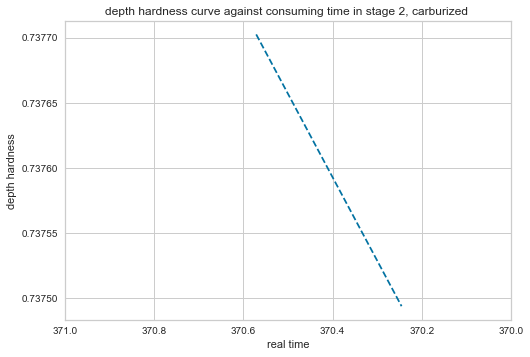

In [384]:
plt.plot(time_depth['real_time'],time_depth['depth_hardness'],ls='--')
plt.title('depth hardness curve against consuming time in stage 2, carburized process')
plt.xlabel('real time')
plt.ylabel('depth hardness')
plt.xlim([371, 370])
plt.show()

In [ ]:
시간변화가 너무적다. 품번에 대한 예상소요시간을 찾아보자 

change in furnace heat temperature(step 2): range 0.75,max to 0.53 min

In [53]:
Ridge_heat_temp=np.array([[ 0.69,  0.75, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.73, 0.4522,  0.2292, -0.5083, 0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.71, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.69, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.67, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.65, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.63, 0.4522,  0.2292, -0.5083, 0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.61, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0], #mean of heat temperature
                          [ 0.69,  0.59, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.57, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.55, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.53, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.50, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                         [  0.69,  0.47, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0], 
                         ])

In [54]:
ridge.predict(Ridge_heat_temp)

NameError: name 'ridge' is not defined

change in LNG 순간유량(step 2):range of 3.85 to -1.0675

In [211]:
Ridge_LNG=np.array([      [ 0.69,  0.61, 3.85,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69, 0.61,  3.35,  0.2292, -0.5083, 0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69, 0.61, 2.85,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.61, 2.35,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69, 0.61, 1.85,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.61, 1.35,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.61, 0.85,  0.2292, -0.5083, 0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.61, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0], # mean of LNG Flow
                          [ 0.69,  0.61, -.0522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.61, -0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.61, -.9522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.61, -1.0675,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                     ])

In [212]:
ridge.predict(Ridge_LNG)

array([0.7304183 , 0.73147483, 0.73253136, 0.7335879 , 0.73464443,
       0.73570096, 0.7367575 , 0.73759807, 0.73866391, 0.73950913,
       0.74056567, 0.7408093 ])

change in CP농도(step 2):range of 3.5738 to -2.56

In [213]:
Ridge_CP=np.array([      [ 0.69,  0.61, 0.4522,  3.5738, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69, 0.61,  0.4522,  3.1738, -0.5083, 0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69, 0.61, 0.4522,  2.5738, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.61, 0.4522,  2.1738, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69, 0.61, 0.4522,  1.5738, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.61, 0.4522,  1.1738, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.61, 0.4522,  0.5738, -0.5083, 0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.61, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0], # mean of CP
                          [ 0.69,  0.61, 0.4522,  -0.5738, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.61, 0.4522, -1.1738, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.61, 0.4522,  -1.5738, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.61, 0.4522,  -2.1738, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.61, 0.4522,  -2.56, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                     ])

In [214]:
ridge.predict(Ridge_CP)

array([0.74058489, 0.74022768, 0.73969186, 0.73933465, 0.73879884,
       0.73844163, 0.73790581, 0.73759807, 0.73688097, 0.73634516,
       0.73598795, 0.73545213, 0.73510725])

change in RX순간유량(step 2): 0.9266 to -2.0081

In [215]:
Ridge_RX=np.array([      [ 0.69,  0.61, 0.4522,  0.2292, 0.9266,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69, 0.61,  0.4522,  0.2292, 0.62, 0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69, 0.61,0.4522,  0.2292, 0.32,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.61, 0.4522,  0.2292, -0.1083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69, 0.61, 0.4522,  0.2292, -0.5083,  0,  0,  0,  0,  0,  1,  0,  1,  0],# mean of RX Flow
                          [ 0.69,  0.61, 0.4522,  0.2292, -0.7083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.61, 0.4522,  0.2292, -1.1083, 0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [ 0.69,  0.61, 0.4522,  0.2292, -1.4083,  0,  0,  0,  0,  0,  1,  0,  1,  0], 
                          [ 0.69,  0.61, 0.4522,  0.2292, -1.7083,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                          [  0.69,  0.61, 0.4522,  0.2292, -2.0081,  0,  0,  0,  0,  0,  1,  0,  1,  0],
                       
                     ])

In [216]:
ridge.predict(Ridge_RX)

array([0.71647803, 0.72099082, 0.72540647, 0.73171054, 0.73759807,
       0.74054184, 0.74642937, 0.75084502, 0.75526067, 0.75967337])

In [84]:
simulated_data=[]
c=666
for k in range(0,len(OP131[(OP131['measuredt']>='2021-11-17 22:03:00') & (OP131['measuredt']<='2021-11-18 00:46:00')])):
    c +=1.73
   # simulated_data.append[c]
    print(k,c)
    simulated_data.append(c)

for k in range(0,len(OP131[(OP131['measuredt']<='2021-11-18 06:45:00') & (OP131['measuredt']>='2021-11-18 00:47:00')])):
    c=911
    print(k,c)
    simulated_data.append(c)
    
c=911
for k in range(0,len(OP131[(OP131['measuredt']>='2021-11-18 06:46:00') & (OP131['measuredt']<='2021-11-18 09:52:00')])):
    c-=0.3
    print(k,c)
    simulated_data.append(c)

0 667.73
1 669.46
2 671.19
3 672.9200000000001
4 674.6500000000001
5 676.3800000000001
6 678.1100000000001
7 679.8400000000001
8 681.5700000000002
9 683.3000000000002
10 685.0300000000002
11 686.7600000000002
12 688.4900000000002
13 690.2200000000003
14 691.9500000000003
15 693.6800000000003
16 695.4100000000003
17 697.1400000000003
18 698.8700000000003
19 700.6000000000004
20 702.3300000000004
21 704.0600000000004
22 705.7900000000004
23 707.5200000000004
24 709.2500000000005
25 710.9800000000005
26 712.7100000000005
27 714.4400000000005
28 716.1700000000005
29 717.9000000000005
30 719.6300000000006
31 721.3600000000006
32 723.0900000000006
33 724.8200000000006
34 726.5500000000006
35 728.2800000000007
36 730.0100000000007
37 731.7400000000007
38 733.4700000000007
39 735.2000000000007
40 736.9300000000007
41 738.6600000000008
42 740.3900000000008
43 742.1200000000008
44 743.8500000000008
45 745.5800000000008
46 747.3100000000009
47 749.0400000000009
48 750.7700000000009
49 752.5000000

In [87]:
simulated_data2=pd.DataFrame(simulated_data)

In [88]:
simulated_data2.shape

(841, 1)

In [90]:
simulated_data2.set_index

<bound method DataFrame.set_index of            0
0   667.7300
1   669.4600
2   671.1900
3   672.9200
4   674.6500
..       ...
836 815.0000
837 814.7000
838 814.4000
839 814.1000
840 813.8000

[841 rows x 1 columns]>

In [152]:
simulated_data2

,0
0,667.73
1,669.46
2,671.19
3,672.92
4,674.65
...,...
836,815.00
837,814.70
838,814.40
839,814.10


In [153]:
OP131.reset_index(inplace=True)

In [154]:
OP131_2=pd.merge(OP131,simulated_data2,left_index=True, right_index=True)

In [155]:
OP131_2.rename(columns = {0:'simulated_heating_temperature'}, inplace = True)

In [156]:
OP131_2.columns

Index(['level_0', 'index', 'measuredt', 'sensor_id', '가열로히터온도', 'LNG순간유량',
       'RX_순간유량', 'CP농도', 'simulated_heating_temperature'],
      dtype='object')

In [152]:
scr.inverse_transform()

ValueError: non-broadcastable output operand with shape () doesn't match the broadcast shape (5,)

In [97]:
df4.columns

Index(['경화깊이', '공정시간_step', '가열로히터온도', 'LNG순간유량', 'CP농도', 'RX순간유량', '열처리_침탄질화',
       '품번_BM840-TF000', '품번_BM844 TH051', '품번_GC04400710', '품번_GC04410210',
       '품번_OP131-HD100', '품번_OP131-HD500', 'step_2침탄', 'step_3강온'],
      dtype='object')

# 심부경도

In [281]:
inside_ridge.predict(Ridge_heat_temp)

array([-126.29164796, -126.29213726, -126.29262656, -126.29311586,
       -126.29360516, -126.29409446, -126.29458376, -126.29507306,
       -126.29556236, -126.29605167, -126.29654097, -126.29703027])

In [ ]:
예측값이 음수?

# 표면경도

In [282]:
surface_ridge.predict(Ridge_heat_temp)

array([-126.29164796, -126.29213726, -126.29262656, -126.29311586,
       -126.29360516, -126.29409446, -126.29458376, -126.29507306,
       -126.29556236, -126.29605167, -126.29654097, -126.29703027])

In [ ]:
예측값이 음수?

In [44]:
OP131_0=df2[['measuredt','경화깊이','공정시간_step','가열로히터온도','LNG순간유량','CP농도','RX순간유량','열처리_침탄질화','step_2침탄','step_3강온','품번_BM840-TF000', '품번_BM844 TH051',
       '품번_GC04400710', '품번_GC04410210', '품번_OP131-HD100', '품번_OP131-HD500']]

In [45]:
OP131_0.columns

Index(['measuredt', '경화깊이', '공정시간_step', '가열로히터온도', 'LNG순간유량', 'CP농도',
       'RX순간유량', '열처리_침탄질화', 'step_2침탄', 'step_3강온', '품번_BM840-TF000',
       '품번_BM844 TH051', '품번_GC04400710', '품번_GC04410210', '품번_OP131-HD100',
       '품번_OP131-HD500'],
      dtype='object')

In [47]:
OP131=OP131_0[['measuredt','품번_OP131-HD100','공정시간_step','가열로히터온도']]

In [48]:
OP131

,measuredt,품번_OP131-HD100,공정시간_step,가열로히터온도
0,2021-11-17 03:12:00,0,124,639
1,2021-11-17 03:13:00,0,124,639
2,2021-11-17 03:14:00,0,124,639
3,2021-11-17 03:15:00,0,124,639
4,2021-11-17 03:16:00,0,124,639
...,...,...,...,...
10490,2021-12-04 02:42:00,1,118,870
10491,2021-12-04 02:43:00,1,118,847
10492,2021-12-04 02:44:00,1,118,780
10493,2021-12-04 02:45:00,1,118,693


In [49]:
OP131_1=OP131.loc[(OP131['품번_OP131-HD100'] == 1)]

In [50]:
OP131_1

,measuredt,품번_OP131-HD100,공정시간_step,가열로히터온도
1077,2021-11-17 21:52:00,1,174,666
1078,2021-11-17 21:53:00,1,174,666
1079,2021-11-17 21:54:00,1,174,666
1080,2021-11-17 21:55:00,1,174,666
1081,2021-11-17 21:56:00,1,174,666
...,...,...,...,...
10490,2021-12-04 02:42:00,1,118,870
10491,2021-12-04 02:43:00,1,118,847
10492,2021-12-04 02:44:00,1,118,780
10493,2021-12-04 02:45:00,1,118,693


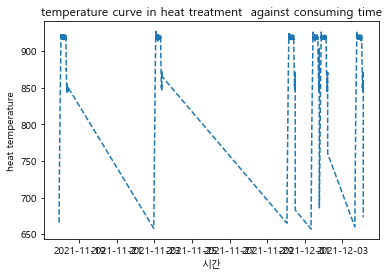

In [52]:
plt.plot(OP131_1['measuredt'],OP131_1['가열로히터온도'],ls='--')
plt.title('temperature curve in heat treatment  against consuming time')
plt.xlabel('시간')
plt.ylabel('heat temperature')
#plt.xlim([371, 370])
plt.show()